In [1]:
import nbimporter
import numpy as np
from functools import lru_cache
from scipy import optimize
import datetime

import s03_01_hc_load_general as ld
from s03_02_08_envelope_performance_detail import get_r_env

from s11_01_external_condition import load_outdoor, \
    get_T_ex, \
    get_Theta_ex, \
    get_X_ex, \
    calc_h_ex, \
    load_climate, \
    get_J

from s03_01_hc_load_general import \
    get_A_NR

from s04_07_i_pipe import \
    get_A_A_R

from s11_03_life_schedule import load_schedule, get_schedule_ac



In [2]:
# Êú™Âá¶ÁêÜË≤†Ëç∑„Å®Ê©üÂô®„ÅÆË®àÁÆó„Å´ÂøÖË¶Å„Å™Â§âÊï∞„ÇíÂèñÂæó
def calc_Q_UT_A(A_A, A_MR, A_OR, A_env, mu_H, mu_C, q_hs_rtd_H, q_hs_rtd_C, V_hs_dsgn_H, V_hs_dsgn_C, Q,
             VAV, general_ventilation, duct_insulation, region, L_H_d_t_i, L_CS_d_t_i, L_CL_d_t_i):

    # Â§ñÊ∞óÊù°‰ª∂
    outdoor = load_outdoor()
    Theta_ex_d_t = get_Theta_ex(region, outdoor)
    X_ex_d_t = get_X_ex(region, outdoor)
    climate = load_climate(region)
    J_d_t = get_J(climate)
    h_ex_d_t = calc_h_ex(X_ex_d_t, Theta_ex_d_t)

    A_HCZ_i = np.array([ld.get_A_HCZ_i(i, A_A, A_MR, A_OR) for i in range(1, 6)])
    A_HCZ_R_i = [ld.get_A_HCZ_R_i(i) for i in range(1, 6)]

    A_NR = get_A_NR(A_A, A_MR, A_OR)

    # (67)
    L_wtr = get_L_wtr()

    # (66d)
    n_p_NR_d_t = calc_n_p_NR_d_t(A_NR)

    # (66c)
    n_p_OR_d_t = calc_n_p_OR_d_t(A_OR)

    # (66b)
    n_p_MR_d_t = calc_n_p_MR_d_t(A_MR)

    # (66a)
    n_p_d_t = get_n_p_d_t(n_p_MR_d_t, n_p_OR_d_t, n_p_NR_d_t)

    # ‰∫∫‰ΩìÁô∫ÁÜ±
    q_p_H = get_q_p_H()
    q_p_CS = get_q_p_CS()
    q_p_CL = get_q_p_CL()

    # (65d)
    w_gen_NR_d_t = calc_w_gen_NR_d_t(A_NR)

    # (65c)
    w_gen_OR_d_t = calc_w_gen_OR_d_t(A_OR)

    # (65b)
    w_gen_MR_d_t = calc_w_gen_MR_d_t(A_MR)

    # (65a)
    w_gen_d_t = get_w_gen_d_t(w_gen_MR_d_t, w_gen_OR_d_t, w_gen_NR_d_t)

    # (64d)
    q_gen_NR_d_t = calc_q_gen_NR_d_t(A_NR)

    # (64c)
    q_gen_OR_d_t = calc_q_gen_OR_d_t(A_OR)

    # (64b)
    q_gen_MR_d_t = calc_q_gen_MR_d_t(A_MR)

    # (64a)
    q_gen_d_t = get_q_gen_d_t(q_gen_MR_d_t, q_gen_OR_d_t, q_gen_NR_d_t)

    # (63)
    V_vent_l_NR_d_t = get_V_vent_l_NR_d_t()
    V_vent_l_OR_d_t = get_V_vent_l_OR_d_t()
    V_vent_l_MR_d_t = get_V_vent_l_MR_d_t()
    V_vent_l_d_t = get_V_vent_l_d_t(V_vent_l_MR_d_t, V_vent_l_OR_d_t, V_vent_l_NR_d_t)

    # (62)
    V_vent_g_i = get_V_vent_g_i(A_HCZ_i, A_HCZ_R_i)

    # (61)
    U_prt = get_U_prt()

    # (60)
    r_env = get_r_env(A_env, A_A)
    A_prt_i = get_A_prt_i(A_HCZ_i, r_env, A_MR, A_NR, A_OR)

    # (59)
    Theta_SAT_d_t = get_Theta_SAT_d_t(Theta_ex_d_t, J_d_t)

    # (58)
    l_duct_ex_i = get_l_duct_ex_i(A_A)

    # (57)
    l_duct_in_i = get_l_duct_in_i(A_A)

    # (56)
    l_duct_i = get_l_duct__i(l_duct_in_i, l_duct_ex_i)

    # (51)
    X_star_HBR_d_t = get_X_star_HBR_d_t(X_ex_d_t, region)

    # (50)
    Theta_star_HBR_d_t = get_Theta_star_HBR_d_t(Theta_ex_d_t, region)

    # (55)
    Theta_attic_d_t = get_Theta_attic_d_t(Theta_SAT_d_t, Theta_star_HBR_d_t)

    # (54)
    Theta_sur_d_t_i = get_Theta_sur_d_t_i(Theta_star_HBR_d_t, Theta_attic_d_t, l_duct_in_i, l_duct_ex_i, duct_insulation)

    # (40)
    Q_hat_hs_d_t = calc_Q_hat_hs_d_t(Q, A_A, V_vent_l_d_t, V_vent_g_i, mu_H, mu_C, J_d_t, q_gen_d_t, n_p_d_t, q_p_H,
                                     q_p_CS, q_p_CL, X_ex_d_t, w_gen_d_t, Theta_ex_d_t, L_wtr, region)

    # (39)
    V_hs_min = get_V_hs_min(V_vent_g_i)

    # (38)
    Q_hs_rtd_C = get_Q_hs_rtd_C(q_hs_rtd_C)

    # (37)
    Q_hs_rtd_H = get_Q_hs_rtd_H(q_hs_rtd_H)

    # (36)
    V_dash_hs_supply_d_t = get_V_dash_hs_supply_d_t(V_hs_min, V_hs_dsgn_H, V_hs_dsgn_C, Q_hs_rtd_H, Q_hs_rtd_C, Q_hat_hs_d_t, region)

    # (45)
    r_supply_des_i = get_r_supply_des_i(A_HCZ_i)

    # (44)
    V_dash_supply_d_t_i = get_V_dash_supply_d_t_i(r_supply_des_i, V_dash_hs_supply_d_t, V_vent_g_i)

    # (53)
    X_star_NR_d_t = get_X_star_NR_d_t(X_star_HBR_d_t, L_CL_d_t_i, L_wtr, V_vent_l_NR_d_t, V_dash_supply_d_t_i, region)

    # (52)
    Theta_star_NR_d_t = get_Theta_star_NR_d_t(Theta_star_HBR_d_t, Q, A_NR, V_vent_l_NR_d_t, V_dash_supply_d_t_i, U_prt,
                                              A_prt_i, L_H_d_t_i, L_CS_d_t_i, region)

    # (49)
    X_NR_d_t = get_X_NR_d_t(X_star_NR_d_t)

    # (47)
    X_HBR_d_t_i = get_X_HBR_d_t_i(X_star_HBR_d_t)

    # (11)
    Q_star_trs_prt_d_t_i = get_Q_star_trs_prt_d_t_i(U_prt, A_prt_i, Theta_star_HBR_d_t, Theta_star_NR_d_t)

    # (10)
    L_star_CL_d_t_i = get_L_star_CL_d_t_i(L_CS_d_t_i, L_CL_d_t_i, region)

    # (9)
    L_star_CS_d_t_i = get_L_star_CS_d_t_i(L_CS_d_t_i, Q_star_trs_prt_d_t_i, region)

    # (8)
    L_star_H_d_t_i = get_L_star_H_d_t_i(L_H_d_t_i, Q_star_trs_prt_d_t_i, region)

    # (33)
    L_star_CL_d_t = get_L_star_CL_d_t(L_star_CL_d_t_i)

    # (32)
    L_star_CS_d_t = get_L_star_CS_d_t(L_star_CS_d_t_i)

    # (31)
    L_star_CL_max_d_t = get_L_star_CL_max_d_t(L_star_CS_d_t)

    # (30)
    L_star_dash_CL_d_t = get_L_star_dash_CL_d_t(L_star_CL_max_d_t, L_star_CL_d_t)

    # (29)
    L_star_dash_C_d_t = get_L_star_dash_C_d_t(L_star_CS_d_t, L_star_dash_CL_d_t)

    # (28)
    SHF_dash_d_t = get_SHF_dash_d_t(L_star_CS_d_t, L_star_dash_C_d_t)

    # (27)
    Q_hs_max_C_d_t = get_Q_hs_max_C_d_t(q_hs_rtd_C)

    # (26)
    Q_hs_max_CL_d_t = get_Q_hs_max_CL_d_t(Q_hs_max_C_d_t, SHF_dash_d_t, L_star_dash_CL_d_t)

    # (25)
    Q_hs_max_CS_d_t = get_Q_hs_max_CS_d_t(Q_hs_max_C_d_t, SHF_dash_d_t)

    # (24)
    C_df_H_d_t = get_C_df_H_d_t(Theta_ex_d_t, h_ex_d_t)

    # (23)
    Q_hs_max_H_d_t = get_Q_hs_max_H_d_t(q_hs_rtd_H, C_df_H_d_t)

    # (20)
    X_star_hs_in_d_t = get_X_star_hs_in_d_t(X_star_NR_d_t)

    # (19)
    Theta_star_hs_in_d_t = get_Theta_star_hs_in_d_t(Theta_star_NR_d_t)

    # (18)
    X_hs_out_min_C_d_t = get_X_hs_out_min_C_d_t(X_star_hs_in_d_t, Q_hs_max_CL_d_t, V_dash_supply_d_t_i)

    # (22)
    X_req_d_t_i = get_X_req_d_t_i(X_star_HBR_d_t, L_star_CL_d_t_i, V_dash_supply_d_t_i, region)

    # (21)
    Theta_req_d_t_i = get_Theta_req_d_t_i(Theta_sur_d_t_i, Theta_star_HBR_d_t, V_dash_supply_d_t_i,
                        L_star_H_d_t_i, L_star_CS_d_t_i, l_duct_i, region)

    # (15)
    X_hs_out_d_t = get_X_hs_out_d_t(X_NR_d_t, X_req_d_t_i, V_dash_supply_d_t_i, X_hs_out_min_C_d_t, L_star_CL_d_t_i, region)

    # Âºè(14)(46)(48)„ÅÆÊù°‰ª∂„Å´Âêà„Çè„Åõ„Å¶Theta_NR_d_t„ÇíÂàùÊúüÂåñ
    Theta_NR_d_t = np.zeros(24 * 365)

    # (17)
    Theta_hs_out_min_C_d_t = get_Theta_hs_out_min_C_d_t(Theta_star_hs_in_d_t, Q_hs_max_CS_d_t, V_dash_supply_d_t_i)

    # (16)
    Theta_hs_out_max_H_d_t = get_Theta_hs_out_max_H_d_t(Theta_star_hs_in_d_t, Q_hs_max_H_d_t, V_dash_supply_d_t_i)

    # L_star_H_d_t_iÔºåL_star_CS_d_t_i„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîª1ÔΩû5„ÇíÂêàÁÆó„Åó0‰ª•‰∏ä„Å†„Å£„ÅüÂ†¥Âêà„ÅÆÈ†ÜÂ∫è„ÅßË®àÁÆó
    # (14)
    Theta_hs_out_d_t = get_Theta_hs_out_d_t(VAV, Theta_req_d_t_i, V_dash_supply_d_t_i,
                                            L_star_H_d_t_i, L_star_CS_d_t_i, region, Theta_NR_d_t,
                                            Theta_hs_out_max_H_d_t, Theta_hs_out_min_C_d_t)

    # (43)
    V_supply_d_t_i = get_V_supply_d_t_i(L_star_H_d_t_i, L_star_CS_d_t_i, Theta_sur_d_t_i, l_duct_i, Theta_star_HBR_d_t,
                                                    V_vent_g_i, V_dash_supply_d_t_i, VAV, region, Theta_hs_out_d_t)

    # (41)
    Theta_supply_d_t_i = get_Thata_supply_d_t_i(Theta_sur_d_t_i, Theta_hs_out_d_t, Theta_star_HBR_d_t, l_duct_i,
                                                   V_supply_d_t_i, L_star_H_d_t_i, L_star_CS_d_t_i, region)

    # (46)
    Theta_HBR_d_t_i = get_Theta_HBR_d_t_i(Theta_star_HBR_d_t, V_supply_d_t_i, Theta_supply_d_t_i, U_prt, A_prt_i, Q,
                                             A_HCZ_i, L_star_H_d_t_i, L_star_CS_d_t_i, region)

    # (48)
    Theta_NR_d_t = get_Theta_NR_d_t(Theta_star_NR_d_t, Theta_star_HBR_d_t, Theta_HBR_d_t_i, A_NR, V_vent_l_NR_d_t,
                                        V_dash_supply_d_t_i, V_supply_d_t_i, U_prt, A_prt_i, Q)

     # L_star_H_d_t_iÔºåL_star_CS_d_t_i„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîª1ÔΩû5„ÇíÂêàÁÆó„Åó0‰ª•‰∏ã„Å†„Å£„ÅüÂ†¥Âêà„ÅÆÁÇ∫„Å´ÂÜçË®àÁÆó
     # (14)
    Theta_hs_out_d_t = get_Theta_hs_out_d_t(VAV, Theta_req_d_t_i, V_dash_supply_d_t_i,
                                            L_star_H_d_t_i, L_star_CS_d_t_i, region, Theta_NR_d_t,
                                            Theta_hs_out_max_H_d_t, Theta_hs_out_min_C_d_t)

    # (42)
    X_supply_d_t_i = get_X_supply_d_t_i(X_star_HBR_d_t, X_hs_out_d_t, L_star_CL_d_t_i, region)

    # (35)
    V_hs_vent_d_t = get_V_hs_vent_d_t(V_vent_g_i, general_ventilation)

    # (34)
    V_hs_supply_d_t = get_V_hs_supply_d_t(V_supply_d_t_i)

    # (13)
    X_hs_in_d_t = get_X_hs_in_d_t(X_NR_d_t)

    # (12)
    Theta_hs_in_d_t = get_Theta_hs_in_d_t(Theta_NR_d_t)

    # (7)
    L_dash_CL_d_t_i = get_L_dash_CL_d_t_i(V_supply_d_t_i, X_HBR_d_t_i, X_supply_d_t_i, region)

    # (6)
    L_dash_CS_d_t_i = get_L_dash_CS_d_t_i(V_supply_d_t_i, Theta_supply_d_t_i, Theta_HBR_d_t_i, region)

    # (5)
    L_dash_H_d_t_i = get_L_dash_H_d_t_i(V_supply_d_t_i, Theta_supply_d_t_i, Theta_HBR_d_t_i, region)

    # (4)
    Q_UT_CL_d_t_i = get_Q_UT_CL_d_t_i(L_star_CL_d_t_i, L_dash_CL_d_t_i)

    # (3)
    Q_UT_CS_d_t_i = get_Q_UT_CS_d_t_i(L_star_CS_d_t_i, L_dash_CS_d_t_i)

    # (2)
    Q_UT_H_d_t_i = get_Q_UT_H_d_t_i(L_star_H_d_t_i, L_dash_H_d_t_i)

    # (1)
    E_C_UT_d_t = get_E_C_UT_d_t(Q_UT_CL_d_t_i, Q_UT_CS_d_t_i, region)

    return E_C_UT_d_t, Q_UT_H_d_t_i, Q_UT_CS_d_t_i, Q_UT_CL_d_t_i, Theta_hs_out_d_t, Theta_hs_in_d_t, \
           X_hs_out_d_t, X_hs_in_d_t, V_hs_supply_d_t, V_hs_vent_d_t, C_df_H_d_t


## Á¨¨‰∫åÁØÄ„ÄÄ„ÉÄ„ÇØ„ÉàÂºè„Çª„É≥„Éà„É©„É´Á©∫Ë™øÊ©ü / Section 2 Duct type central air conditioner

1ÔºéÈÅ©Áî®ÁØÑÂõ≤ÔΩû4ÔºéË®òÂè∑Âèä„Å≥Âçò‰Ωç„ÅØÁúÅÁï•

1. Scope of application ~ 4. Symbols and units are omitted

### 5ÔºéÊöñÊàø„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè

#### 5.1 Ê∂àË≤ªÈõªÂäõÈáè / Power consumption

ÁúÅÁï•

#### 5.2 „Ç¨„ÇπÊ∂àË≤ªÈáè

Êó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆ„Ç¨„ÇπÊ∂àË≤ªÈáè$E_{G,H,d,t}$„ÅØ0„Å®„Åô„Çã„ÄÇ

In [3]:
def get_E_G_H_d_t():
    """„Ç¨„ÇπÊ∂àË≤ªÈáè
    „Ç¨„ÇπÊ∂àË≤ªÈáè„ÅØ0„Å®„Åô„Çã

    :return: „Ç¨„ÇπÊ∂àË≤ªÈáè
    :rtype: ndarray
    """
    # „Ç¨„ÇπÊ∂àË≤ªÈáè„ÅØ0„Å®„Åô„Çã
    return np.zeros(24 * 365)

#### 5.3 ÁÅØÊ≤πÊ∂àË≤ªÈáè

Êó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆ„ÅÆÁÅØÊ≤πÊ∂àË≤ªÈáè$E_{K,H,d,t}$„ÅØ0„Å®„Åô„Çã„ÄÇ

In [4]:
def get_E_K_H_d_t():
    """ÁÅØÊ≤πÊ∂àË≤ªÈáè
    ÁÅØÊ≤πÊ∂àË≤ªÈáè„ÅØ0„Å®„Åô„Çã
    
    :return: ÁÅØÊ≤πÊ∂àË≤ªÈáè
    :rtype: ndarray
    """
    # ÁÅØÊ≤πÊ∂àË≤ªÈáè„ÅØ0„Å®„Åô„Çã
    return np.zeros(24 * 365)

#### 5.4 „Åù„ÅÆ‰ªñ„ÅÆÁáÉÊñô„Å´„Çà„Çã‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè

Êó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆ„Åù„ÅÆ‰ªñ„ÅÆÁáÉÊñô„Å´„Çà„Çã‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè$E_{M,H,d,t}$„ÅØ0„Å®„Åô„Çã„ÄÇ

In [5]:
def get_E_M_H_d_t():
    """„Åù„ÅÆ‰ªñ„ÅÆÁáÉÊñô„Å´„Çà„Çã‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè
    
    :return: „Åù„ÅÆ‰ªñ„ÅÆÁáÉÊñô„Å´„Çà„Çã‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè
    :rtype: ndarray
    """
    # „Åù„ÅÆ‰ªñ„ÅÆÁáÉÊñô„Å´„Çà„Çã‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè„ÅØ0„Å®„Åô„Çã
    return np.zeros(24 * 365)

### 6ÔºéÂÜ∑Êàø„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè

#### 6.1„ÄÄÊ∂àË≤ªÈõªÂäõÈáè / Power consumption

ÁúÅÁï•

#### 6.2 „Ç¨„ÇπÊ∂àË≤ªÈáè

Êó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆ„Ç¨„ÇπÊ∂àË≤ªÈáè$E_{G,C,d,t}$„ÅØ0„Å®„Åô„Çã„ÄÇ

In [6]:
def get_E_G_C_d_t():
    # „Ç¨„ÇπÊ∂àË≤ªÈáè„ÅØ0„Å®„Åô„Çã
    return np.zeros(24 * 365)

#### 6.3 ÁÅØÊ≤πÊ∂àË≤ªÈáè

Êó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÅØÊ≤πÊ∂àË≤ªÈáè$E_{K,C,d,t}$„ÅØ0„Å®„Åô„Çã„ÄÇ

In [7]:
def get_E_K_C_d_t():
    # ÁÅØÊ≤πÊ∂àË≤ªÈáè„ÅØ0„Å®„Åô„Çã
    return np.zeros(24 * 365)

#### 6.4 „Åù„ÅÆ‰ªñ„ÅÆÁáÉÊñô„Å´„Çà„Çã‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè

Êó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆ„Åù„ÅÆ‰ªñ„ÅÆÁáÉÊñô„Å´„Çà„Çã‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè$E_{M,C,d,t}$„ÅØ0„Å®„Åô„Çã„ÄÇ

In [8]:
def get_E_M_C_d_t():
    # „Åù„ÅÆ‰ªñ„ÅÆÁáÉÊñô„Å´„Çà„Çã‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè„ÅØ0„Å®„Åô„Çã
    return np.zeros(24 * 365)

### 7ÔºéÂÜ∑ÊàøË®≠ÂÇô„ÅÆÊú™Âá¶ÁêÜÂÜ∑ÊàøË≤†Ëç∑„ÅÆË®≠Ë®à‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáèÁõ∏ÂΩìÂÄ§

$$\large
E_{C,UT,d,t} = \sum^5_{i=1} \alpha_{UT,C}(Q_{UT,CL,d,t,i}+Q_{UT,CS,d,t,i})
$$

$E_{C,UT,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÂÜ∑ÊàøË®≠ÂÇô„ÅÆÊú™Âá¶ÁêÜÂÜ∑ÊàøË≤†Ëç∑„ÅÆË®≠Ë®à‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáèÁõ∏ÂΩì
ÂÄ§(MJ/h)  
$Q_{UT,CL,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîª$i$„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÂÜ∑ÊàøË®≠ÂÇôÊ©üÂô®„ÅÆÊú™Âá¶ÁêÜÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑(MJ/h) 
$Q_{UT,CS,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîª$i$„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÂÜ∑ÊàøË®≠ÂÇôÊ©üÂô®„ÅÆÊú™Âá¶ÁêÜÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑(MJ/h)  
$\alpha_{UT,C}$ÔºöÂÜ∑ÊàøË®≠ÂÇô„ÅÆÊú™Âá¶ÁêÜÂÜ∑ÊàøË≤†Ëç∑„ÇíÊú™Âá¶ÁêÜÂÜ∑ÊàøË≤†Ëç∑„ÅÆË®≠Ë®à‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáèÁõ∏ÂΩìÂÄ§„Å´ÊèõÁÆó„Åô„Çã‰øÇÊï∞(-)  

In [9]:
def get_E_C_UT_d_t(Q_UT_CL_d_t_i, Q_UT_CS_d_t_i, region):
    """(1)

    :param Q_UT_CL_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÂÜ∑ÊàøÊ©üÂô®„ÅÆÊú™Âá¶ÁêÜÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    :param Q_UT_CS_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÂÜ∑ÊàøÊ©üÂô®„ÅÆÊú™Âá¶ÁêÜÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    :param region:Âú∞ÂüüÂå∫ÂàÜ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÂÜ∑ÊàøË®≠ÂÇô„ÅÆÊú™Âá¶ÁêÜÂÜ∑ÊàøË≤†Ëç∑„ÅÆË®≠Ë®à‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáèÁõ∏ÂΩìÂÄ§ÔºàMJ/hÔºâ
    """
    # ÊöñÊàøË®≠ÂÇô„ÅÆÊú™Âá¶ÁêÜÂÜ∑ÊàøË≤†Ëç∑„ÇíÊú™Âá¶ÁêÜÊöñÊàøË≤†Ëç∑„ÅÆË®≠Ë®à‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáèÁõ∏ÂΩìÂÄ§„Å´ÊèõÁÆó„Åô„Çã‰øÇÊï∞Œ±_(UT,H)Ôºà-Ôºâ„ÇíÂèñÂæó
    from s04_01_general import \
       get_alpha_UT_H_A

    region = 7 if region == 8 else region

    alpha_UT_H_A = get_alpha_UT_H_A(region)

    # ÂÜ∑ÊàøË®≠ÂÇô„ÅÆÊú™Âá¶ÁêÜÂÜ∑ÊàøË≤†Ëç∑„ÇíÊú™Âá¶ÁêÜÂÜ∑ÊàøË≤†Ëç∑„ÅÆË®≠Ë®à‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáèÁõ∏ÂΩìÂÄ§„Å´ÊèõÁÆó„Åô„Çã‰øÇÊï∞Ôºà-Ôºâ
    alpha_UT_C = alpha_UT_H_A

    return np.sum(alpha_UT_C * (Q_UT_CL_d_t_i + Q_UT_CS_d_t_i), axis=0)

### 8ÔºéÊú™Âá¶ÁêÜË≤†Ëç∑

$$\large
Q_{UT,H,d,t,i}=max(L^*_{H,d,t,i}-L'_{H,d,t,i} , 0)
$$

$$\large
Q_{UT,CS,d,t,i}=max(L^*_{CS,d,t,i}-L'_{CS,d,t,i} , 0)
$$

$$\large
Q_{UT,CL,d,t,i}=max(L^*_{CL,d,t,i}-L'_{CL,d,t,i} , 0)
$$

$L'_{CL,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÈñì‰ªïÂàá„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄÂÆüÈöõ„ÅÆÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑(MJ/h)  
$L'_{CS,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÈñì‰ªïÂàá„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄÂÆüÈöõ„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑(MJ/h)  
$L'_{H,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÈñì‰ªïÂàá„Çä„ÅÆÁÜ±ÊêçÂ§±„ÇíÂê´„ÇÄÂÆüÈöõ„ÅÆÊöñÊàøË≤†Ëç∑(MJ/h)  
$L^*_{CL,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑(MJ/h)  
$L^*_{CS,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑(MJ/h)  
$L^*_{H,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÊêçÂ§±„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÊöñÊàøË≤†Ëç∑(MJ/h)  
$Q_{UT,CL,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîª$i$„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÂÜ∑ÊàøË®≠ÂÇôÊ©üÂô®„ÅÆÊú™Âá¶ÁêÜÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑(MJ/h)  
$Q_{UT,CS,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîª$i$„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÂÜ∑ÊàøË®≠ÂÇôÊ©üÂô®„ÅÆÊú™Âá¶ÁêÜÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑(MJ/h)  
$Q_{UT,H,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîª$i$„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊöñÊàøË®≠ÂÇôÊ©üÂô®Á≠â„ÅÆÊú™Âá¶ÁêÜÊöñÊàøË≤†Ëç∑(MJ/h)  


In [10]:
def get_Q_UT_H_d_t_i(L_star_H_d_t_i, L_dash_H_d_t_i):
    """(2)

    :param L_star_H_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÊêçÂ§±„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÊöñÊàøË≤†Ëç∑ÔºàMJ/hÔºâ
    :param L_dash_H_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÈñì‰ªïÂàá„Çä„ÅÆÁÜ±ÊêçÂ§±„ÇíÂê´„ÇÄÂÆüÈöõ„ÅÆÊöñÊàøË≤†Ëç∑ÔºàMJ/hÔºâ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÊöñÊàøË®≠ÂÇôÊ©üÂô®Á≠â„ÅÆÊú™Âá¶ÁêÜÊöñÊàøË≤†Ëç∑ÔºàMJ/hÔºâ
    """
    return np.clip(L_star_H_d_t_i[:5] - L_dash_H_d_t_i[:5], 0, None)

def get_Q_UT_CS_d_t_i(L_star_CS_d_t_i, L_dash_CS_d_t_i):
    """ (3)

    :param L_star_CS_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÊêçÂ§±„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    :param L_dash_CS_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÈñì‰ªïÂàá„Çä„ÅÆÁÜ±ÊêçÂ§±„ÇíÂê´„ÇÄÂÆüÈöõ„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÂÜ∑ÊàøÊ©üÂô®„ÅÆÊú™Âá¶ÁêÜÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    """
    return np.clip(L_star_CS_d_t_i[:5] - L_dash_CS_d_t_i[:5], 0, None)

def get_Q_UT_CL_d_t_i(L_star_CL_d_t_i, L_dash_CL_d_t_i):
    """(4)

    :param L_star_CL_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÊêçÂ§±„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    :param L_dash_CS_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÈñì‰ªïÂàá„Çä„ÅÆÁÜ±ÊêçÂ§±„ÇíÂê´„ÇÄÂÆüÈöõ„ÅÆÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÂÜ∑ÊàøÂå∫Áîªi„Å´Ë®≠ÁΩÆ„Åï„Çå„ÅüÂÜ∑ÊàøÊ©üÂô®„ÅÆÊú™Âá¶ÁêÜÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    """
    return np.clip(L_star_CL_d_t_i[:5] - L_dash_CL_d_t_i[:5], 0, None)

ÊöñÊàøÊúüÔºö

$$\large
L'_{H,d,t,i}=c_{p_{air}}\rho_{air}V_{supply,d,t,i}(\theta_{supply,d,t,i}-\theta_{HBR,d,t,i})\times10^{-6}
$$

$$\large
L'_{CS,d,t,i}=0.0
$$

$$\large
L'_{CL,d,t,i}=0.0
$$

ÂÜ∑ÊàøÊúüÔºö

$$\large
L'_{H,d,t,i}=0.0
$$

$$\large
L'_{CS,d,t,i}=c_{p_{air}}\rho_{air}V_{supply,d,t,i}(\theta_{HBR,d,t,i}-\theta_{supply,d,t,i})\times10^{-6}
$$

$$\large
L'_{CL,d,t,i}=L_{wtr}\rho_{air}V_{supply,d,t,i}(X_{HBR,d,t,i}-X_{supply,d,t,i})\times10^{-3}
$$

‰∏≠ÈñìÊúüÔºö

$$\large
L'_{H,d,t,i}=0.0
$$

$$\large
L'_{CS,d,t,i}=0.0
$$

$$\large
L'_{CL,d,t,i}=0.0
$$

$L'_{CL,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÈñì‰ªïÂàá„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄÂÆüÈöõ„ÅÆÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑(MJ/h)  
$L'_{CS,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÈñì‰ªïÂàá„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄÂÆüÈöõ„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑(MJ/h)  
$L'_{H,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÈñì‰ªïÂàá„Çä„ÅÆÁÜ±ÊêçÂ§±„ÇíÂê´„ÇÄÂÆüÈöõ„ÅÆÊöñÊàøË≤†Ëç∑(MJ/h)  
$V_{supply,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®Èáè($m^3$/h)  
$X_{HBR,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂÆüÈöõ„ÅÆÂ±ÖÂÆ§„ÅÆÁµ∂ÂØæÊπøÂ∫¶(kg/kg(DA))  
$X_{supply,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂêπ„ÅçÂá∫„ÅóÁµ∂ÂØæÊπøÂ∫¶(kg/kg(DA))  
$\theta_{HBR,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂÆüÈöõ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©(‚ÑÉ)  
$\theta_{supply,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂêπ„ÅçÂá∫„ÅóÊ∏©Â∫¶(‚ÑÉ)  
$c_{p_{air}}$ÔºöÁ©∫Ê∞ó„ÅÆÊØîÁÜ±(J/(kg„ÉªK))  
$L_{wtr}$ÔºöÊ∞¥„ÅÆËí∏Áô∫ÊΩúÁÜ±(kJ/kg)  
$\rho_{air}$ÔºöÁ©∫Ê∞ó„ÅÆÂØÜÂ∫¶(kg/$m^3$)  


In [11]:
def get_L_dash_H_d_t_i(V_supply_d_t_i, Theta_supply_d_t_i, Theta_HBR_d_t_i, region):
    """(5-1)(5-2)(5-3)

    :param V_supply_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®ÈáèÔºàm3/hÔºâ
    :param Theta_supply_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂêπ„ÅçÂá∫„ÅóÊ∏©Â∫¶Ôºà‚ÑÉÔºâ
    :param Theta_HBR_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂÆüÈöõ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©Ôºà‚ÑÉÔºâ
    :param region:Âú∞ÂüüÂå∫ÂàÜ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÈñì‰ªïÂàá„Çä„ÅÆÁÜ±ÊêçÂ§±„ÇíÂê´„ÇÄÂÆüÈöõ„ÅÆÊöñÊàøË≤†Ëç∑ÔºàMJ/hÔºâ
    """
    c_p_air = get_c_p_air()
    rho_air = get_rho_air()
    H, C, M = get_season_array_d_t(region)

    L_dash_H_d_t_i = np.zeros((5, 24 * 365))

    # ÊöñÊàøÊúü (5-1)
    L_dash_H_d_t_i[:, H] = c_p_air * rho_air * V_supply_d_t_i[:, H] * (Theta_supply_d_t_i[:, H] - Theta_HBR_d_t_i[:, H]) * 10 ** -6

    # ÂÜ∑ÊàøÊúü (5-2)
    L_dash_H_d_t_i[:, C] = 0.0

    # ‰∏≠ÈñìÊúü (5-3)
    L_dash_H_d_t_i[:, M] = 0.0

    return L_dash_H_d_t_i


def get_L_dash_CS_d_t_i(V_supply_d_t_i, Theta_supply_d_t_i, Theta_HBR_d_t_i, region):
    """(6-1)(6-2)(6-3)
    :param V_supply_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®ÈáèÔºàm3/hÔºâ
    :param Theta_supply_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂêπ„ÅçÂá∫„ÅóÊ∏©Â∫¶Ôºà‚ÑÉÔºâ
    :param Theta_HBR_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂÆüÈöõ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©Ôºà‚ÑÉÔºâ
    :param region:Âú∞ÂüüÂå∫ÂàÜ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÈñì‰ªïÂàá„Çä„ÅÆÁÜ±ÊêçÂ§±„ÇíÂê´„ÇÄÂÆüÈöõ„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±„Åä„Çà„Å≥ÊΩúÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    """
    c_p_air = get_c_p_air()
    rho_air = get_rho_air()
    H, C, M = get_season_array_d_t(region)

    L_dash_CS_d_t_i = np.zeros((5, 24 * 365))

    # ÊöñÊàøÊúü (6-1)
    L_dash_CS_d_t_i[:, H] = 0.0

    # ÂÜ∑ÊàøÊúü (6-2)
    L_dash_CS_d_t_i[:, C] = c_p_air * rho_air * V_supply_d_t_i[:, C] * (Theta_HBR_d_t_i[:, C] - Theta_supply_d_t_i[:, C]) * 10 ** -6

    # ‰∏≠ÈñìÊúü (6-3)
    L_dash_CS_d_t_i[:, M] = 0.0

    return L_dash_CS_d_t_i



def get_L_dash_CL_d_t_i(V_supply_d_t_i, X_HBR_d_t_i, X_supply_d_t_i, region):
    """(7-1)(7-2)(7-3)

    :param V_supply_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®ÈáèÔºàm3/hÔºâ
    :param X_HBR_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂÆüÈöõ„ÅÆÂ±ÖÂÆ§„ÅÆÁµ∂ÂØæÊπøÂ∫¶Ôºàkg/kg(DA)Ôºâ
    :param X_supply_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂêπ„ÅçÂá∫„ÅóÁµ∂ÂØæÊπøÂ∫¶Ôºàkg/kg(DA)Ôºâ
    :param region:Âú∞ÂüüÂå∫ÂàÜ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÈñì‰ªïÂàá„Çä„ÅÆÁÜ±ÊêçÂ§±„ÇíÂê´„ÇÄÂÆüÈöõ„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±„Åä„Çà„Å≥ÊΩúÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    """
    L_wtr = get_L_wtr()
    rho_air = get_rho_air()
    H, C, M = get_season_array_d_t(region)

    L_dash_CL_d_t_i = np.zeros((5, 24 * 365))

    # ÊöñÊàøÊúü (7-1)
    L_dash_CL_d_t_i[:, H] = 0.0

    # ÂÜ∑ÊàøÊúü (7-2)
    L_dash_CL_d_t_i[:, C] = L_wtr * rho_air * V_supply_d_t_i[:, C] * (X_HBR_d_t_i[:, C] - X_supply_d_t_i[:, C]) * 10 ** -3

    # ‰∏≠ÈñìÊúü (7-3)
    L_dash_CL_d_t_i[:, M] = 0.0

    return L_dash_CL_d_t_i

ÊöñÊàøÊúüÔºö

$$\large
L^*_{H,d,t,i}=\left\{ \begin{array}{ll}
    max(L_{H,d,t,i}+Q^*_{trs,prt,d,t,i},0) &(L_{H,d,t,i}>0)\\ 
    0 &(L_{H,d,t,i} \leq 0)\\ 
    \end{array}
\right.
$$

$$\large
L^*_{CS,d,t,i}=0
$$

$$\large
L^*_{CL,d,t,i}=0
$$

ÂÜ∑ÊàøÊúüÔºö

$$\large
L^*_{H,d,t,i}=0
$$

$$\large
L^*_{CS,d,t,i}=\left\{ \begin{array}{ll}
    max(L_{CS,d,t,i}+Q^*_{trs,prt,d,t,i},0) &(L_{CS,d,t,i}>0)\\ 
    0 &(L_{CS,d,t,i} \leq 0)\\ 
    \end{array}
\right.
$$

$$\large
L^*_{CL,d,t,i}=\left\{ \begin{array}{ll}
    max(L_{CL,d,t,i},0) &(L_{CS,d,t,i}>0)\\ 
    0 &(L_{CS,d,t,i} \leq 0)\\ 
    \end{array}
\right.
$$

‰∏≠ÈñìÊúüÔºö

$$\large
L^*_{H,d,t,i}=0
$$

$$\large
L^*_{CS,d,t,i}=0
$$

$$\large
L^*_{CL,d,t,i}=0
$$

$L_{CL,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑(MJ/h)  
$L_{CS,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑(MJ/h)  
$L_{H,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÊàøË≤†Ëç∑(MJ/h)  
$L^*_{CL,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑(MJ/h)  
$L^*_{CS,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑(MJ/h)  
$L^*_{H,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÊêçÂ§±„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÊöñÊàøË≤†Ëç∑(MJ/h)  
$Q^*_{trs,prt,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÊêçÂ§±„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÈùûÂ±ÖÂÆ§„Å∏„ÅÆÁÜ±ÁßªÂãï(MJ/h)  


In [12]:
def get_L_star_H_d_t_i(L_H_d_t_i, Q_star_trs_prt_d_t_i, region):
    """(8-1)(8-2)(8-3)

    :param L_H_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÊàøË≤†Ëç∑ÔºàMJ/hÔºâ
    :param Q_star_trs_prt_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÊêçÂ§±„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÈùûÂ±ÖÂÆ§„Å∏„ÅÆÁÜ±ÁßªÂãïÔºàMJ/hÔºâ
    :param region:Âú∞ÂüüÂå∫ÂàÜ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÊêçÂ§±„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÊöñÊàøË≤†Ëç∑
    """
    H, C, M = get_season_array_d_t(region)
    L_H_d_t_i = L_H_d_t_i[:5]
    f = L_H_d_t_i > 0

    Hf = np.logical_and(H, f)

    L_star_H_d_t_i = np.zeros((5, 24 * 365))
    L_star_H_d_t_i[Hf] = np.clip(L_H_d_t_i[Hf] + Q_star_trs_prt_d_t_i[Hf], 0, None)
    return L_star_H_d_t_i


def get_L_star_CS_d_t_i(L_CS_d_t_i, Q_star_trs_prt_d_t_i, region):
    """(9-2)(9-2)(9-3)

    :param L_CS_t_i: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    :param Q_star_trs_prt_d_t_i: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÊêçÂ§±„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÈùûÂ±ÖÂÆ§„Å∏„ÅÆÁÜ±ÁßªÂãïÔºàMJ/hÔºâ
    :param region:Âú∞ÂüüÂå∫ÂàÜ
    :return: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÊêçÂ§±„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑
    """
    H, C, M = get_season_array_d_t(region)
    L_CS_d_t_i = L_CS_d_t_i[:5]
    f = L_CS_d_t_i > 0

    Cf = np.logical_and(C, f)

    L_star_CS_d_t_i = np.zeros((5, 24 * 365))
    L_star_CS_d_t_i[Cf] = np.clip(L_CS_d_t_i[Cf] + Q_star_trs_prt_d_t_i[Cf], 0, None)
    return L_star_CS_d_t_i

def get_L_star_CL_d_t_i(L_CS_d_t_i, L_CL_d_t_i, region):
    """(10-1)(10-2)(10-3)

    :param L_CL_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    :param region:Âú∞ÂüüÂå∫ÂàÜ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÊêçÂ§±„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑
    """
    H, C, M = get_season_array_d_t(region)
    L_CL_d_t_i = L_CL_d_t_i[:5]
    L_CS_d_t_i = L_CS_d_t_i[:5]
    f = L_CS_d_t_i > 0

    Cf = np.logical_and(C, f)

    L_star_CL_d_t_i = np.zeros((5, 24 * 365))

    L_star_CL_d_t_i[Cf] = L_CL_d_t_i[Cf]

    return L_star_CL_d_t_i

$$\large
Q^*_{trs,prt,d,t,i}=U_{prt}A_{prt,i}(\theta^*_{HBR,d,t}-\theta^*_{NR,d,t})\times 3600 \times 10^{-6}
$$


$A_{prt,i}$ÔºöÊöñÂÜ∑ÊàøÂå∫Áîª$i$„Åã„ÇâË¶ã„ÅüÈùûÂ±ÖÂÆ§„ÅÆÈñì‰ªïÂàá„Çä„ÅÆÈù¢Á©ç($m^2$)  
$Q^*_{trs,prt,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÊêçÂ§±„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÈùûÂ±ÖÂÆ§„Å∏„ÅÆÁÜ±ÁßªÂãï(MJ/h)  
$U_{prt}$ÔºöÈñì‰ªïÂàá„Çä„ÅÆÁÜ±Ë≤´ÊµÅÁéá(W/($m^2$„ÉªK))  
$\theta^*_{HBR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©(‚ÑÉ)  
$\theta^*_{NR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÈùûÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©(‚ÑÉ)  


In [13]:
def get_Q_star_trs_prt_d_t_i(U_prt, A_prt_i, Theta_star_HBR_d_t, Theta_star_NR_d_t):
    """(11)

    :param U_prt:Èñì‰ªïÂàá„Çä„ÅÆÁÜ±Ë≤´ÊµÅÁéáÔºàW/(m2„ÉªK)Ôºâ
    :param A_prt_i:ÊöñÂÜ∑ÊàøÂå∫Áîªi„Åã„ÇâË¶ã„ÅüÈùûÂ±ÖÂÆ§„ÅÆÈñì‰ªïÂàá„Çä„ÅÆÈù¢Á©çÔºàm2Ôºâ
    :param Theta_star_HBR_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©Ôºà‚ÑÉÔºâ
    :param Theta_star_NR_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÈùûÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©Ôºà‚ÑÉÔºâ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÊêçÂ§±„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÈùûÂ±ÖÂÆ§„Å∏„ÅÆÁÜ±ÁßªÂãïÔºàMJ/hÔºâ
    """
    return U_prt * A_prt_i[:5, np.newaxis] * (Theta_star_HBR_d_t - Theta_star_NR_d_t) * 3600 * 10 ** -6

### 9. ÁÜ±Ê∫êÊ©ü

#### 9.1 ÁÜ±Ê∫êÊ©ü„ÅÆÂÖ•Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶„ÉªÁµ∂ÂØæÊπøÂ∫¶

$$\large
\theta_{hs,in,d,t} = \theta_{NR,d,t}
$$


$\theta_{hs,in,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÁÜ±Ê∫êÊ©ü„ÅÆÂÖ•Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶(‚ÑÉ)  
$\theta_{NR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÈùûÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©(‚ÑÉ)  


In [14]:
def get_Theta_hs_in_d_t(Theta_NR_d_t):
    """(12)

    :param Theta_NR_d_t:  Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÈùûÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©(‚ÑÉ)
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÁÜ±Ê∫êÊ©ü„ÅÆÂÖ•Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶Ôºà‚ÑÉÔºâ
    """
    return Theta_NR_d_t

$$\large
X_{hs,in,d,t} = X_{NR,d,t}
$$


$X_{hs,in,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÁÜ±Ê∫êÊ©ü„ÅÆÂÖ•Âè£„Å´„Åä„Åë„ÇãÁµ∂ÂØæÊπøÂ∫¶(kg/kg(DA))  
$X_{NR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÈùûÂ±ÖÂÆ§„ÅÆÁµ∂ÂØæÊπøÂ∫¶(kg/kg(DA))  


In [15]:
def get_X_hs_in_d_t(X_NR_d_t):
    """(13)

    :param X_NR_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÈùûÂ±ÖÂÆ§„ÅÆÁµ∂ÂØæÊπøÂ∫¶Ôºàkg/kg(DA)Ôºâ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÁÜ±Ê∫êÊ©ü„ÅÆÂÖ•Âè£„Å´„Åä„Åë„ÇãÁµ∂ÂØæÊπøÂ∫¶Ôºàkg/kg(DA)Ôºâ
    """
    return X_NR_d_t

#### 9.2 ÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶„ÉªÁµ∂ÂØæÊπøÂ∫¶

VAV„ÅÆÊ©üÊßã„ÅÆÊúâÁÑ°„Å´„Çà„Çâ„Åö„ÄÅÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶$\theta_{hs,out,d,t}$„ÅØ„ÄÅÊöñÊàøÊúü„Å´„Åä„ÅÑ„Å¶„ÅØ„ÄÅÊöñÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶„ÅÆÊúÄÈ´òÂÄ§$\theta_{hs,out,max,H,d,t}$„ÇíË∂Ö„Åà„ÇãÂ†¥Âêà„ÅØ„ÄÅÊöñÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶„ÅÆÊúÄÈ´òÂÄ§$\theta_{hs,out,max,H,d,t}$„Å´Á≠â„Åó„ÅÑ„Å®„Åó„ÄÅÂÜ∑ÊàøÊúü„Å´„Åä„ÅÑ„Å¶„ÅØ„ÄÅÂÜ∑ÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶„ÅÆÊúÄ‰ΩéÂÄ§$\theta_{hs,out,min,C,d,t}$„Çí‰∏ãÂõû„ÇãÂ†¥Âêà„ÅØ„ÄÅÂÜ∑ÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶„ÅÆÊúÄ‰ΩéÂÄ§$\theta_{hs,out,min,C,d,t}$„Å´Á≠â„Åó„ÅÑ„Å®„Åô„Çã„ÄÇ

VAV„ÅÆÊ©üÊßã„ÇíÊúâ„Åï„Å™„ÅÑÂ†¥ÂêàÔºö

ÊöñÊàøÊúüÔºö

$$\large
\theta_{hs,out,d,t}=\left\{ \begin{array}{ll}
    \frac{\sum^5_{i=1}(\theta_{req,d,t,i}V'_{supply,d,t,i})}{\sum^5_{i=1}V'_{supply,d,t,i}} &(\sum^5_{i=1}L^*_{H,d,t,i}>0)\\ 
    \theta_{NR,d,t} &(\sum^5_{i=1}L^*_{H,d,t,i} \leq 0)\\ 
    \end{array}
\right.
$$

ÂÜ∑ÊàøÊúüÔºö

$$\large
\theta_{hs,out,d,t}=\left\{ \begin{array}{ll}
    \frac{\sum^5_{i=1}(\theta_{req,d,t,i}V'_{supply,d,t,i})}{\sum^5_{i=1}V'_{supply,d,t,i}} &(\sum^5_{i=1}L^*_{CS,d,t,i}>0)\\ 
    \theta_{NR,d,t} &(\sum^5_{i=1}L^*_{CS,d,t,i} \leq 0)\\ 
    \end{array}
\right.
$$

‰∏≠ÈñìÊúüÔºö

$$\large
\theta_{hs,out,d,t}=\theta_{NR,d,t}
$$

VAV„ÅÆÊ©üÊßã„ÇíÊúâ„Åô„ÇãÂ†¥ÂêàÔºö

ÊöñÊàøÊúüÔºö

$$\large
\theta_{hs,out,d,t}=\left\{ \begin{array}{ll}
    max\{\theta_{req,d,t,i}|i=1,5\} &(\sum^5_{i=1}L^*_{H,d,t,i}>0)\\ 
    \theta_{NR,d,t} &(\sum^5_{i=1}L^*_{H,d,t,i} \leq 0)\\ 
    \end{array}
\right.
$$

ÂÜ∑ÊàøÊúüÔºö

$$\large
\theta_{hs,out,d,t}=\left\{ \begin{array}{ll}
    min\{\theta_{req,d,t,i}|i=1,5\} &(\sum^5_{i=1}L^*_{CS,d,t,i}>0)\\ 
    \theta_{NR,d,t} &(\sum^5_{i=1}L^*_{CS,d,t,i} \leq 0)\\ 
    \end{array}
\right.
$$

‰∏≠ÈñìÊúüÔºö

$$\large
\theta_{hs,out,d,t}=\theta_{NR,d,t}
$$

$V'_{supply,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆVAVË™øÊï¥Ââç„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®Èáè($m^3$/h)  
$\theta_{hs,out,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶(‚ÑÉ)  
$\theta_{hs,out,min,C,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂÜ∑ÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶„ÅÆÊúÄ‰ΩéÂÄ§(‚ÑÉ)  
$\theta_{hs,out,max,H,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶„ÅÆÊúÄÈ´òÂÄ§(‚ÑÉ)  
$X_{NR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÈùûÂ±ÖÂÆ§„ÅÆÁµ∂ÂØæÊπøÂ∫¶(kg/kg(DA))  
$\theta_{req,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãË¶ÅÊ±ÇÁ©∫Ê∞óÊ∏©Â∫¶(‚ÑÉ)  


In [16]:
def get_Theta_hs_out_d_t(VAV, Theta_req_d_t_i, V_dash_supply_d_t_i, L_star_H_d_t_i, L_star_CS_d_t_i, region, Theta_NR_d_t,
                         Theta_hs_out_max_H_d_t, Theta_hs_out_min_C_d_t):
    """(14-1)(14-2)(14-3)(14-4)(14-5)(14-6)

    :param VAV:VAVÊúâÁÑ°
    :param Theta_req_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãË¶ÅÊ±ÇÁ©∫Ê∞óÊ∏©Â∫¶Ôºà‚ÑÉÔºâ
    :param V_dash_supply_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆVAVË™øÊï¥Ââç„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®ÈáèÔºàm3/hÔºâ
    :param L_star_H_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÊêçÂ§±„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÊöñÊàøË≤†Ëç∑ÔºàMJ/hÔºâ
    :param L_star_CS_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÊêçÂ§±„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøË≤†Ëç∑ÔºàMJ/hÔºâ
    :param region:Âú∞ÂüüÂå∫ÂàÜ
    :param Theta_NR_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÈùûÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©(‚ÑÉ)
    """
    H, C, M = get_season_array_d_t(region)
    Theta_hs_out_d_t = np.zeros(24 * 365)

    f1 = np.logical_and(H, np.sum(L_star_H_d_t_i[:5], axis=0) > 0)
    f2 = np.logical_and(H, np.sum(L_star_H_d_t_i[:5], axis=0) <= 0)
    f3 = np.logical_and(C, np.sum(L_star_CS_d_t_i[:5], axis=0) > 0)
    f4 = np.logical_and(C, np.sum(L_star_CS_d_t_i[:5], axis=0) <= 0)

    if VAV == False:
        # ÊöñÊàøÊúü„Åä„Çà„Å≥ÂÜ∑ÊàøÊúü (14-1)
        Theta_hs_out_d_t[f1] = np.sum(Theta_req_d_t_i[:5, f1] * V_dash_supply_d_t_i[:5, f1], axis=0) / \
                                       np.sum(V_dash_supply_d_t_i[:5, f1], axis=0)

        Theta_hs_out_d_t[f2] = Theta_NR_d_t[f2]

        # ÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶Œ∏_(hs,out,d,t)„ÅØ„ÄÅÊöñÊàøÊúü„Å´„Åä„ÅÑ„Å¶„ÅØ„ÄÅÊöñÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„Çã
        # Á©∫Ê∞óÊ∏©Â∫¶„ÅÆÊúÄÈ´òÂÄ§Œ∏_(hs,out,max,H,d,t)„ÇíË∂Ö„Åà„ÇãÂ†¥Âêà„ÅØ„ÄÅÊöñÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶„ÅÆÊúÄÈ´òÂÄ§Œ∏_(hs,out,max,H,d,t)„Å´Á≠â„Åó„ÅÑ
        Theta_hs_out_d_t[H] = np.clip(Theta_hs_out_d_t[H], None, Theta_hs_out_max_H_d_t[H])

        # ÂÜ∑ÊàøÊúü (14-2)
        Theta_hs_out_d_t[f3] = np.sum(Theta_req_d_t_i[:5, f3] * V_dash_supply_d_t_i[:5, f3], axis=0) / \
                               np.sum(V_dash_supply_d_t_i[:5, f3], axis=0)

        Theta_hs_out_d_t[f4] = Theta_NR_d_t[f4]

        # ÂÜ∑ÊàøÊúü„Å´„Åä„ÅÑ„Å¶„ÅØ„ÄÅÂÜ∑ÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶„ÅÆÊúÄ‰ΩéÂÄ§Œ∏_(hs,out,min,C,d,t)„Çí‰∏ãÂõû„ÇãÂ†¥Âêà„ÅØ„ÄÅ
        # ÂÜ∑ÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶„ÅÆÊúÄ‰ΩéÂÄ§Œ∏_(hs,out,min,C,d,t)„Å´Á≠â„Åó„ÅÑ
        Theta_hs_out_d_t[C] = np.clip(Theta_hs_out_d_t[C], Theta_hs_out_min_C_d_t[C], None)

        # ‰∏≠ÈñìÊúü (14-3)
        Theta_hs_out_d_t[M] = Theta_NR_d_t[M]
    else:
        # ÊöñÊàøÊúü (14-4)
        Theta_hs_out_d_t[f1] = np.amax(Theta_req_d_t_i[:5, f1], axis=0)

        Theta_hs_out_d_t[f2] = Theta_NR_d_t[f2]

        # ÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶Œ∏_(hs,out,d,t)„ÅØ„ÄÅÊöñÊàøÊúü„Å´„Åä„ÅÑ„Å¶„ÅØ„ÄÅÊöñÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„Çã
        # Á©∫Ê∞óÊ∏©Â∫¶„ÅÆÊúÄÈ´òÂÄ§Œ∏_(hs,out,max,H,d,t)„ÇíË∂Ö„Åà„ÇãÂ†¥Âêà„ÅØ„ÄÅÊöñÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶„ÅÆÊúÄÈ´òÂÄ§Œ∏_(hs,out,max,H,d,t)„Å´Á≠â„Åó„ÅÑ
        Theta_hs_out_d_t[H] = np.clip(Theta_hs_out_d_t[H], None, Theta_hs_out_max_H_d_t[H])

        # ÂÜ∑ÊàøÊúü (14-5)
        Theta_hs_out_d_t[f3] = np.amin(Theta_req_d_t_i[:5, f3], axis=0)

        Theta_hs_out_d_t[f4] = Theta_NR_d_t[f4]

        # ÂÜ∑ÊàøÊúü„Å´„Åä„ÅÑ„Å¶„ÅØ„ÄÅÂÜ∑ÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶„ÅÆÊúÄ‰ΩéÂÄ§Œ∏_(hs,out,min,C,d,t)„Çí‰∏ãÂõû„ÇãÂ†¥Âêà„ÅØ„ÄÅ
        # ÂÜ∑ÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶„ÅÆÊúÄ‰ΩéÂÄ§Œ∏_(hs,out,min,C,d,t)„Å´Á≠â„Åó„ÅÑ
        Theta_hs_out_d_t[C] = np.clip(Theta_hs_out_d_t[C], Theta_hs_out_min_C_d_t[C], None)

        # ‰∏≠ÈñìÊúü (14-6)
        Theta_hs_out_d_t[M] = Theta_NR_d_t[M]

    return Theta_hs_out_d_t

ÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁµ∂ÂØæÊπøÂ∫¶$X_{hs,out,d,t}$„ÅØ„ÄÅÂÜ∑ÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶„ÅÆÊúÄ‰ΩéÂÄ§$X_{hs,out,min,C,d,t}$„Çí‰∏ãÂõû„ÇãÂ†¥Âêà„ÅØ„ÄÅÂÜ∑ÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶„ÅÆÊúÄ‰ΩéÂÄ§$X_{hs,out,min,C,d,t}$„Å´Á≠â„Åó„ÅÑ„Å®„Åô„Çã„ÄÇ

ÊöñÊàøÊúüÔºö

$$\large
X_{hs,out,d,t}=X_{NR,d,t}
$$

ÂÜ∑ÊàøÊúüÔºö

$$\large
X_{hs,out,d,t}=\left\{ \begin{array}{ll}
    \frac{\sum^5_{i=1}(X_{req,d,t,i}V'_{supply,d,t,i})}{\sum^5_{i=1}V'_{supply,d,t,i}} &(\sum^5_{i=1}L^*_{CS,d,t,i}>0)\\ 
    X_{NR,d,t} &(\sum^5_{i=1}L^*_{CS,d,t,i} \leq 0)\\ 
    \end{array}
\right.
$$

‰∏≠ÈñìÊúüÔºö

$$\large
X_{hs,out,d,t}=X_{NR,d,t}
$$

$V'_{supply,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆVAVË™øÊï¥Ââç„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®Èáè($m^3$/h)  
$X_{hs,out,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁµ∂ÂØæÊπøÂ∫¶(kg/kg(DA))  
$X_{hs,out,min,C,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂÜ∑ÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁµ∂ÂØæÊπøÂ∫¶„ÅÆÊúÄ‰ΩéÂÄ§(kg/kg(DA))  
$X_{NR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÈùûÂ±ÖÂÆ§„ÅÆÁµ∂ÂØæÊπøÂ∫¶(kg/kg(DA))  
$X_{req,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãË¶ÅÊ±ÇÁ©∫Ê∞óÊπøÂ∫¶(kg/kg(DA))  


In [17]:
def get_X_hs_out_d_t(X_NR_d_t, X_req_d_t_i, V_dash_supply_d_t_i, X_hs_out_min_C_d_t, L_star_CL_d_t_i, region):
    """(15-1)(15-2)

    :param X_NR_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÈùûÂ±ÖÂÆ§„ÅÆÁµ∂ÂØæÊπøÂ∫¶Ôºàkg/kg(DA)Ôºâ
    :param X_req_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãË¶ÅÊ±ÇÁµ∂ÂØæÊπøÂ∫¶Ôºàkg/kg(DA)Ôºâ
    :param V_dash_supply_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆVAVË™øÊï¥Ââç„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®ÈáèÔºàm3/hÔºâ
    :param X_hs_out_min_C_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÂÜ∑ÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁµ∂ÂØæÊπøÂ∫¶„ÅÆÊúÄ‰ΩéÂÄ§Ôºàkg/kg(DA)Ôºâ
    :param L_star_CL_d_t_i:
    :param region:Âú∞ÂüüÂå∫ÂàÜ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁµ∂ÂØæÊπøÂ∫¶Ôºàkg/kg(DA)Ôºâ
    """
    H, C, M = get_season_array_d_t(region)
    X_hs_out_d_t = np.zeros(24 * 365)

    # ÊöñÊàøÊúü„Åä„Çà„Å≥‰∏≠ÈñìÊúü (15-1)
    HM = np.logical_or(H, M)
    X_hs_out_d_t[HM] = X_NR_d_t[HM]

    # ÂÜ∑ÊàøÊúü (15-2)
    f1 = np.logical_and(C, np.sum(L_star_CL_d_t_i[:5], axis=0) > 0)
    f2 = np.logical_and(C, np.sum(L_star_CL_d_t_i[:5], axis=0) <= 0)

    X_hs_out_d_t[f1] = np.sum(X_req_d_t_i[:5, f1] * V_dash_supply_d_t_i[:5, f1], axis=0) / \
                        np.sum(V_dash_supply_d_t_i[:5, f1], axis=0)

    X_hs_out_d_t[f2] = X_NR_d_t[f2]

    X_hs_out_d_t = np.clip(X_hs_out_d_t, X_hs_out_min_C_d_t, None)

    return X_hs_out_d_t

#### 9.3 ÊúÄÂ§ßÂá∫ÂäõÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶„ÉªÁµ∂ÂØæÊπøÂ∫¶

$$\large
\theta_{hs,out,max,H,d,t} = min \left(\theta^*_{hs,in,d,t} + \frac{Q_{hs,max,H,d,t} \times 10^6}{c_{p_{air}}\rho_{air}\sum^5_{i=1}V'_{supply,d,t,i}},45 \right)
$$

$$\large
\theta_{hs,out,min,C,d,t} = max \left(\theta^*_{hs,in,d,t} - \frac{Q_{hs,max,CS,d,t} \times 10^6}{c_{p_{air}}\rho_{air}\sum^5_{i=1}V'_{supply,d,t,i}},15 \right)
$$

$V'_{supply,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆVAVË™øÊï¥Ââç„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®Èáè($m^3$/h)  
$Q_{hs,max,CS,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÊúÄÂ§ßÂÜ∑ÊàøÈ°ïÁÜ±Âá∫Âäõ(MJ/h)  
$Q_{hs,max,H,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÊúÄÂ§ßÊöñÊàøÂá∫Âäõ(MJ/h)  
$\theta_{hs,out,min,C,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂÜ∑ÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶„ÅÆÊúÄ‰ΩéÂÄ§(‚ÑÉ)  
$\theta_{hs,out,max,H,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶„ÅÆÊúÄÈ´òÂÄ§(‚ÑÉ)  
$\theta^*_{hs,in,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂÖ•Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶(‚ÑÉ)  
$c_{p_{air}}$ÔºöÁ©∫Ê∞ó„ÅÆÊØîÁÜ±(J/(kg„ÉªK))  
$\rho_{air}$ÔºöÁ©∫Ê∞ó„ÅÆÂØÜÂ∫¶(kg/$m^3$)  

In [18]:
def get_Theta_hs_out_max_H_d_t(Theta_star_hs_in_d_t, Q_hs_max_H_d_t, V_dash_supply_d_t_i):
    """(16)

    :param Theta_star_hs_in_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂÖ•Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶Ôºà‚ÑÉÔºâ
    :param Q_hs_max_H_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÊúÄÂ§ßÊöñÊàøÂá∫ÂäõÔºàMJ/hÔºâ
    :param V_dash_supply_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆVAVË™øÊï¥Ââç„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®ÈáèÔºàm3/hÔºâ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶„ÅÆÊúÄÈ´òÂÄ§Ôºà‚ÑÉÔºâ
    """
    c_p_air = get_c_p_air()
    rho_air = get_rho_air()
    return np.clip(Theta_star_hs_in_d_t + ((Q_hs_max_H_d_t * 10 ** 6) / \
                                           (c_p_air * rho_air * np.sum(V_dash_supply_d_t_i[:5, :], axis=0))), None, 45)

def get_Theta_hs_out_min_C_d_t(Theta_star_hs_in_d_t, Q_hs_max_CS_d_t, V_dash_supply_d_t_i):
    """(17)

    :param Theta_star_hs_in_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂÖ•Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶Ôºà‚ÑÉÔºâ
    :param Q_hs_max_CS_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÊúÄÂ§ßÂÜ∑ÊàøÈ°ïÁÜ±Âá∫ÂäõÔºàMJ/hÔºâ
    :param V_dash_supply_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆVAVË™øÊï¥Ââç„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®ÈáèÔºàm3/hÔºâ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÂÜ∑ÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶„ÅÆÊúÄ‰ΩéÂÄ§Ôºà‚ÑÉÔºâ
    """
    c_p_air = get_c_p_air()
    rho_air = get_rho_air()
    return np.clip(Theta_star_hs_in_d_t - ((Q_hs_max_CS_d_t * 10 ** 6) / \
                                           (c_p_air * rho_air * np.sum(V_dash_supply_d_t_i[:5, :], axis=0))), 15, None)

$$\large
X_{hs,out,min,C,d,t} = X^*_{hs,in,d,t} - \frac{Q_{hs,max,CL,d,t} \times 10^3}{\rho_{air}L_{wtr}\sum^5_{i=1}V'_{supply,d,t,i}}
$$

$V'_{supply,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆVAVË™øÊï¥Ââç„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®Èáè($m^3$/h)  
$Q_{hs,max,CL,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÊúÄÂ§ßÂÜ∑ÊàøÊΩúÁÜ±Âá∫Âäõ(MJ/h)  
$X_{hs,out,min,C,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂÜ∑ÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶„ÅÆÊúÄ‰ΩéÂÄ§(‚ÑÉ)  
$X^*_{hs,in,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂÖ•Âè£„Å´„Åä„Åë„ÇãÁµ∂ÂØæÊπøÂ∫¶(kg/kg(DA))  
$L_{wtr}$ÔºöÊ∞¥„ÅÆËí∏Áô∫ÊΩúÁÜ±(kJ/kg)  
$\rho_{air}$ÔºöÁ©∫Ê∞ó„ÅÆÂØÜÂ∫¶(kg/$m^3$)  

In [19]:
def get_X_hs_out_min_C_d_t(X_star_hs_in_d_t, Q_hs_max_CL_d_t, V_dash_supply_d_t_i):
    """(18)

    :param X_star_hs_in_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂÖ•Âè£„Å´„Åä„Åë„ÇãÁµ∂ÂØæÊπøÂ∫¶Ôºàkg/kg(DA)Ôºâ
    :param Q_hs_max_CL_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÊúÄÂ§ßÂÜ∑ÊàøÊΩúÁÜ±Âá∫ÂäõÔºàMJ/hÔºâ
    :param V_dash_supply_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆVAVË™øÊï¥Ââç„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®ÈáèÔºàm3/hÔºâ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÂÜ∑ÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶„ÅÆÊúÄ‰ΩéÂÄ§Ôºà‚ÑÉÔºâ
    """
    rho_air = get_rho_air()
    L_wtr = get_L_wtr()
    return X_star_hs_in_d_t - ((Q_hs_max_CL_d_t * 10 ** 3) / (rho_air * L_wtr * np.sum(V_dash_supply_d_t_i[:5, :], axis=0)))

$$\large
\theta^*_{hs,in,d,t} = \theta^*_{NR,d,t}
$$

$$\large
X^*_{hs,in,d,t} = X^*_{NR,d,t}
$$

$X^*_{hs,in,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂÖ•Âè£„Å´„Åä„Åë„ÇãÁµ∂ÂØæÊπøÂ∫¶(kg/kg(DA))  
$X^*_{NR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÈùûÂ±ÖÂÆ§„ÅÆÁµ∂ÂØæÊπøÂ∫¶(kg/kg(DA))  
$\theta^*_{hs,in,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂÖ•Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶(‚ÑÉ)  
$\theta^*_{NR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÈùûÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©(‚ÑÉ)  


In [20]:
def get_Theta_star_hs_in_d_t(Theta_star_NR_d_t):
    """(19)

    :param Theta_star_NR_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÈùûÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©Ôºà‚ÑÉÔºâ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂÖ•Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶Ôºà‚ÑÉÔºâ
    """
    return Theta_star_NR_d_t


def get_X_star_hs_in_d_t(X_star_NR_d_t):
    """(20)

    :param X_star_NR_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÈùûÂ±ÖÂÆ§„ÅÆÁµ∂ÂØæÊπøÂ∫¶Ôºàkg/kg(DA)Ôºâ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂÖ•Âè£„Å´„Åä„Åë„ÇãÁµ∂ÂØæÊπøÂ∫¶Ôºàkg/kg(DA)Ôºâ
    """
    return X_star_NR_d_t

#### 9.4 ÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãË¶ÅÊ±ÇÁ©∫Ê∞óÊ∏©Â∫¶„ÉªÁµ∂ÂØæÊπøÂ∫¶

ÊöñÂÜ∑ÊàøÂå∫Áîªùëñ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãË¶ÅÊ±ÇÁ©∫Ê∞óÊ∏©Â∫¶$\theta_{req,d,t,i}$„ÅØ„ÄÅÊöñÊàøÊúü„Å´„Åä„ÅÑ„Å¶„ÅØË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©$\theta^*_{HBR,d,t}$„Çí‰∏ãÂõû„ÇãÂ†¥Âêà„ÅØ„ÄÅË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©$\theta^*_{HBR,d,t}$„Å´Á≠â„Åó„ÅÑ„Å®„Åó„ÄÅ„Åæ„Åü„ÄÅÂÜ∑ÊàøÊúü„Å´„Åä„ÅÑ„Å¶„ÅØË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©$\theta^*_{HBR,d,t}$„Çí‰∏äÂõû„ÇãÂ†¥Âêà„ÅØ„ÄÅË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©$\theta^*_{HBR,d,t}$„Å´Á≠â„Åó„ÅÑ„Å®„Åô„Çã„ÄÇ

ÊöñÊàøÊúüÔºö

$$\large
\theta_{req,d,t,i}=\theta_{sur,d,t,i}+ \left( \theta^*_{HBR,d,t} + \frac{L^*_{H,d,t,i} \times 10^6}{c_{p_{air}}\rho_{air}V'_{supply,d,t,i}} - \theta_{sur,d,t,i} \right) \times e^{ \frac{\psi_{i}l_{duct,i}\times 3600}{c_{p_{air}}\rho_{air}V'_{supply,d,t,i}} }
$$

ÂÜ∑ÊàøÊúüÔºö

$$\large
\theta_{req,d,t,i}=\theta_{sur,d,t,i}- \left( \theta_{sur,d,t,i} - \theta^*_{HBR,d,t} + \frac{L^*_{CS,d,t,i} \times 10^6}{c_{p_{air}}\rho_{air}V'_{supply,d,t,i}} \right) \times e^{ \frac{\psi_{i}l_{duct,i}\times 3600}{c_{p_{air}}\rho_{air}V'_{supply,d,t,i}} }
$$

‰∏≠ÈñìÊúüÔºö

$$\large
\theta_{req,d,t,i}=\theta^*_{HBR,d,t}
$$

$L^*_{CS,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑(MJ/h)  
$L^*_{H,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÊêçÂ§±„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÊöñÊàøË≤†Ëç∑(MJ/h)  
$l_{duct,i}$Ôºö„ÉÄ„ÇØ„Éà$i$„ÅÆÈï∑„Åï(m)  
$V'_{supply,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆVAVË™øÊï¥Ââç„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®Èáè($m^3$/h)  
$\theta_{req,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãË¶ÅÊ±ÇÁ©∫Ê∞óÊ∏©Â∫¶(‚ÑÉ)  
$\theta_{sur,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã„ÉÄ„ÇØ„Éà$i$„ÅÆÂë®Âõ≤„ÅÆÁ©∫Ê∞óÊ∏©Â∫¶(‚ÑÉ)  
$\theta^*_{HBR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©(‚ÑÉ)  
$\psi_{i}$Ôºö„ÉÄ„ÇØ„Éà$i$„ÅÆÁ∑öÁÜ±ÊêçÂ§±‰øÇÊï∞(W/(m„ÉªK))  
$c_{p_{air}}$ÔºöÁ©∫Ê∞ó„ÅÆÊØîÁÜ±(J/(kg„ÉªK))  
$\rho_{air}$ÔºöÁ©∫Ê∞ó„ÅÆÂØÜÂ∫¶(kg/$m^3$)  

In [21]:
def get_Theta_req_d_t_i(Theta_sur_d_t_i, Theta_star_HBR_d_t, V_dash_supply_d_t_i, L_star_H_d_t_i, L_star_CS_d_t_i,
                        l_duct_i, region):
    """(21-1)(21-2)(21-3)

    :param Theta_sur_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©Ôºà‚ÑÉÔºâ
    :param Theta_star_HBR_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©Ôºà‚ÑÉÔºâ
    :param V_dash_supply_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆVAVË™øÊï¥Ââç„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®ÈáèÔºàm3/hÔºâ
    :param L_star_H_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÊêçÂ§±„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÊöñÊàøË≤†Ëç∑ÔºàMJ/hÔºâ
    :param L_star_CS_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    :param l_duct_i:„ÉÄ„ÇØ„Éà„ÅÆÈï∑„ÅïÔºàmÔºâ
    :param region:Âú∞ÂüüÂå∫ÂàÜ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãË¶ÅÊ±ÇÁ©∫Ê∞óÊ∏©Â∫¶Ôºà‚ÑÉÔºâ
    """
    c_p_air = get_c_p_air()
    rho_air = get_rho_air()
    # „ÉÄ„ÇØ„Éài„ÅÆÁ∑öÁÜ±ÊêçÂ§±‰øÇÊï∞ÔºàW/(m„ÉªK)Ôºâ
    phi_i = get_phi_i()
    H, C, M = get_season_array_d_t(region)

    Theta_req_d_t_i = np.zeros((5, 24 * 365))

    e_exp_H = (phi_i[:, np.newaxis] * l_duct_i[:, np.newaxis] * 3600) / (c_p_air * rho_air * V_dash_supply_d_t_i[:, H])

    # ÊöñÊàøÊúü (21-1)
    Theta_req_d_t_i[:, H] = Theta_sur_d_t_i[:, H] \
                           + (Theta_star_HBR_d_t[H] + (L_star_H_d_t_i[:, H] * 10 ** 6) \
                           / (c_p_air * rho_air * V_dash_supply_d_t_i[:, H]) - Theta_sur_d_t_i[:, H]) \
                           * np.exp(e_exp_H)

    # ÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãË¶ÅÊ±ÇÁ©∫Ê∞óÊ∏©Â∫¶„ÅåË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©„Çí‰∏ãÂõû„ÇãÂ†¥Âêà
    Theta_req_d_t_i[:, H] = np.clip(Theta_req_d_t_i[:, H], Theta_star_HBR_d_t[H], None)

    # ÂÜ∑ÊàøÊúü (21-2)
    e_exp_C = (phi_i[:, np.newaxis] * l_duct_i[:, np.newaxis] * 3600) / (c_p_air * rho_air * V_dash_supply_d_t_i[:, C])
    Theta_req_d_t_i[:, C] = Theta_sur_d_t_i[:, C] \
                            - (Theta_sur_d_t_i[:, C] - Theta_star_HBR_d_t[C] + (L_star_CS_d_t_i[:, C] * 10 ** 6) \
                            / (c_p_air * rho_air * V_dash_supply_d_t_i[:, C])) \
                            * np.exp(e_exp_C)

    # ÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãË¶ÅÊ±ÇÁ©∫Ê∞óÊ∏©Â∫¶„ÅåË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©„Çí‰∏äÂõû„ÇãÂ†¥Âêà
    Theta_req_d_t_i[:, C] = np.clip(Theta_req_d_t_i[:, C], None, Theta_star_HBR_d_t[C])

    #‰∏≠ÈñìÊúü (10-3)
    Theta_req_d_t_i[:, M] = Theta_star_HBR_d_t[M]

    return Theta_req_d_t_i

ÊöñÊàøÊúüÔºö

$$\large
X_{req,d,t,i}=X^*_{HBR,d,t}
$$

ÂÜ∑ÊàøÊúüÔºö

$$\large
X_{req,d,t,i}=X^*_{HBR,d,t} - \frac{L^*_{CL,d,t,i}\times10^3}{\rho_{air}L_{wtr}V'_{supply,d,t,i}}
$$

‰∏≠ÈñìÊúüÔºö

$$\large
X_{req,d,t,i}=X^*_{HBR,d,t}
$$

$L^*_{CL,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑(MJ/h)  
$V'_{supply,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆVAVË™øÊï¥Ââç„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®Èáè($m^3$/h)  
$X^*_{HBR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÁµ∂ÂØæÊπøÂ∫¶(kg/kg(DA))  
$X_{req,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãË¶ÅÊ±ÇÁµ∂ÂØæÊπøÂ∫¶(kg/kg(DA))  
$L_{wtr}$ÔºöÊ∞¥„ÅÆËí∏Áô∫ÊΩúÁÜ±(kJ/kg)  
$\rho_{air}$ÔºöÁ©∫Ê∞ó„ÅÆÂØÜÂ∫¶(kg/$m^3$)  

In [22]:
def get_X_req_d_t_i(X_star_HBR_d_t, L_star_CL_d_t_i, V_dash_supply_d_t_i, region):
    """(22-1)(22-2)

    :param X_star_HBR_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÁµ∂ÂØæÊπøÂ∫¶Ôºàkg/kg(DA)Ôºâ
    :param L_star_CL_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    :param V_dash_supply_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆVAVË™øÊï¥Ââç„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®ÈáèÔºàm3/hÔºâ
    :param region:Âú∞ÂüüÂå∫ÂàÜ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãË¶ÅÊ±ÇÁµ∂ÂØæÊπøÂ∫¶Ôºàkg/kg(DA)Ôºâ
    """
    rho_air = get_rho_air()
    L_wtr = get_L_wtr()
    H, C, M = get_season_array_d_t(region)

    # ÊöñÊàøÊúü„Åä„Çà„Å≥‰∏≠ÈñìÊúü (22-1)
    HM = np.logical_or(H, M)

    X_req_d_t_i = np.zeros((5, 24 * 365))

    X_req_d_t_i[:, HM] = X_star_HBR_d_t[HM]

    # ÂÜ∑ÊàøÊúü (22-2)
    X_req_d_t_i[:, C] = X_star_HBR_d_t[C] - (L_star_CL_d_t_i[:, C] * 10 ** 3) / (rho_air * L_wtr * V_dash_supply_d_t_i[:, C])

    return X_req_d_t_i

#### 9.5 ÁÜ±Ê∫êÊ©ü„ÅÆÊúÄÂ§ßÂá∫Âäõ

#### 9.5.1 ÁÜ±Ê∫êÊ©ü„ÅÆÊúÄÂ§ßÊöñÊàøÂá∫Âäõ

$$\large
Q_{hs,max,H,d,t}=q_{hs,rtd,H} \times \alpha_{max,H}\times C_{df,H,d,t} \times 3600 \times 10^{-6}
$$

$C_{df,H,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã„Éá„Éï„É≠„Çπ„Éà„Å´Èñ¢„Åô„ÇãÊöñÊàøÂá∫ÂäõË£úÊ≠£‰øÇÊï∞(-)  
$Q_{hs,max,H,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÊúÄÂ§ßÊöñÊàøÂá∫Âäõ(MJ/h)  
$q_{hs,rtd,H}$ÔºöÁÜ±Ê∫êÊ©ü„ÅÆÂÆöÊ†ºÊöñÊàøËÉΩÂäõ(W)  
$\alpha_{max,H}$ÔºöÂÆöÊ†ºÊöñÊàøËÉΩÂäõ„Å´ÂØæ„Åô„ÇãÊúÄÂ§ßÊöñÊàøËÉΩÂäõ„ÅÆÊØî(-)  


In [23]:
def get_Q_hs_max_H_d_t(q_hs_rtd_H, C_df_H_d_t):
    """(23)

    :param q_hs_rtd_H: ÁÜ±Ê∫êÊ©ü„ÅÆÂÆöÊ†ºÊöñÊàøËÉΩÂäõ (W)
    :param C_df_H_d_t: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã„Éá„Éï„É≠„Çπ„Éà„Å´Èñ¢„Åô„ÇãÊöñÊàøÂá∫ÂäõË£úÊ≠£‰øÇÊï∞Ôºà-Ôºâ
    :return: ÁÜ±Ê∫êÊ©ü„ÅÆÊúÄÂ§ßÊöñÊàøÂá∫Âäõ (MJ/h)
    """
    alpha_max_H = get_alpha_max_H()

    Q_hs_max_H_d_t = np.zeros(24 * 365)

    if q_hs_rtd_H is not None:
        Q_hs_max_H_d_t = q_hs_rtd_H * alpha_max_H * C_df_H_d_t * 3600 * 10 ** -6

    return Q_hs_max_H_d_t

ÂÆöÊ†ºÊöñÊàøËÉΩÂäõ„Å´ÂØæ„Åô„ÇãÊúÄÂ§ßÊöñÊàøËÉΩÂäõ„ÅÆÊØî$\alpha_{max,H}$„ÅØ„ÄÅ1.00 „Å®„Åô„Çã„ÄÇ

In [24]:
def get_alpha_max_H():
    """
    :return: ÂÆöÊ†ºÊöñÊàøËÉΩÂäõ„Å´ÂØæ„Åô„ÇãÊúÄÂ§ßÊöñÊàøËÉΩÂäõ„ÅÆÊØîÔºà-Ôºâ
    """
    return 1.00

Â§ñÊ∞óÊ∏©Â∫¶$\theta_{ex,d,t}$„Åå 5‚ÑÉÊú™Ê∫Ä„Åã„Å§Â§ñÊ∞óÁõ∏ÂØæÊπøÂ∫¶$h_{ex,d,t}$„Åå80%‰ª•‰∏ä„ÅÆÂ†¥ÂêàÔºö

$$\large
C_{df,H,d,t}=0.77
$$

Â§ñÊ∞óÊ∏©Â∫¶$\theta_{ex,d,t}$„Åå5‚ÑÉ‰ª•‰∏ä„Åæ„Åü„ÅØÂ§ñÊ∞óÁõ∏ÂØæÊπøÂ∫¶$h_{ex,d,t}$„Åå80%Êú™Ê∫Ä„ÅÆÂ†¥ÂêàÔºö

$$\large
C_{df,H,d,t}=1.0
$$

$C_{df,H,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã„Éá„Éï„É≠„Çπ„Éà„Å´Èñ¢„Åô„ÇãÊöñÊàøÂá∫ÂäõË£úÊ≠£‰øÇÊï∞(-)  
$h_{ex,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂ§ñÊ∞óÁõ∏ÂØæÊπøÂ∫¶(ÔºÖ)  
$\theta_{ex,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂ§ñÊ∞óÊ∏©Â∫¶(‚ÑÉ)  


In [25]:
def get_C_df_H_d_t(Theta_ex_d_t, h_ex_d_t):
    """(24-1)(24-2)

    :param Theta_ex_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÂ§ñÊ∞óÊ∏©Â∫¶Ôºà‚ÑÉÔºâ
    :param h_ex_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÂ§ñÊ∞óÁõ∏ÂØæÊπøÂ∫¶Ôºà%Ôºâ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã„Éá„Éï„É≠„Çπ„Éà„Å´Èñ¢„Åô„ÇãÊöñÊàøÂá∫ÂäõË£úÊ≠£‰øÇÊï∞Ôºà-Ôºâ
    """
    C_df_H_d_t = np.ones(24 * 365)
    C_df_H_d_t[np.logical_and(Theta_ex_d_t < 5, h_ex_d_t > 80)] = 0.77
    return C_df_H_d_t

#### 9.5.2 ÁÜ±Ê∫êÊ©ü„ÅÆÊúÄÂ§ßÂÜ∑ÊàøÂá∫Âäõ

$$\large
Q_{hs,max,CS,d,t}=Q_{hs,max,C,d,t} \times SHF'_{d,t}
$$

$$\large
Q_{hs,max,CL,d,t}=min \left( Q_{hs,max,C,d,t} \times (1-SHF'_{d,t}), L^*‚Ä≤_{CL,d,t}  \right)
$$

$L^*‚Ä≤_{CL,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË£úÊ≠£ÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑(MJ/h)  
$SHF'_{d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂÜ∑ÊàøË≤†Ëç∑Ë£úÊ≠£È°ïÁÜ±ÊØî(-)  
$Q_{hs,max,C,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÊúÄÂ§ßÂÜ∑ÊàøÂá∫Âäõ(MJ/h)  
$Q_{hs,max,CL,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÊúÄÂ§ßÂÜ∑ÊàøÊΩúÁÜ±Âá∫Âäõ(MJ/h)  
$Q_{hs,max,CS,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÊúÄÂ§ßÂÜ∑ÊàøÈ°ïÁÜ±Âá∫Âäõ(MJ/h)  


In [26]:
# 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÊúÄÂ§ßÂÜ∑ÊàøÈ°ïÁÜ±Âá∫Âäõ  (24)
def get_Q_hs_max_CS_d_t(Q_hs_max_C_d_t, SHF_dash_d_t):
    """ (25)

    :param Q_hs_max_C_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÊúÄÂ§ßÂÜ∑ÊàøÂá∫ÂäõÔºàMJ/hÔºâ
    :param SHF_dash_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÂÜ∑ÊàøË≤†Ëç∑Ë£úÊ≠£È°ïÁÜ±ÊØî(-)
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÊúÄÂ§ßÂÜ∑ÊàøÈ°ïÁÜ±Âá∫Âäõ(MJ/h)
    """
    return Q_hs_max_C_d_t * SHF_dash_d_t


# 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÊúÄÂ§ßÂÜ∑ÊàøÊΩúÁÜ±Âá∫Âäõ  (25)
def get_Q_hs_max_CL_d_t(Q_hs_max_C_d_t, SHF_dash_d_t, L_star_dash_CL_d_t):
    """(26)

    :param Q_hs_max_C_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÊúÄÂ§ßÂÜ∑ÊàøÂá∫ÂäõÔºàMJ/hÔºâ
    :param SHF_dash_d_t: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÂÜ∑ÊàøË≤†Ëç∑Ë£úÊ≠£È°ïÁÜ±ÊØî(-)
    :param L_star_dash_CL_d_t: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË£úÊ≠£ÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑(MJ/h)
    :return: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÊúÄÂ§ßÂÜ∑ÊàøÊΩúÁÜ±Âá∫Âäõ(MJ/h)
    """
    return np.min([Q_hs_max_C_d_t * (1.0 - SHF_dash_d_t), L_star_dash_CL_d_t], axis=0)

$$\large
Q_{hs,max,C,d,t}=q_{hs,rtd,C} \times \alpha_{max,C} \times 3600 \times 10^{-6}
$$

$Q_{hs,max,C,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÊúÄÂ§ßÂÜ∑ÊàøÂá∫Âäõ(MJ/h)  
$q_{hs,rtd,C}$ÔºöÁÜ±Ê∫êÊ©ü„ÅÆÂÆöÊ†ºÂÜ∑ÊàøËÉΩÂäõ(W)  
$\alpha_{max,C}$ÔºöÂÆöÊ†ºÂÜ∑ÊàøËÉΩÂäõ„Å´ÂØæ„Åô„ÇãÊúÄÂ§ßÂÜ∑ÊàøËÉΩÂäõ„ÅÆÊØî(-)  


In [27]:
# ÊúÄÂ§ßÂÜ∑ÊàøÂá∫Âäõ [MJ/h] (27)
def get_Q_hs_max_C_d_t(q_hs_rtd_C):
    """(27)
    :param q_hs_rtd_C: ÁÜ±Ê∫êÊ©ü„ÅÆÂÜ∑ÊàøÊôÇ„ÅÆÂÆöÊ†ºÂá∫Âäõ[m^3/h]
    :return: ÊúÄÂ§ßÂÜ∑ÊàøÂá∫Âäõ [MJ/h]
    """
    alpha_max_C = get_alpha_max_C()

    Q_hs_max_C_d_t = np.zeros(24 * 365)

    if q_hs_rtd_C is not None:
        Q_hs_max_C_d_t = q_hs_rtd_C * alpha_max_C * 3600 * 10 ** -6

    return Q_hs_max_C_d_t

ÂÆöÊ†ºÊöñÊàøËÉΩÂäõ„Å´ÂØæ„Åô„ÇãÊúÄÂ§ßÂÜ∑ÊàøËÉΩÂäõ„ÅÆÊØî$\alpha_{max,C}$„ÅØ„ÄÅ1.11 „Å®„Åô„Çã„ÄÇ

In [28]:
def get_alpha_max_C():
    """
    :return:ÂÆöÊ†ºÂÜ∑ÊàøËÉΩÂäõ„Å´ÂØæ„Åô„ÇãÊúÄÂ§ßÂÜ∑ÊàøËÉΩÂäõ„ÅÆÊØî(-)
    """
    return 1.11

$$\large
SHF'_{d,t}=\left\{ \begin{array}{ll}
    \frac{L^*_{CS,d,t}}{L^*‚Ä≤_{C,d,t}} &(L^*‚Ä≤_{C,d,t}>0)\\ 
    0 &(L^*‚Ä≤_{C,d,t} \leq 0)\\ 
    \end{array}
\right.
$$

$L^*_{CS,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑(MJ/h)  
$L^*‚Ä≤_{C,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË£úÊ≠£ÂÜ∑ÊàøË≤†Ëç∑(MJ/h)  
$SHF'_{d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂÜ∑ÊàøË≤†Ëç∑Ë£úÊ≠£È°ïÁÜ±ÊØî(-)  


In [29]:
# ÂÜ∑ÊàøË≤†Ëç∑Ë£úÊ≠£È°ïÁÜ±ÊØî  (28)
def get_SHF_dash_d_t(L_star_CS_d_t, L_star_dash_C_d_t):
    """(28)

    :param L_star_CS_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    :param L_star_dash_C_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË£úÊ≠£ÂÜ∑ÊàøË≤†Ëç∑ÔºàMJ/hÔºâ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÂÜ∑ÊàøË≤†Ëç∑Ë£úÊ≠£È°ïÁÜ±ÊØîÔºà-Ôºâ
    """
    SHF_dash_d_t = np.zeros(24 * 365)

    f = L_star_dash_C_d_t > 0
    SHF_dash_d_t[f] = L_star_CS_d_t[f] / L_star_dash_C_d_t[f]

    return SHF_dash_d_t

$$\large
L^*‚Ä≤_{C,d,t}=L^*_{CS,d,t}+L^*‚Ä≤_{CL,d,t}
$$

$L^*_{CS,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑(MJ/h)  
$L^*‚Ä≤_{C,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË£úÊ≠£ÂÜ∑ÊàøË≤†Ëç∑(MJ/h)  
$L^*‚Ä≤_{CL,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË£úÊ≠£ÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑(MJ/h)  


In [30]:
# 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆË£úÊ≠£ÂÜ∑ÊàøË≤†Ëç∑  (29)
def get_L_star_dash_C_d_t(L_star_CS_d_t, L_star_dash_CL_d_t):
    """(29)

    :param L_star_CS_d_t: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    :param L_star_dash_CL_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË£úÊ≠£ÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    :return: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊôÇÈñìÂΩì„Åü„Çä„ÅÆË£úÊ≠£ÂÜ∑ÊàøË≤†Ëç∑(MJ/h)
    """
    return L_star_CS_d_t + L_star_dash_CL_d_t

$$\large
L^*‚Ä≤_{CL,d,t}=min(L^*_{CL,max,d,t}, L^*_{CL,d,t})
$$

$L^*_{CL,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑(MJ/h)  
$L^*‚Ä≤_{CL,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË£úÊ≠£ÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑(MJ/h)  
$L^*_{CL,max,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊúÄÂ§ßÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑(MJ/h)  


In [31]:
def get_L_star_dash_CL_d_t(L_star_CL_max_d_t, L_star_CL_d_t):
    """(30)

    :param L_star_CL_max_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊúÄÂ§ßÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    :param L_star_CL_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË£úÊ≠£ÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    """
    return np.minimum(L_star_CL_max_d_t, L_star_CL_d_t)

$$\large
L^*‚Ä≤_{CL,max,d,t}=L^*_{CS,d,t} \times \frac{1-SHF_{L,min,C}}{SHF_{L,min,C}}
$$

$L^*_{CS,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑(MJ/h)  
$L^*‚Ä≤_{CL,max,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊúÄÂ§ßÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑(MJ/h)  
$SHF_{L,min,C}$ÔºöÂÜ∑ÊàøË≤†Ëç∑ÊúÄÂ∞èÈ°ïÁÜ±ÊØî(-)  


In [32]:
# 1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊúÄÂ§ßÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑ (MJ/h)
def get_L_star_CL_max_d_t(L_star_CS_d_t):
    """(31)
    
    :param L_star_CS_d_t: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    :return: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊúÄÂ§ßÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    """
    # ÂÜ∑ÊàøË≤†Ëç∑ÊúÄÂ∞èÈ°ïÁÜ±ÊØîÁéá [-]
    SHF_L_min_C = get_SHF_L_min_C()

    return L_star_CS_d_t * ((1.0 - SHF_L_min_C) / SHF_L_min_C)

ÂÜ∑ÊàøË≤†Ëç∑ÊúÄÂ∞èÈ°ïÁÜ±ÊØî$SHF_{L,min,C}$„ÅØ„ÄÅ0.4„Å®„Åô„Çã„ÄÇ

In [33]:
def get_SHF_L_min_C():
    """
    :return: ÂÜ∑ÊàøË≤†Ëç∑ÊúÄÂ∞èÈ°ïÁÜ±ÊØîÁéá (-)
    """
    return 0.4

$$\large
L^*_{CS,d,t}= \sum^5_{i=1} L^*_{CS,d,t}
$$

$$\large
L^*_{CL,d,t}= \sum^5_{i=1} L^*_{CL,d,t}
$$

$L^*_{CL,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑(MJ/h)  
$L^*_{CL,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑(MJ/h)  
$L^*_{CS,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑(MJ/h)  
$L^*_{CS,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑(MJ/h)  


In [34]:
def get_L_star_CS_d_t(L_star_CS_d_t_i):
    """(32)

    :param get_L_star_CS_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    """
    return np.sum(L_star_CS_d_t_i[:5, :], axis=0)


def get_L_star_CL_d_t(L_star_CL_d_t_i):
    """(33)

    :param get_L_star_CL_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    """
    return np.sum(L_star_CL_d_t_i[:5, :], axis=0)

#### 9.6 ÁÜ±Ê∫êÊ©ü„ÅÆÈ¢®Èáè

$$\large
V_{hs,supply,d,t}= \sum^5_{i=1} V_{supply,d,t,i}
$$


$V_{hs,supply,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÁÜ±Ê∫êÊ©ü„ÅÆÈ¢®Èáè($m^3$/h)  
$V_{supply,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®Èáè($m^3$/h)  


In [35]:
def get_V_hs_supply_d_t(V_supply_d_t_i):
    """(34)

    :param V_supply_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®ÈáèÔºàm3/hÔºâ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÁÜ±Ê∫êÊ©ü„ÅÆÈ¢®ÈáèÔºàm3/hÔºâ
    """
    return np.sum(V_supply_d_t_i[:5, :], axis=0)

ÂΩìË©≤„Ç∑„Çπ„ÉÜ„É†„ÅåÂÖ®Ëà¨ÊèõÊ∞ó„ÅÆÊ©üËÉΩ„ÇíÊúâ„Åô„ÇãÂ†¥ÂêàÔºö

$$\large
V_{hs,vent,d,t}= \sum^5_{i=1} V_{vent,g,i}
$$


ÂΩìË©≤„Ç∑„Çπ„ÉÜ„É†„ÅåÂÖ®Ëà¨ÊèõÊ∞ó„ÅÆÊ©üËÉΩ„ÇíÊúâ„Åï„Å™„ÅÑÂ†¥ÂêàÔºö

$$\large
V_{hs,vent,d,t}= 0
$$


$V_{hs,vent,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÁÜ±Ê∫êÊ©ü„ÅÆÈ¢®Èáè„ÅÆ„ÅÜ„Å°„ÅÆÂÖ®Ëà¨ÊèõÊ∞óÂàÜ($m^3$/h)  
$V_{vent,g,i}$ÔºöÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂÖ®Ëà¨ÊèõÊ∞óÈáè($m^3$/h)  


In [36]:
def get_V_hs_vent_d_t(V_vent_g_i, general_ventilation):
    """(35-1)(35-2)

    :param V_vent_g_i:ÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂÖ®Ëà¨ÊèõÊ∞óÈáèÔºàm3/hÔºâ
    :param general_ventilation:ÂÖ®ÁâàÊèõÊ∞ó„ÅÆÊ©üËÉΩ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÁÜ±Ê∫êÊ©ü„ÅÆÈ¢®Èáè„ÅÆ„ÅÜ„Å°„ÅÆÂÖ®Ëà¨ÊèõÊ∞óÂàÜÔºàm3/hÔºâ
    """
    # (35-2)
    V_hs_vent_d_t = np.zeros(24 * 365)

    # ÂΩìË©≤„Ç∑„Çπ„ÉÜ„É†„ÅåÂÖ®Ëà¨ÊèõÊ∞ó„ÅÆÊ©üËÉΩ„ÇíÊúâ„Åô„ÇãÂ†¥Âêà (35-1)
    if general_ventilation == True:
        V_vent_g = np.sum(V_vent_g_i[:5], axis=0)
        V_hs_vent_d_t = np.repeat(V_vent_g, 24 * 365)
    elif general_ventilation == False:
        pass
    else:
        raise ValueError(general_ventilation)

    return V_hs_vent_d_t

#### 9.7 VAV Ë™øÊï¥Ââç„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÈ¢®Èáè

ÊöñÊàøÊúüÔºö

$$\large
V'_{hs,supply,d,t}=\left\{ \begin{array}{ll}
    V_{hs,min} &( \hat{Q}_{hs,d,t}<0)\\ 
    \frac{V_{hs,dsgn,H}-V_{hs,min}}{Q_{hs,rtd,H}}\hat{Q}_{hs,d,t}+V_{hs,min} &(0 \leq \hat{Q}_{hs,d,t}<Q_{hs,rtd,H})\\ 
    V_{hs,dsgn,H} &(Q_{hs,rtd,H} \leq \hat{Q}_{hs,d,t})\\ 
    \end{array}
\right.
$$

ÂÜ∑ÊàøÊúüÔºö

$$\large
V'_{hs,supply,d,t}=\left\{ \begin{array}{ll}
    V_{hs,min} &( \hat{Q}_{hs,d,t}<0)\\ 
    \frac{V_{hs,dsgn,C}-V_{hs,min}}{Q_{hs,rtd,C}}\hat{Q}_{hs,d,t}+V_{hs,min} &(0 \leq \hat{Q}_{hs,d,t}<Q_{hs,rtd,C})\\ 
    V_{hs,dsgn,C} &(Q_{hs,rtd,C} \leq \hat{Q}_{hs,d,t})\\ 
    \end{array}
\right.
$$

‰∏≠ÈñìÊúüÔºö

$$\large
V'_{hs,supply,d,t}=V_{hs,min}
$$

$Q_{hs,rtd,C}$ÔºöÁÜ±Ê∫êÊ©ü„ÅÆÂÜ∑ÊàøÊôÇ„ÅÆÂÆöÊ†ºÂá∫Âäõ(MJ/h)  
$Q_{hs,rtd,H}$ÔºöÁÜ±Ê∫êÊ©ü„ÅÆÊöñÊàøÊôÇ„ÅÆÂÆöÊ†ºÂá∫Âäõ(MJ/h)  
$\hat{Q}_{hs,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÔºëÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÈ¢®Èáè„ÇíË®àÁÆó„Åô„Çã„Åü„ÇÅ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âäõ(MJ/h)  
$V_{hs,dsgn,C}$ÔºöÂÜ∑ÊàøÊôÇ„ÅÆË®≠Ë®àÈ¢®Èáè($m^3$/h)  
$V_{hs,dsgn,H}$ÔºöÊöñÊàøÊôÇ„ÅÆË®≠Ë®àÈ¢®Èáè($m^3$/h)  
$V_{hs,min}$ÔºöÁÜ±Ê∫êÊ©ü„ÅÆÊúÄ‰ΩéÈ¢®Èáè($m^3$/h)  
$V'_{hs,supply,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãVAV Ë™øÊï¥Ââç„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÈ¢®Èáè($m^3$/h)  


In [37]:
def get_V_dash_hs_supply_d_t(V_hs_min, V_hs_dsgn_H, V_hs_dsgn_C, Q_hs_rtd_H, Q_hs_rtd_C, Q_hat_hs_d_t, region):
    """(36-1)(36-2)(36-3)

    :param V_hs_min:ÁÜ±Ê∫êÊ©ü„ÅÆÊúÄ‰ΩéÈ¢®ÈáèÔºàm3/hÔºâ
    :param V_hs_dsgn_H:ÊöñÊàøÊôÇ„ÅÆË®≠Ë®àÈ¢®ÈáèÔºàm3/hÔºâ
    :param V_hs_dsgn_C:ÂÜ∑ÊàøÊôÇ„ÅÆË®≠Ë®àÈ¢®ÈáèÔºàm3/hÔºâ
    :param Q_hs_rtd_H:ÁÜ±Ê∫êÊ©ü„ÅÆÊöñÊàøÊôÇ„ÅÆÂÆöÊ†ºÂá∫ÂäõÔºàMJ/hÔºâ
    :param Q_hs_rtd_C:ÁÜ±Ê∫êÊ©ü„ÅÆÂÜ∑ÊàøÊôÇ„ÅÆÂÆöÊ†ºÂá∫ÂäõÔºàMJ/hÔºâ
    :param Q_hat_hs_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÔºëÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÈ¢®Èáè„ÇíË®àÁÆó„Åô„Çã„Åü„ÇÅ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂá∫ÂäõÔºàMJ/hÔºâ
    :param region:Âú∞ÂüüÂå∫ÂàÜ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãVAVË™øÊï¥Ââç„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÈ¢®ÈáèÔºàm3/hÔºâ
    """
    H, C, M = get_season_array_d_t(region)

    V_dash_hs_supply_d_t = np.zeros(24 * 365)

    # ÊöñÊàøÊúüÔºöÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âäõ„ÅåË≤†„ÅÆÂÄ§„Å´Â†¥Âêà
    f1 = np.logical_and(H, Q_hat_hs_d_t < 0)
    # ÊöñÊàøÊúüÔºöÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âäõ„ÅåÊ≠£„ÅßÂá∫Âäõ„ÅåÂÆöÊ†ºÂá∫Âäõ„ÇíË∂Ö„Åà„Å™„ÅÑÂ†¥Âêà
    if Q_hs_rtd_H is not None:
        f2 = np.logical_and(H, np.logical_and(0 <= Q_hat_hs_d_t, Q_hat_hs_d_t < Q_hs_rtd_H))
    # ÊöñÊàøÊúüÂá∫Âäõ„ÅåÂÆöÊ†ºÂá∫Âäõ„ÇíË∂Ö„Åà„ÅüÂ†¥Âêà
    if Q_hs_rtd_H is not None:
        f3 = np.logical_and(H, Q_hat_hs_d_t >= Q_hs_rtd_H)

    # ÂÜ∑ÊàøÊúüÔºöÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âäõ„ÅåË≤†„ÅÆÂÄ§„Å´Â†¥Âêà
    f4 = np.logical_and(C, Q_hat_hs_d_t < 0)
    # ÂÜ∑ÊàøÊúüÔºöÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âäõ„ÅåÊ≠£„ÅßÂá∫Âäõ„ÅåÂÆöÊ†ºÂá∫Âäõ„ÇíË∂Ö„Åà„Å™„ÅÑÂ†¥Âêà
    if Q_hs_rtd_C is not None:
        f5 = np.logical_and(C, np.logical_and(0 <= Q_hat_hs_d_t, Q_hat_hs_d_t < Q_hs_rtd_C))
    # ÂÜ∑ÊàøÊúüÔºöÂá∫Âäõ„ÅåÂÆöÊ†ºÂá∫Âäõ„ÇíË∂Ö„Åà„ÅüÂ†¥Âêà
    if Q_hs_rtd_C is not None:
        f6 = np.logical_and(C, Q_hat_hs_d_t >= Q_hs_rtd_C)

    # ÊöñÊàøÊúü (36-1)

    # ÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âäõ„ÅåË≤†„ÅÆÂÄ§„Å´Â†¥Âêà
    V_dash_hs_supply_d_t[f1] = V_hs_min

    # ÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âäõ„ÅåÊ≠£„ÅßÂá∫Âäõ„ÅåÂÆöÊ†ºÂá∫Âäõ„ÇíË∂Ö„Åà„Å™„ÅÑÂ†¥Âêà
    if Q_hs_rtd_H is not None:
        V_dash_hs_supply_d_t[f2] = (V_hs_dsgn_H - V_hs_min) / Q_hs_rtd_H * Q_hat_hs_d_t[f2] + V_hs_min

    # Âá∫Âäõ„ÅåÂÆöÊ†ºÂá∫Âäõ„ÇíË∂Ö„Åà„ÅüÂ†¥Âêà
    if V_hs_dsgn_H is not None:
        V_dash_hs_supply_d_t[f3] = V_hs_dsgn_H

    # ÂÜ∑ÊàøÊúü (36-2)

    # ÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âäõ„ÅåË≤†„ÅÆÂÄ§„Å´Â†¥Âêà
    V_dash_hs_supply_d_t[f4] = V_hs_min

    # ÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âäõ„ÅåÊ≠£„ÅßÂá∫Âäõ„ÅåÂÆöÊ†ºÂá∫Âäõ„ÇíË∂Ö„Åà„Å™„ÅÑÂ†¥Âêà
    if Q_hs_rtd_C is not None:
        V_dash_hs_supply_d_t[f5] = (V_hs_dsgn_C - V_hs_min) / Q_hs_rtd_C * Q_hat_hs_d_t[f5] + V_hs_min

    # Âá∫Âäõ„ÅåÂÆöÊ†ºÂá∫Âäõ„ÇíË∂Ö„Åà„ÅüÂ†¥Âêà
    if V_hs_dsgn_C is not None:
        V_dash_hs_supply_d_t[f6] = V_hs_dsgn_C

    # ‰∏≠ÈñìÊúü (36-3)
    V_dash_hs_supply_d_t[M] = V_hs_min

    return V_dash_hs_supply_d_t

$$\large
Q_{hs,rtd,H}=q_{hs,rtd,H}\times 3600 \times 10^{-6}
$$

$$\large
Q_{hs,rtd,C}=q_{hs,rtd,C}\times 3600 \times 10^{-6}
$$

$Q_{hs,rtd,C}$ÔºöÂÜ∑ÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂÆöÊ†ºÂá∫Âäõ(MJ/h)  
$Q_{hs,rtd,H}$ÔºöÊöñÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂÆöÊ†ºÂá∫Âäõ(MJ/h)  
$q_{hs,rtd,C}$ÔºöÁÜ±Ê∫êÊ©ü„ÅÆÂÆöÊ†ºÂÜ∑ÊàøËÉΩÂäõ(W)  
$q_{hs,rtd,H}$ÔºöÁÜ±Ê∫êÊ©ü„ÅÆÂÆöÊ†ºÊöñÊàøËÉΩÂäõ(W)  


In [38]:
def get_Q_hs_rtd_H(q_hs_rtd_H):
    """(37)

    :param q_hs_rtd_H:ÁÜ±Ê∫êÊ©ü„ÅÆÂÆöÊ†ºÊöñÊàøËÉΩÂäõÔºàWÔºâ
    :return:ÊöñÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂÆöÊ†ºÂá∫ÂäõÔºàMJ/hÔºâ
    """
    if q_hs_rtd_H is not None:
        return q_hs_rtd_H * 3600 * 10 ** -6
    else:
        return None


def get_Q_hs_rtd_C(q_hs_rtd_C):
    """(38)

    :param q_hs_rtd_C:ÁÜ±Ê∫êÊ©ü„ÅÆÂÆöÊ†ºÂÜ∑ÊàøËÉΩÂäõÔºàWÔºâ
    :return:ÂÜ∑ÊàøÊôÇ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂÆöÊ†ºÂá∫ÂäõÔºàMJ/hÔºâ
    """
    if q_hs_rtd_C is not None:
        return q_hs_rtd_C * 3600 * 10 ** -6
    else:
        return None

$$\large
V_{hs,min}=\sum^5_{i=1} V_{vent,g,i}
$$

$V_{hs,min}$ÔºöÁÜ±Ê∫êÊ©ü„ÅÆÊúÄ‰ΩéÈ¢®Èáè($m^3$/h)  
$V_{vent,g,i}$ÔºöÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂÖ®Ëà¨ÊèõÊ∞óÈáè($m^3$/h)  


In [39]:
def get_V_hs_min(V_vent_g_i):
    """(39)

    :param V_vent_g_i:ÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂÖ®Ëà¨ÊèõÊ∞óÈáèÔºàm3/hÔºâ
    :return:ÁÜ±Ê∫êÊ©ü„ÅÆÊúÄ‰ΩéÈ¢®ÈáèÔºàm3/hÔºâ
    """
    return np.sum(V_vent_g_i[:5], axis=0)

ÊöñÊàøÊúüÔºö

$$\large
\hat{Q}_{hs,d,t}=max(\hat{Q}_{hs,H,d,t},0)
$$

$$\large
\hat{Q}_{hs,H,d,t}=\left[  \left\{ ( Q-0.35\times 0.5\times 2.4)A_{A} +  \frac{c_{p_{air}}\rho_{air}(V_{vent,l,d,t}+\sum^5_{i=1} V_{vent,g,i})}{3600}  \right\} (\theta_{set,H}-\theta_{ex,d,t}) - \mu_{H}A_{A}J_{d,t}-q_{gen,d,t}-n_{p,d,t}q_{p,H} \right] \times 3600 \times 10^{-6}
$$

ÂÜ∑ÊàøÊúüÔºö

$$\large
\hat{Q}_{hs,d,t}=max(\hat{Q}_{hs,CS,d,t},0)+max(\hat{Q}_{hs,CL,d,t},0)
$$

$$\large
\hat{Q}_{hs,CS,d,t}=\left[  \left\{ ( Q-0.35\times 0.5\times 2.4)A_{A} +  \frac{c_{p_{air}}\rho_{air}(V_{vent,l,d,t}+\sum^5_{i=1} V_{vent,g,i})}{3600}  \right\} (\theta_{ex,d,t}-\theta_{set,C}) + \mu_{C}A_{A}J_{d,t}+q_{gen,d,t}+n_{p,d,t}q_{p,CS} \right] \times 3600 \times 10^{-6}
$$

$$\large
\hat{Q}_{hs,CL,d,t}=\left[  \left\{ \rho_{air}\left( V_{vent,l,d,t}+\sum^5_{i=1}V_{vent,g,i} \right) (X_{ex,d,t}-X_{set,C}) \times 10^3 + w_{gen,d,t} \right\} \times L_{wtr} + n_{p,d,t}q_{p,CL} \times 3600 \right]  \times 10^{-6}
$$

‰∏≠ÈñìÊúüÔºö

$$\large
\hat{Q}_{hs,d,t}=0
$$

$A_{A}$ÔºöÂ∫äÈù¢Á©ç„ÅÆÂêàË®à($m^2$)  
$J_{d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊ∞¥Âπ≥Èù¢ÂÖ®Â§©Êó•Â∞ÑÈáè(W/$m^2$)  
$n_{p,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂú®ÂÆ§‰∫∫Êï∞(‰∫∫)  
$Q$ÔºöÂΩìË©≤‰ΩèÊà∏„ÅÆÁÜ±ÊêçÂ§±‰øÇÊï∞(W/($m^2$„ÉªK))  
$\hat{Q}_{hs,CL,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÔºëÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÈ¢®Èáè„ÇíË®àÁÆó„Åô„Çã„Åü„ÇÅ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂÜ∑ÊàøÊΩúÁÜ±Âá∫Âäõ(MJ/h)  
$\hat{Q}_{hs,CS,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÔºëÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÈ¢®Èáè„ÇíË®àÁÆó„Åô„Çã„Åü„ÇÅ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Âá∫Âäõ(MJ/h)  
$\hat{Q}_{hs,H,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÔºëÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÈ¢®Èáè„ÇíË®àÁÆó„Åô„Çã„Åü„ÇÅ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÊöñÊàøÂá∫Âäõ(MJ/h)  
$q_{gen,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂÜÖÈÉ®Áô∫ÁÜ±(W)  
$q_{p,CL}$ÔºöÂÜ∑ÊàøÊúü„Å´„Åä„Åë„Çã‰∫∫‰Ωì„Åã„Çâ„ÅÆ 1 ‰∫∫ÂΩì„Åü„Çä„ÅÆÊΩúÁÜ±Áô∫ÁÜ±Èáè(W/‰∫∫)  
$q_{p,CS}$ÔºöÂÜ∑ÊàøÊúü„Å´„Åä„Åë„Çã‰∫∫‰Ωì„Åã„Çâ„ÅÆ 1 ‰∫∫ÂΩì„Åü„Çä„ÅÆÈ°ïÁÜ±Áô∫ÁÜ±Èáè(W/‰∫∫)  
$q_{p,H}$ÔºöÊöñÊàøÊúü„Å´„Åä„Åë„Çã‰∫∫‰Ωì„Åã„Çâ„ÅÆ 1 ‰∫∫ÂΩì„Åü„Çä„ÅÆÈ°ïÁÜ±Áô∫ÁÜ±Èáè(W/‰∫∫)  
$V_{vent,g,i}$ÔºöÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂÖ®Ëà¨ÊèõÊ∞óÈáè($m^3$/h)  
$V_{vent,l,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂ±ÄÊâÄÊèõÊ∞óÈáè($m^3$/h)  
$X_{ex,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂ§ñÊ∞ó„ÅÆÁµ∂ÂØæÊπøÂ∫¶(kg/kg(DA))  
$w_{gen,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂÜÖÈÉ®Áô∫Êπø(g/h)  
$X_{set,C}$ÔºöÂÜ∑ÊàøÊôÇ„ÅÆË®≠ÂÆöÁµ∂ÂØæÊπøÂ∫¶(kg/kg(DA))  
$\theta_{ex,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂ§ñÊ∞óÊ∏©Â∫¶(‚ÑÉ)  
$\theta_{set,C}$ÔºöÂÜ∑ÊàøÊôÇ„ÅÆË®≠ÂÆöÊ∏©Â∫¶(‚ÑÉ)  
$\theta_{set,H}$ÔºöÊöñÊàøÊôÇ„ÅÆË®≠ÂÆöÊ∏©Â∫¶(‚ÑÉ)  
$\mu_{C}$ÔºöÂΩìË©≤‰ΩèÊà∏„ÅÆÂÜ∑ÊàøÊúü„ÅÆÊó•Â∞ÑÂèñÂæó‰øÇÊï∞((W/$m^2$)/(W/$m^2$))  
$\mu_{H}$ÔºöÂΩìË©≤‰ΩèÊà∏„ÅÆÊöñÊàøÊúü„ÅÆÊó•Â∞ÑÂèñÂæó‰øÇÊï∞((W/$m^2$)/(W/$m^2$))  
$c_{p_{air}}$ÔºöÁ©∫Ê∞ó„ÅÆÊØîÁÜ±(J/(kg„ÉªK))  
$L_{wtr}$ÔºöÊ∞¥„ÅÆËí∏Áô∫ÊΩúÁÜ±(kJ/kg)  
$\rho_{air}$ÔºöÁ©∫Ê∞ó„ÅÆÂØÜÂ∫¶(kg/$m^3$)  


In [40]:
def calc_Q_hat_hs_d_t(Q, A_A, V_vent_l_d_t, V_vent_g_i, mu_H, mu_C, J_d_t, q_gen_d_t, n_p_d_t, q_p_H, q_p_CS, q_p_CL, X_ex_d_t, w_gen_d_t, Theta_ex_d_t, L_wtr, region):
    """(40-1a)(40-1b)(40-2a)(40-2b)(40-2c)(40-3)

    :param Q:ÂΩìË©≤‰ΩèÊà∏„ÅÆÁÜ±ÊêçÂ§±‰øÇÊï∞ÔºàW/(m2„ÉªK)Ôºâ
    :param A_A:Â∫äÈù¢Á©ç„ÅÆÂêàË®àÔºàm2Ôºâ
    :param V_vent_l_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÂ±ÄÊâÄÊèõÊ∞óÈáèÔºàm3/hÔºâ
    :param V_vent_g_i:ÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂÖ®Ëà¨ÊèõÊ∞óÈáèÔºàm3/hÔºâ
    :param mu_H:ÂΩìË©≤‰ΩèÊà∏„ÅÆÊöñÊàøÊúü„ÅÆÊó•Â∞ÑÂèñÂæó‰øÇÊï∞Ôºà(W/m2)/(W/m2)Ôºâ
    :param mu_C:ÂΩìË©≤‰ΩèÊà∏„ÅÆÂÜ∑ÊàøÊúü„ÅÆÊó•Â∞ÑÂèñÂæó‰øÇÊï∞Ôºà(W/m2)/(W/m2)Ôºâ
    :param J_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊ∞¥Âπ≥Èù¢ÂÖ®Â§©Êó•Â∞ÑÈáèÔºàW/m2Ôºâ
    :param q_gen_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÂÜÖÈÉ®Áô∫ÁÜ±ÔºàWÔºâ
    :param n_p_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÂú®ÂÆ§‰∫∫Êï∞Ôºà‰∫∫Ôºâ
    :param q_p_H:ÊöñÊàøÊúü„Å´„Åä„Åë„Çã‰∫∫‰Ωì„Åã„Çâ„ÅÆ1‰∫∫ÂΩì„Åü„Çä„ÅÆÈ°ïÁÜ±Áô∫ÁÜ±ÈáèÔºàW/‰∫∫Ôºâ
    :param q_p_CS:ÂÜ∑ÊàøÊúü„Å´„Åä„Åë„Çã‰∫∫‰Ωì„Åã„Çâ„ÅÆ1‰∫∫ÂΩì„Åü„Çä„ÅÆÈ°ïÁÜ±Áô∫ÁÜ±ÈáèÔºàW/‰∫∫Ôºâ
    :param q_p_CL:ÂÜ∑ÊàøÊúü„Å´„Åä„Åë„Çã‰∫∫‰Ωì„Åã„Çâ„ÅÆ1‰∫∫ÂΩì„Åü„Çä„ÅÆÊΩúÁÜ±Áô∫ÁÜ±ÈáèÔºàW/‰∫∫Ôºâ
    :param X_ex_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÂ§ñÊ∞ó„ÅÆÁµ∂ÂØæÊπøÂ∫¶Ôºàkg/kg(DA)Ôºâ
    :param w_gen_d_t:
    :param Theta_ex_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÂ§ñÊ∞óÊ∏©Â∫¶Ôºà‚ÑÉÔºâ
    :param L_wtr:Ê∞¥„ÅÆËí∏Áô∫ÊΩúÁÜ±ÔºàkJ/kgÔºâ
    :param region:Âú∞ÂüüÂå∫ÂàÜ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÔºëÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÈ¢®Èáè„ÇíË®àÁÆó„Åô„Çã„Åü„ÇÅ„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÊöñÊàøÂá∫ÂäõÔºàMJ/hÔºâ
    """
    H, C, M = get_season_array_d_t(region)
    c_p_air = get_c_p_air()
    rho_air = get_rho_air()
    Theta_set_H = get_Theta_set_H()
    Theta_set_C = get_Theta_set_C()
    X_set_C = get_X_set_C()

    Q_hat_hs_d_t = np.zeros(24 * 365)
    Q_hat_hs_H_d_t = np.zeros(24 * 365)
    Q_hat_hs_CS_d_t = np.zeros(24 * 365)
    Q_hat_hs_CL_d_t = np.zeros(24 * 365)

    # ÊöñÊàøÊúü (40-1b)
    if mu_H is not None:
        Q_hat_hs_H_d_t[H] = (((Q - 0.35 * 0.5 * 2.4) * A_A + (c_p_air * rho_air * (V_vent_l_d_t[H] + np.sum(V_vent_g_i[:5]))) / 3600) * (Theta_set_H - Theta_ex_d_t[H]) \
                          - mu_H * A_A * J_d_t[H] - q_gen_d_t[H] - n_p_d_t[H] * q_p_H) * 3600 * 10 ** -6

    # (40-1a)
    Q_hat_hs_d_t[H] = np.clip(Q_hat_hs_H_d_t[H], 0, None)

    # ÂÜ∑ÊàøÊúü (40-2b)
    Q_hat_hs_CS_d_t[C] = (((Q - 0.35 * 0.5 * 2.4) * A_A + (c_p_air * rho_air * (V_vent_l_d_t[C] + np.sum(V_vent_g_i[:5]))) / 3600) * (Theta_ex_d_t[C] - Theta_set_C) \
                      + mu_C * A_A * J_d_t[C] + q_gen_d_t[C] + n_p_d_t[C] * q_p_CS) * 3600 * 10 ** -6

    # (40-2c)
    Q_hat_hs_CL_d_t[C] = ((rho_air * (V_vent_l_d_t[C] + np.sum(V_vent_g_i[:5])) * (X_ex_d_t[C] - X_set_C) * 10 ** 3 + w_gen_d_t[C]) \
                       * L_wtr + n_p_d_t[C] * q_p_CL * 3600) * 10 ** -6

    # (40-2a)
    Q_hat_hs_d_t[C] = np.clip(Q_hat_hs_CS_d_t[C], 0, None) + np.clip(Q_hat_hs_CL_d_t[C], 0, None)

    # ‰∏≠ÈñìÊúü (40-3)
    Q_hat_hs_d_t[M] = 0

    return Q_hat_hs_d_t

#### 9.8 ÂÆöÊ†ºËÉΩÂäõ„ÉªÂÆöÊ†ºÈ¢®Èáè„ÉªË®≠Ë®àÈ¢®Èáè

ÁúÅÁï•

### 10.Âêπ„ÅçÂá∫„ÅóÂè£

#### 10.1 Âêπ„ÅçÂá∫„ÅóÁ©∫Ê∞óÊ∏©Â∫¶

ÊöñÊàøÊúüÔºö

$$\large
\theta_{supply,d,t,i}=\left\{ \begin{array}{ll}
    \theta_{sur,d,t,i}+(\theta_{hs,out,d,t}-\theta_{sur,d,t,i}) \times e^{ \frac{-\psi_{i}l_{duct,i}\times 3600}{c_{p_{air}}\rho_{air}V_{supply,d,t,i}} } &( \sum^5_{i=1} L^*_{H,d,t,i}>0)\\ 
    \theta^*_{HBR,d,t} &(\sum^5_{i=1} L^*_{H,d,t,i} \leq 0)\\ 
    \end{array}
\right.
$$

ÂÜ∑ÊàøÊúüÔºö

$$\large
\theta_{supply,d,t,i}=\left\{ \begin{array}{ll}
    \theta_{sur,d,t,i}+(\theta_{hs,out,d,t}-\theta_{sur,d,t,i}) \times e^{ \frac{-\psi_{i}l_{duct,i}\times 3600}{c_{p_{air}}\rho_{air}V_{supply,d,t,i}} } &( \sum^5_{i=1} L^*_{CS,d,t,i}>0)\\ 
    \theta^*_{HBR,d,t} &(\sum^5_{i=1} L^*_{CS,d,t,i} \leq 0)\\ 
    \end{array}
\right.
$$

‰∏≠ÈñìÊúüÔºö

$$\large
\theta_{supply,d,t,i}=\theta^*_{HBR,d,t}
$$

$L^*_{CS,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑(MJ/h)  
$L^*_{H,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÊêçÂ§±„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÊöñÊàøË≤†Ëç∑(MJ/h)  
$l_{duct,i}$Ôºö„ÉÄ„ÇØ„Éà$i$„ÅÆÈï∑„Åï(m)  
$V_{supply,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®Èáè($m^3$/h)  
$\theta^*_{HBR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©(‚ÑÉ)  
$\theta_{hs,out,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶(‚ÑÉ)  
$\theta_{supply,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂêπ„ÅçÂá∫„ÅóÊ∏©Â∫¶(‚ÑÉ)  
$\theta_{sur,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã„ÉÄ„ÇØ„Éà$i$„ÅÆÂë®Âõ≤„ÅÆÁ©∫Ê∞óÊ∏©Â∫¶(‚ÑÉ)  
$\psi_{i}$Ôºö„ÉÄ„ÇØ„Éà$i$„ÅÆÁ∑öÁÜ±ÊêçÂ§±‰øÇÊï∞(W/(m„ÉªK))  
$c_{p_{air}}$ÔºöÁ©∫Ê∞ó„ÅÆÊØîÁÜ±(J/(kg„ÉªK))  
$\rho_{air}$ÔºöÁ©∫Ê∞ó„ÅÆÂØÜÂ∫¶(kg/$m^3$)  


In [41]:
def get_Thata_supply_d_t_i(Theta_sur_d_t_i, Theta_hs_out_d_t, Theta_star_HBR_d_t, l_duct_i,
                                                   V_supply_d_t_i, L_star_H_d_t_i, L_star_CS_d_t_i, region):
    """(41-1)(41-2)(41-3)

    :param Theta_sur_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã„ÉÄ„ÇØ„Éài„ÅÆÂë®Âõ≤„ÅÆÁ©∫Ê∞óÊ∏©Â∫¶Ôºà‚ÑÉÔºâ
    :param Theta_star_HBR_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©Ôºà‚ÑÉÔºâ
    :param l_duct_i:„ÉÄ„ÇØ„Éài„ÅÆÈï∑„ÅïÔºàmÔºâ
    :param V_supply_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®ÈáèÔºàm3/hÔºâ
    :param L_star_H_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÊêçÂ§±„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÊöñÊàøË≤†Ëç∑ÔºàMJ/hÔºâ
    :param L_star_CS_d_t_i:
    :param region:Âú∞ÂüüÂå∫ÂàÜ
    :param Theta_hs_out_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶Ôºà‚ÑÉÔºâ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂêπ„ÅçÂá∫„ÅóÊ∏©Â∫¶Ôºà‚ÑÉÔºâ
    """
    H, C, M = get_season_array_d_t(region)
    c_p_air = get_c_p_air()
    rho_air = get_rho_air()
    phi_i = get_phi_i()

    Thata_supply_d_t_i = np.zeros((5, 24 * 365))

    f1 = np.logical_and(H, np.sum(L_star_H_d_t_i[:5, :], axis=0) > 0)
    f2 = np.logical_and(H, np.sum(L_star_H_d_t_i[:5, :], axis=0) <= 0)
    f3 = np.logical_and(C, np.sum(L_star_CS_d_t_i[:5, :], axis=0) > 0)
    f4 = np.logical_and(C, np.sum(L_star_CS_d_t_i[:5, :], axis=0) <= 0)


    # ÊöñÊàøÊúü (41-1)
    e_exp_H = -(phi_i[:, np.newaxis] * l_duct_i[:, np.newaxis] * 3600) / (c_p_air * rho_air * V_supply_d_t_i[:, f1])

    Thata_supply_d_t_i[:, f1] = Theta_sur_d_t_i[:, f1] + (Theta_hs_out_d_t[f1] - Theta_sur_d_t_i[:, f1]) \
                             * np.exp(e_exp_H)

    Thata_supply_d_t_i[:, f2] = Theta_star_HBR_d_t[f2]

    # ÂÜ∑ÊàøÊúü (41-2)
    e_exp_C = -(phi_i[:, np.newaxis] * l_duct_i[:, np.newaxis] * 3600) / (c_p_air * rho_air * V_supply_d_t_i[:, f3])

    Thata_supply_d_t_i[:, f3] = Theta_sur_d_t_i[:, f3] + (Theta_hs_out_d_t[f3] - Theta_sur_d_t_i[:, f3]) \
                             * np.exp(e_exp_C)

    Thata_supply_d_t_i[:, f4] = Theta_star_HBR_d_t[f4]

    # ‰∏≠ÈñìÊúü (41-3)
    Thata_supply_d_t_i[:, M] = Theta_star_HBR_d_t[M]

    return Thata_supply_d_t_i

#### 10.2 Âêπ„ÅçÂá∫„ÅóÁµ∂ÂØæÊπøÂ∫¶

ÊöñÊàøÊúüÔºö

$$\large
X_{supply,d,t,i}=X^*_{HBR,d,t}
$$

ÂÜ∑ÊàøÊúüÔºö

$$\large
X_{supply,d,t,i}=\left\{ \begin{array}{ll}
    X_{hs,out,d,t} &( \sum^5_{i=1} L^*_{CL,d,t,i}>0)\\ 
    X^*_{HBR,d,t} &(\sum^5_{i=1} L^*_{CL,d,t,i} \leq 0)\\ 
    \end{array}
\right.
$$

‰∏≠ÈñìÊúüÔºö

$$\large
X_{supply,d,t,i}=X^*_{HBR,d,t}
$$

$L^*_{CL,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑(MJ/h)  
$X^*_{HBR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÁµ∂ÂØæÊπøÂ∫¶(kg/kg(DA))  
$X_{hs,out,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁµ∂ÂØæÊπøÂ∫¶(kg/kg(DA))  
$X_{supply,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂêπ„ÅçÂá∫„ÅóÁµ∂ÂØæÊπøÂ∫¶(kg/kg(DA))  


In [42]:
def get_X_supply_d_t_i(X_star_HBR_d_t, X_hs_out_d_t, L_star_CL_d_t_i, region):
    """(42-1)(42-2)

    :param X_star_HBR_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÁµ∂ÂØæÊπøÂ∫¶Ôºàkg/kg(DA)Ôºâ
    :param X_hs_out_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁµ∂ÂØæÊπøÂ∫¶Ôºàkg/kg(DA)Ôºâ
    :param L_star_CL_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    :param region:Âú∞ÂüüÂå∫ÂàÜ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂêπ„ÅçÂá∫„ÅóÁµ∂ÂØæÊπøÂ∫¶Ôºàkg/kg(DA)Ôºâ
    """
    H, C, M = get_season_array_d_t(region)
    X_supply_d_t_i = np.zeros((5, 24 * 365))

    # ÊöñÊàøÊúü„Åä„Çà„Å≥‰∏≠ÈñìÊúü (42-1)
    HM = np.logical_or(H, M)
    X_supply_d_t_i[:, HM] = X_star_HBR_d_t[HM]

    # ÂÜ∑ÊàøÊúü (42-2)
    f1 = np.logical_and(C, np.sum(L_star_CL_d_t_i[:5, :], axis=0) > 0)
    f2 = np.logical_and(C, np.sum(L_star_CL_d_t_i[:5, :], axis=0) <= 0)

    X_supply_d_t_i[:, f1] = X_hs_out_d_t[f1]
    X_supply_d_t_i[:, f2] = X_star_HBR_d_t[f2]

    return X_supply_d_t_i

#### 10.3 Âêπ„ÅçÂá∫„ÅóÈ¢®Èáè

Âêπ„ÅçÂá∫„ÅóÈ¢®Èáè$V_{supply,d,t,i}$„ÅØ„ÄÅVAV Ë™øÊï¥Ââç„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®Èáè$V'_{supply,d,t,i}$„Çí‰∏äÂõû„ÇãÂ†¥Âêà„ÅØ VAV Ë™øÊï¥Ââç„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®Èáè$V'_{supply,d,t,i}$ „Å´Á≠â„Åó„ÅÑ„Å®„Åó„ÄÅÂÖ®Ëà¨ÊèõÊ∞óÈáè$V_{vent,g,i}$„Çí‰∏ãÂõû„ÇãÂ†¥Âêà„ÅØÂÖ®Ëà¨ÊèõÊ∞óÈáè$V_{vent,g,i}$„Å´Á≠â„Åó„ÅÑ„Å®„Åô„Çã„ÄÇ

VAV „ÅÆÊ©üÊßã„ÇíÊúâ„Åï„Å™„ÅÑÂ†¥ÂêàÔºö

ÊöñÊàøÊúüÔºö

$$\large
V_{supply,d,t,i}=V'_{supply,d,t,i}
$$

ÂÜ∑ÊàøÊúüÔºö

$$\large
V_{supply,d,t,i}=V'_{supply,d,t,i}
$$

‰∏≠ÈñìÊúüÔºö

$$\large
V_{supply,d,t,i}=V_{vent,g,i}
$$

VAV „ÅÆÊ©üÊßã„ÇíÊúâ„Åô„ÇãÂ†¥ÂêàÔºö

ÊöñÊàøÊúüÔºö

$$\large
V_{supply,d,t,i}=\left\{ \begin{array}{ll}
    \frac{L^*_{H,d,t,i}\times 10^{-6} + (\theta_{hs,out,d,t}-\theta_{sur,d,t,i})\psi_{i}l_{duct,t}\times 3600}{c_{p_{air}}\rho_{air}(\theta_{hs,out,d,t}-\theta^*_{HBR,d,t})} &(\theta_{hs,out,d,t} > \theta^*_{HBR,d,t} and \sum^5_{i=1} L^*_{H,d,t,i} > 0)\\ 
    V_{vent,g,i} &(\theta_{hs,out,d,t} \leq \theta^*_{HBR,d,t} or \sum^5_{i=1} L^*_{H,d,t,i}\leq 0)\\ 
    \end{array}
\right.
$$

ÂÜ∑ÊàøÊúüÔºö

$$\large
V_{supply,d,t,i}=\left\{ \begin{array}{ll}
    \frac{L^*_{CS,d,t,i}\times 10^{-6} + (\theta_{sur,d,t}-\theta_{hs,out,d,t})\psi_{i}l_{duct,t}\times 3600}{c_{p_{air}}\rho_{air}(\theta^*_{HBR,d,t}-\theta_{hs,out,d,t})} &(\theta_{hs,out,d,t} < \theta^*_{HBR,d,t} and \sum^5_{i=1} L^*_{CS,d,t,i} > 0)\\ 
    V_{vent,g,i} &(\theta_{hs,out,d,t} \geq \theta^*_{HBR,d,t} or \sum^5_{i=1} L^*_{CS,d,t,i}\leq 0)\\ 
    \end{array}
\right.
$$

‰∏≠ÈñìÊúüÔºö

$$\large
V_{supply,d,t,i}=V_{vent,g,i}
$$

$L^*_{CS,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑(MJ/h)  
$L^*_{H,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÊöñÊàøË≤†Ëç∑(MJ/h)  
$l_{duct,i}$Ôºö„ÉÄ„ÇØ„Éà$i$„ÅÆÈï∑„Åï(m)  
$V_{supply,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®Èáè($m^3$/h)  
$V_{vent,g,i}$ÔºöÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂÖ®Ëà¨ÊèõÊ∞óÈáè($m^3$/h)  
$V'_{supply,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆVAVË™øÊï¥Ââç„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®Èáè($m^3$/h)  
$\theta^*_{HBR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©(‚ÑÉ)  
$\theta_{hs,out,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶(‚ÑÉ)  
$\theta_{sur,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã„ÉÄ„ÇØ„Éà$i$„ÅÆÂë®Âõ≤„ÅÆÁ©∫Ê∞óÊ∏©Â∫¶(‚ÑÉ)  
$\psi_{i}$Ôºö„ÉÄ„ÇØ„Éà$i$„ÅÆÁ∑öÁÜ±ÊêçÂ§±‰øÇÊï∞(W/(m„ÉªK))  
$c_{p_{air}}$ÔºöÁ©∫Ê∞ó„ÅÆÊØîÁÜ±(J/(kg„ÉªK))  
$\rho_{air}$ÔºöÁ©∫Ê∞ó„ÅÆÂØÜÂ∫¶(kg/$m^3$)  


In [43]:
def get_V_supply_d_t_i(L_star_H_d_t_i, L_star_CS_d_t_i, Theta_sur_d_t_i, l_duct_i, Theta_star_HBR_d_t, V_vent_g_i,
                       V_dash_supply_d_t_i, VAV, region, Theta_hs_out_d_t):
    """(43-1)(43-2)(43-3)(43-4)(43-5)

    :param L_star_H_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÊöñÊàøË≤†Ëç∑ÔºàMJ/hÔºâ
    :param L_star_CS_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    :param Theta_sur_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã„ÉÄ„ÇØ„Éài„ÅÆÂë®Âõ≤„ÅÆÁ©∫Ê∞óÊ∏©Â∫¶Ôºà‚ÑÉÔºâ
    :param l_duct_i:„ÉÄ„ÇØ„Éài„ÅÆÈï∑„ÅïÔºàmÔºâ
    :param Theta_HBR_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©Ôºà‚ÑÉÔºâ
    :param V_vent_g_i:ÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂÖ®Ëà¨ÊèõÊ∞óÈáèÔºàm3/hÔºâ
    :param V_dash_supply_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆVAVË™øÊï¥Ââç„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®ÈáèÔºàm3/hÔºâ
    :param VAV:VAV
    :param region:Âú∞ÂüüÂå∫ÂàÜ
    :param Theta_hs_out_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÁÜ±Ê∫êÊ©ü„ÅÆÂá∫Âè£„Å´„Åä„Åë„ÇãÁ©∫Ê∞óÊ∏©Â∫¶Ôºà‚ÑÉÔºâ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®ÈáèÔºàm3/hÔºâ
    """
    H, C, M = get_season_array_d_t(region)
    c_p_air = get_c_p_air()
    rho_air = get_rho_air()
    phi_i = get_phi_i()
    V_supply_d_t_i = np.zeros((5, 24 * 365))

    V_vent_g_i = np.reshape(V_vent_g_i, (5, 1))
    V_vent_g_i = V_vent_g_i.repeat(24 * 365, axis=1)

    if VAV == True:

        # ÊöñÊàøÊúü (43-1)

        f1 = np.logical_and(H, np.logical_and(Theta_hs_out_d_t > Theta_star_HBR_d_t,
                                              np.sum(L_star_H_d_t_i[:5, :], axis=0) > 0))

        term2_H = (Theta_hs_out_d_t[f1] - Theta_sur_d_t_i[:, f1]) * phi_i[:, np.newaxis] * l_duct_i[:, np.newaxis] * 3600

        V_supply_d_t_i[:, f1] = (L_star_H_d_t_i[:, f1] * 10 ** 6 + term2_H) / \
                              (c_p_air * rho_air * (Theta_hs_out_d_t[f1] - Theta_star_HBR_d_t[f1]))

        f2 = np.logical_and(H, np.logical_or(Theta_hs_out_d_t <= Theta_star_HBR_d_t, np.sum(L_star_H_d_t_i[:5, :], axis=0) <= 0))

        V_supply_d_t_i[:, f2] = V_vent_g_i[:, f2]

        # ÂÜ∑ÊàøÊúü (43-2)
        f3 = np.logical_and(C, np.logical_and(Theta_hs_out_d_t < Theta_star_HBR_d_t,
                                              np.sum(L_star_CS_d_t_i[:5, :], axis=0) > 0))

        term2_C = (Theta_sur_d_t_i[:, f3] - Theta_hs_out_d_t[f3]) * phi_i[:, np.newaxis] * l_duct_i[:, np.newaxis] * 3600

        V_supply_d_t_i[:, f3] = (L_star_CS_d_t_i[:, f3] * 10 ** 6 + term2_C) / \
                              (c_p_air * rho_air * (Theta_star_HBR_d_t[f3] - Theta_hs_out_d_t[f3]))

        f4 = np.logical_and(C, np.logical_or(Theta_hs_out_d_t >= Theta_star_HBR_d_t,
                                             np.sum(L_star_CS_d_t_i[:5, :], axis=0) <= 0))

        V_supply_d_t_i[:, f4] = V_vent_g_i[:, f4]

        # ‰∏≠ÈñìÊúü (43-3)
        V_supply_d_t_i[:, M] = V_vent_g_i[:, M]

    elif VAV == False:

        # ÊöñÊàøÊúü„Åä„Çà„Å≥ÂÜ∑ÊàøÊúü (43-4)
        HC = np.logical_or(H, C)
        V_supply_d_t_i[:, HC] = V_dash_supply_d_t_i[:, HC]

        # ‰∏≠ÈñìÊúü (43-5)
        V_supply_d_t_i[:, M] = V_vent_g_i[:, M]
    else:
        raise ValueError(VAV)

    # Âêπ„ÅçÂá∫„ÅóÈ¢®ÈáèV_(supply,d,t,i)„ÅØ„ÄÅVAVË™øÊï¥Ââç„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®ÈáèV_(supply,d,t,i)^'„Çí‰∏äÂõû„ÇãÂ†¥Âêà„ÅØVAVË™øÊï¥Ââç„ÅÆ \
    # Âêπ„ÅçÂá∫„ÅóÈ¢®ÈáèV_(supply,d,t,i)^'„Å´Á≠â„Åó„ÅÑ„Å®„Åó„ÄÅÂÖ®Ëà¨ÊèõÊ∞óÈáèV_(vent,g,i)„Çí‰∏ãÂõû„ÇãÂ†¥Âêà„ÅØÂÖ®Ëà¨ÊèõÊ∞óÈáèV_(vent,g,i)„Å´Á≠â„Åó„ÅÑ„Å®„Åô„Çã
    V_supply_d_t_i = np.clip(V_supply_d_t_i, V_vent_g_i, V_dash_supply_d_t_i)

    return V_supply_d_t_i

#### 10.4 VAV Ë™øÊï¥Ââç„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®Èáè

$$\large
V'_{supply,d,t,i}=max(r_{supply,des,i}V'_{hs,supply,d,t},V_{vent,g,i})
$$

$r_{supply,des,i}$ÔºöÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÈ¢®Èáè„Éê„É©„É≥„Çπ(-)  
$V_{vent,g,i}$ÔºöÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂÖ®Ëà¨ÊèõÊ∞óÈáè($m^3$/h)  
$V'_{supply,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆVAVË™øÊï¥Ââç„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®Èáè($m^3$/h)  
$V'_{hs,supply,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãVAV Ë™øÊï¥Ââç„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÈ¢®Èáè($m^3$/h)  


In [44]:
def get_V_dash_supply_d_t_i(r_supply_des_i, V_dash_hs_supply_d_t, V_vent_g_i):
    """(44)

    :param r_supply_des_i:ÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÈ¢®Èáè„Éê„É©„É≥„ÇπÔºà-Ôºâ
    :param V_dash_hs_supply_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆVAVË™øÊï¥Ââç„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®ÈáèÔºàm3/hÔºâ
    :param V_vent_g_i:ÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂÖ®Ëà¨ÊèõÊ∞óÈáèÔºàm3/hÔºâ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãVAVË™øÊï¥Ââç„ÅÆÁÜ±Ê∫êÊ©ü„ÅÆÈ¢®ÈáèÔºàm3/hÔºâ
    """
    return np.maximum(r_supply_des_i[:5, np.newaxis] * V_dash_hs_supply_d_t, V_vent_g_i[:5, np.newaxis])

$$\large
r_{supply,des,i}=\frac{A_{HCZ,i}}{\sum^5_{i=1}A_{HCZ,i}}
$$

$A_{HCZ,i}$ÔºöÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂ∫äÈù¢Á©ç($m^2$)  
$r_{supply,des,i}$ÔºöÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÈ¢®Èáè„Éê„É©„É≥„Çπ(-)  


In [45]:
def get_r_supply_des_i(A_HCZ_i):
    """(45)

    :param A_HCZ_i:ÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂ∫äÈù¢Á©çÔºàm2Ôºâ
    :return:ÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÈ¢®Èáè„Éê„É©„É≥„ÇπÔºà-Ôºâ
    """
    return A_HCZ_i / np.sum(A_HCZ_i[:5])

### 11. ÊöñÂÜ∑ÊàøÂå∫Áîª

#### 11.1 ÂÆüÈöõ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©„ÉªÁµ∂ÂØæÊπøÂ∫¶

ÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂÆüÈöõ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©$\theta_{HBR,d,t,i}$„ÅØ„ÄÅÊöñÊàøÊúü„Å´„Åä„ÅÑ„Å¶Ë≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©$\theta^*_{HBR,d,t}$„Çí‰∏ãÂõû„ÇãÂ†¥Âêà„ÄÅË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©$\theta^*_{HBR,d,t}$„Å´Á≠â„Åó„ÅÑ„Å®„Åó„ÄÅ„Åæ„Åü„ÄÅÂÜ∑ÊàøÊúü„Å´„Åä„ÅÑ„Å¶Ë≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©$\theta^*_{HBR,d,t}$„Çí‰∏äÂõû„ÇãÂ†¥Âêà„ÄÅË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©$\theta^*_{HBR,d,t}$„Å´Á≠â„Åó„ÅÑ„ÄÇ

ÊöñÊàøÊúüÔºö

$$\large
\theta_{HBR,d,t,i}=\theta^*_{HBR,d,t}+\frac{c_{p_{air}}\rho_{air}V_{supply,d,t,i}(\theta_{supply,d,t,i}-\theta^*_{HBR,d,t})-L^*_{H,d,t,i}\times 10^6}{c_{p_{air}}\rho_{air}V_{supply,d,t,i}+(U_{prt}A_{prt,i}+QA_{HCZ,i})\times 3600}
$$

ÂÜ∑ÊàøÊúüÔºö

$$\large
\theta_{HBR,d,t,i}=\theta^*_{HBR,d,t}-\frac{c_{p_{air}}\rho_{air}V_{supply,d,t,i}(\theta^*_{HBR,d,t}-\theta_{supply,d,t,i})-L^*_{CS,d,t,i}\times 10^6}{c_{p_{air}}\rho_{air}V_{supply,d,t,i}+(U_{prt}A_{prt,i}+QA_{HCZ,i})\times 3600}
$$

‰∏≠ÈñìÊúüÔºö

$$\large
\theta_{HBR,d,t,i}=\theta^*_{HBR,d,t}
$$

$A_{HCZ,i}$ÔºöÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂ∫äÈù¢Á©ç($m^2$)  
$A_{prt,i}$ÔºöÊöñÂÜ∑ÊàøÂå∫Áîª$i$„Åã„ÇâË¶ã„ÅüÈùûÂ±ÖÂÆ§„ÅÆÈñì‰ªïÂàá„Çä„ÅÆÈù¢Á©ç($m^2$)  
$L^*_{CS,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑(MJ/h)  
$L^*_{H,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÊöñÊàøË≤†Ëç∑(MJ/h)  
$Q$ÔºöÂΩìË©≤‰ΩèÊà∏„ÅÆÁÜ±ÊêçÂ§±‰øÇÊï∞(W/($m^2$„ÉªK))  
$U_{prt}$ÔºöÈñì‰ªïÂàá„Çä„ÅÆÁÜ±Ë≤´ÊµÅÁéá(W/($m^2$„ÉªK))  
$V_{supply,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®Èáè($m^3$/h)  
$\theta_{HBR,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂÆüÈöõ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©(‚ÑÉ)  
$\theta_{supply,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂêπ„ÅçÂá∫„ÅóÊ∏©Â∫¶(‚ÑÉ)  
$\theta^*_{HBR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©(‚ÑÉ)  
$c_{p_{air}}$ÔºöÁ©∫Ê∞ó„ÅÆÊØîÁÜ±(J/(kg„ÉªK))  
$\rho_{air}$ÔºöÁ©∫Ê∞ó„ÅÆÂØÜÂ∫¶(kg/$m^3$)  


In [46]:
def get_Theta_HBR_d_t_i(Theta_star_HBR_d_t, V_supply_d_t_i, Theta_supply_d_t_i, U_prt, A_prt_i, Q, A_HCZ_i, L_star_H_d_t_i, L_star_CS_d_t_i, region):
    """(46-1)(46-2)(46-3)

    :param Theta_star_HBR_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©Ôºà‚ÑÉÔºâ
    :param V_supply_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®ÈáèÔºàm3/hÔºâ
    :param Theta_supply_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©Ôºà‚ÑÉÔºâ
    :param U_prt:Èñì‰ªïÂàá„Çä„ÅÆÁÜ±Ë≤´ÊµÅÁéáÔºàW/(m2„ÉªK)Ôºâ
    :param A_prt_i:ÊöñÂÜ∑ÊàøÂå∫Áîªi„Åã„ÇâË¶ã„ÅüÈùûÂ±ÖÂÆ§„ÅÆÈñì‰ªïÂàá„Çä„ÅÆÈù¢Á©çÔºàm2Ôºâ
    :param Q:ÂΩìË©≤‰ΩèÊà∏„ÅÆÁÜ±ÊêçÂ§±‰øÇÊï∞ÔºàW/(m2„ÉªK)Ôºâ
    :param A_HCZ_i:ÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂ∫äÈù¢Á©çÔºàm2Ôºâ
    :param L_star_H_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÈñì‰ªïÂàá„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄÂÆüÈöõ„ÅÆÊöñÊàøË≤†Ëç∑ÔºàMJ/hÔºâ
    :param L_star_CS_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÈñì‰ªïÂàá„Çä„ÅÆÁÜ±ÂèñÂæó„ÇíÂê´„ÇÄÂÆüÈöõ„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    :param region:Âú∞ÂüüÂå∫ÂàÜ
    :return:
    """
    H, C, M = get_season_array_d_t(region)
    c_p_air = get_c_p_air()
    rho_air = get_rho_air()

    Theta_HBR_d_t_i = np.zeros((5, 24 * 365))
    # A_HCZ_i = np.reshape(A_HCZ_i, (5, 0))

    # ÊöñÊàøÊúü (46-1)
    Theta_HBR_d_t_i[:, H] = Theta_star_HBR_d_t[H] + (c_p_air * rho_air * V_supply_d_t_i[:, H] * \
                                                    (Theta_supply_d_t_i[:, H] - Theta_star_HBR_d_t[H]) - L_star_H_d_t_i[:, H] * 10 ** 6) / \
                         (c_p_air * rho_air * V_supply_d_t_i[:, H] + (U_prt * A_prt_i[:, np.newaxis] + Q * A_HCZ_i[:, np.newaxis]) * 3600)

    # ÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂÆüÈöõ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©Œ∏_(HBR,d,t,i)„ÅØ„ÄÅÊöñÊàøÊúü„Å´„Åä„ÅÑ„Å¶Ë≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©Œ∏_(HBR,d,t)^*„Çí‰∏ãÂõû„ÇãÂ†¥Âêà„ÄÅ
    # Ë≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©Œ∏_(HBR,d,t)^*„Å´Á≠â„Åó„ÅÑ
    Theta_HBR_d_t_i[:, H] = np.clip(Theta_HBR_d_t_i[:, H], Theta_star_HBR_d_t[H], None)

    # ÂÜ∑ÊàøÊúü (46-2)
    Theta_HBR_d_t_i[:, C] = Theta_star_HBR_d_t[C] - (c_p_air * rho_air * V_supply_d_t_i[:, C] * \
                                                    (Theta_star_HBR_d_t[C] - Theta_supply_d_t_i[:, C]) - L_star_CS_d_t_i[:, C] * 10 ** 6) / \
                         (c_p_air * rho_air * V_supply_d_t_i[:, C] + (U_prt * A_prt_i[:, np.newaxis] + Q * A_HCZ_i[:, np.newaxis]) * 3600)

    # ÂÜ∑ÊàøÊúü„Å´„Åä„ÅÑ„Å¶Ë≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©Œ∏_(HBR,d,t)^*„Çí‰∏äÂõû„ÇãÂ†¥Âêà„ÄÅË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©Œ∏_(HBR,d,t)^*„Å´Á≠â„Åó„ÅÑ
    Theta_HBR_d_t_i[:, C] = np.clip(Theta_HBR_d_t_i[:, C], None, Theta_star_HBR_d_t[C])

    # ‰∏≠ÈñìÊúü (46-3)
    Theta_HBR_d_t_i[:, M] = Theta_star_HBR_d_t[M]

    return Theta_HBR_d_t_i

$$\large
X_{HBR,d,t,i}=X^*_{HBR,d,t}
$$

$X_{HBR,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂÆüÈöõ„ÅÆÂ±ÖÂÆ§„ÅÆÁµ∂ÂØæÊπøÂ∫¶(kg/kg(DA))  
$X^*_{HBR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÁµ∂ÂØæÊπøÂ∫¶(kg/kg(DA))  


In [47]:
def get_X_HBR_d_t_i(X_star_HBR_d_t):
    """(47)

    :param X_star_HBR_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÁµ∂ÂØæÊπøÂ∫¶Ôºàkg/kg(DA)Ôºâ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂÆüÈöõ„ÅÆÂ±ÖÂÆ§„ÅÆÁµ∂ÂØæÊπøÂ∫¶Ôºàkg/kg(DA)Ôºâ
    """
    X_star_HBR_d_t_i = np.tile(X_star_HBR_d_t, (5, 1))
    return X_star_HBR_d_t_i

#### 11.2 ÂÆüÈöõ„ÅÆÈùûÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©„ÉªÁµ∂ÂØæÊπøÂ∫¶

$$\large
\theta_{NR,d,t}=\theta^*_{NR,d,t}+\frac{-\sum^5_{i=1}k'_{prt,d,t,i}(\theta'_{HBR,d,t}-\theta^*_{NR,d,t})+\sum^5_{i=1}k_{prt,d,t,i}(\theta_{HBR,d,t,i}-\theta^*_{NR,d,t})}{k_{evp,d,t}+\sum^5_{i=1}k_{prt,d,t,i}}
$$

$$\large
k_{evp,d,t}=(Q-0.35\times 0.5\times 2.4)A_{NR}+c_{p_{air}}\rho_{air}\frac{V_{vent,l,NR,d,t}}{3600}
$$

$$\large
k_{prt,d,t,i}=c_{p_{air}}\rho_{air}\frac{V_{supply,d,t}}{3600}+U_{prt}A_{prt,i}
$$

$$\large
k'_{prt,d,t,i}=c_{p_{air}}\rho_{air}\frac{V'_{supply,d,t}}{3600}+U_{prt}A_{prt,i}
$$

$A_{NR}$ÔºöÈùûÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç($m^2$)  
$A_{prt,i}$ÔºöÊöñÂÜ∑ÊàøÂå∫Áîª$i$„Åã„ÇâË¶ã„ÅüÈùûÂ±ÖÂÆ§„ÅÆÈñì‰ªïÂàá„Çä„ÅÆÈù¢Á©ç($m^2$)  
$Q$ÔºöÂΩìË©≤‰ΩèÊà∏„ÅÆÁÜ±ÊêçÂ§±‰øÇÊï∞(W/($m^2$„ÉªK))  
$U_{prt}$ÔºöÈñì‰ªïÂàá„Çä„ÅÆÁÜ±Ë≤´ÊµÅÁéá(W/($m^2$„ÉªK))  
$V_{supply,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®Èáè($m^3$/h)  
$V_{vent,l,NR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÈùûÂ±ÖÂÆ§„ÅÆÂ±ÄÊâÄÊèõÊ∞óÈáè($m^3$/h)  
$V'_{supply,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆVAVË™øÊï¥Ââç„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®Èáè($m^3$/h)  
$\theta_{HBR,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂÆüÈöõ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©(‚ÑÉ)  
$\theta_{NR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂÆüÈöõ„ÅÆÈùûÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©(‚ÑÉ)  
$\theta^*_{HBR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©(‚ÑÉ)  
$\theta^*_{NR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÈùûÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©(‚ÑÉ)  
$c_{p_{air}}$ÔºöÁ©∫Ê∞ó„ÅÆÊØîÁÜ±(J/(kg„ÉªK))  
$\rho_{air}$ÔºöÁ©∫Ê∞ó„ÅÆÂØÜÂ∫¶(kg/$m^3$)  


In [48]:
def get_Theta_NR_d_t(Theta_star_NR_d_t, Theta_star_HBR_d_t, Theta_HBR_d_t_i, A_NR, V_vent_l_NR_d_t, V_dash_supply_d_t_i, V_supply_d_t_i, U_prt, A_prt_i, Q):
    """(48a)(48b)(48c)(48d)

    :param Theta_star_NR_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÂÆüÈöõ„ÅÆÈùûÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©Ôºà‚ÑÉÔºâ
    :param Theta_star_HBR_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©Ôºà‚ÑÉÔºâ
    :param Theta_HBR_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂÆüÈöõ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©Ôºà‚ÑÉÔºâ
    :param A_NR:ÈùûÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©çÔºàm2Ôºâ
    :param V_vent_l_NR_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÈùûÂ±ÖÂÆ§„ÅÆÂ±ÄÊâÄÊèõÊ∞óÈáèÔºàm3/hÔºâ
    :param V_dash_supply_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆVAVË™øÊï¥Ââç„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®ÈáèÔºàm3/hÔºâ
    :param V_supply_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®ÈáèÔºàm3/hÔºâ
    :param U_prt:Èñì‰ªïÂàá„Çä„ÅÆÁÜ±Ë≤´ÊµÅÁéáÔºàW/(m2„ÉªK)Ôºâ
    :param A_prt_i:ÊöñÂÜ∑ÊàøÂå∫Áîªi„Åã„ÇâË¶ã„ÅüÈùûÂ±ÖÂÆ§„ÅÆÈñì‰ªïÂàá„Çä„ÅÆÈù¢Á©çÔºàm2Ôºâ
    :param Q:ÂΩìË©≤‰ΩèÊà∏„ÅÆÁÜ±ÊêçÂ§±‰øÇÊï∞ÔºàW/(m2„ÉªK)Ôºâ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÂÆüÈöõ„ÅÆÈùûÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©
    """
    c_p_air = get_c_p_air()
    rho_air = get_rho_air()

    # (48d)
    k_dash_d_t_i = c_p_air * rho_air * (V_dash_supply_d_t_i / 3600) + U_prt * A_prt_i[:, np.newaxis]

    # (48c)
    k_prt_d_t_i = c_p_air * rho_air * (V_supply_d_t_i / 3600) + U_prt * A_prt_i[:, np.newaxis]

    # (48b)
    k_evp_d_t = (Q - 0.35 * 0.5 * 2.4) * A_NR + c_p_air * rho_air * (V_vent_l_NR_d_t / 3600)

    # (48a)
    Theta_NR_d_t = Theta_star_NR_d_t + (-1 * np.sum(k_dash_d_t_i[:5] * (Theta_star_HBR_d_t - Theta_star_NR_d_t), axis=0) + \
                   np.sum(k_prt_d_t_i[:5] * (Theta_HBR_d_t_i[:5] - Theta_star_NR_d_t), axis=0)) / \
                   (k_evp_d_t + np.sum(k_prt_d_t_i[:5], axis=0))

    return Theta_NR_d_t

$$\large
X_{NR,d,t}=X^*_{NR,d,t}
$$

$X_{NR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂÆüÈöõ„ÅÆÈùûÂ±ÖÂÆ§„ÅÆÁµ∂ÂØæÊπøÂ∫¶(kg/kg(DA))  
$X^*_{NR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÈùûÂ±ÖÂÆ§„ÅÆË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÁµ∂ÂØæÊπøÂ∫¶(kg/kg(DA))  


In [49]:
def get_X_NR_d_t(X_star_NR_d_t):
    """(49)

    :param X_star_NR_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÈùûÂ±ÖÂÆ§„ÅÆË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÁµ∂ÂØæÊπøÂ∫¶Ôºàkg/kg(DA)Ôºâ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÂÆüÈöõ„ÅÆÈùûÂ±ÖÂÆ§„ÅÆÁµ∂ÂØæÊπøÂ∫¶Ôºàkg/kg(DA)Ôºâ
    """
    return X_star_NR_d_t

#### 11.3 Ë≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©„ÉªÁµ∂ÂØæÊπøÂ∫¶

ÊöñÊàøÊúüÔºö

$$\large
\theta^*_{HBR,d,t}=\theta_{set,H}
$$

ÂÜ∑ÊàøÊúüÔºö

$$\large
\theta^*_{HBR,d,t}=\theta_{set,C}
$$

‰∏≠ÈñìÊúüÔºö

$$\large
\theta^*_{HBR,d,t}=\left\{ \begin{array}{ll}
    \theta_{ex,d,t} &(\theta_{set,H} \leq \theta_{ex,d,t} \leq \theta_{set,C})\\ 
    \theta_{set,C} &(\theta_{ex,d,t} > \theta_{set,C})\\ 
    \theta_{set,H} &(\theta_{ex,d,t} < \theta_{set,H})\\ 
    \end{array}
\right.
$$

$\theta_{ex,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂ§ñÊ∞óÊ∏©Â∫¶(‚ÑÉ)  
$\theta^*_{HBR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©(‚ÑÉ)  
$\theta_{set,C}$ÔºöÂÜ∑ÊàøÊôÇ„ÅÆË®≠ÂÆöÊ∏©Â∫¶(‚ÑÉ)  
$\theta_{set,H}$ÔºöÊöñÊàøÊôÇ„ÅÆË®≠ÂÆöÊ∏©Â∫¶(‚ÑÉ)  


In [50]:
def get_Theta_star_HBR_d_t(Theta_ex_d_t, region):
    """(50-1)(50-2)(50-3)

    :param Theta_ex_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÂ§ñÊ∞óÊ∏©Â∫¶Ôºà‚ÑÉÔºâ
    :param region:Âú∞ÂüüÂå∫ÂàÜ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©Ôºà‚ÑÉÔºâ
    """
    H, C, M = get_season_array_d_t(region)
    Theta_set_H = get_Theta_set_H()
    Theta_set_C = get_Theta_set_C()

    Theta_star_HBR_d_t = np.zeros(24 * 365)

    # ÊöñÊàøÊúü
    Theta_star_HBR_d_t[H] = Theta_set_H

    # ÂÜ∑ÊàøÊúü
    Theta_star_HBR_d_t[C] = Theta_set_C

    # ‰∏≠ÈñìÊúü
    f1 = np.logical_and(M, np.logical_and(Theta_set_H <= Theta_ex_d_t, Theta_ex_d_t<= Theta_set_C))
    Theta_star_HBR_d_t[f1] = Theta_ex_d_t[f1]

    f2 = np.logical_and(M, Theta_ex_d_t > Theta_set_C)
    Theta_star_HBR_d_t[f2] = Theta_set_C

    f3 = np.logical_and(M, Theta_ex_d_t < Theta_set_H)
    Theta_star_HBR_d_t[f3] = Theta_set_H

    return Theta_star_HBR_d_t

ÊöñÊàøÊúüÔºö

$$\large
X^*_{HBR,d,t}=X_{ex,d,t}
$$

ÂÜ∑ÊàøÊúüÔºö

$$\large
X^*_{HBR,d,t}=X_{set,C}
$$

‰∏≠ÈñìÊúüÔºö

$$\large
X^*_{HBR,d,t}=X_{ex,d,t}
$$

$X_{ex,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂ§ñÊ∞óÁµ∂ÂØæÊπøÂ∫¶(kg/kg(DA))  
$X^*_{HBR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÁµ∂ÂØæÊπøÂ∫¶(kg/kg(DA))  
$X_{set,C}$ÔºöÂÜ∑ÊàøÊôÇ„ÅÆË®≠ÂÆöÁµ∂ÂØæÊπøÂ∫¶(kg/kg(DA))  


In [51]:
def get_X_star_HBR_d_t(X_ex_d_t, region):
    """(51-1)(51-2)(51-3)

    :param X_ex_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÂ§ñÊ∞óÁµ∂ÂØæÊπøÂ∫¶Ôºàkg/kg(DA)Ôºâ
    :param region:Âú∞ÂüüÂå∫ÂàÜ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÁµ∂ÂØæÊπøÂ∫¶Ôºàkg/kg(DA)Ôºâ
    """
    H, C, M = get_season_array_d_t(region)
    X_set_C = get_X_set_C()

    X_star_HBR_d_t = np.zeros(24 * 365)

    # ÊöñÊàøÊúü
    X_star_HBR_d_t[H] = X_ex_d_t[H]

    # ÂÜ∑ÊàøÊúü
    X_star_HBR_d_t[C] = X_set_C

    # ‰∏≠ÈñìÊúü
    X_star_HBR_d_t[M] = X_ex_d_t[M]

    return X_star_HBR_d_t

#### 11.4 Ë≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÈùûÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©„ÉªÁµ∂ÂØæÊπøÂ∫¶

ÊöñÊàøÊúüÔºö

$$\large
\theta^*_{NR,d,t}=\\
\theta^*_{HBR,d,t}-\frac{\sum^{12}_{i=6}L_{H,d,t,i}}{(Q-0.35\times0.5\times2.4)A_{NR}+c_{p_{air}}\rho_{air}\frac{V_{vent,l,NR,d,t}}{3600}+\sum^5_{i=1}(c_{p_{air}}\rho_{air}\frac{V'_{supply,d,t,i}}{3600}+U_{prt}A_{prt,i})}\times \frac{10^6}{3600}
$$

ÂÜ∑ÊàøÊúüÔºö

$$\large
\theta^*_{NR,d,t}=\\
\theta^*_{HBR,d,t}-\frac{\sum^{12}_{i=6}L_{CS,d,t,i}}{(Q-0.35\times0.5\times2.4)A_{NR}+c_{p_{air}}\rho_{air}\frac{V_{vent,l,NR,d,t}}{3600}+\sum^5_{i=1}(c_{p_{air}}\rho_{air}\frac{V'_{supply,d,t,i}}{3600}+U_{prt}A_{prt,i})}\times \frac{10^6}{3600}
$$

‰∏≠ÈñìÊúüÔºö

$$\large
\theta^*_{NR,d,t}=\theta^*_{HBR,d,t}
$$

$A_{NR}$ÔºöÈùûÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç($m^2$)  
$A_{prt,i}$ÔºöÊöñÂÜ∑ÊàøÂå∫Áîª$i$„Åã„ÇâË¶ã„ÅüÈùûÂ±ÖÂÆ§„ÅÆÈñì‰ªïÂàá„Çä„ÅÆÈù¢Á©ç($m^2$)  
$L_{CS,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑(MJ/h)  
$L_{H,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÊàøË≤†Ëç∑(MJ/h)  
$Q$ÔºöÂΩìË©≤‰ΩèÊà∏„ÅÆÁÜ±ÊêçÂ§±‰øÇÊï∞(W/($m^2$„ÉªK))  
$U_{prt}$ÔºöÈñì‰ªïÂàá„Çä„ÅÆÁÜ±Ë≤´ÊµÅÁéá(W/($m^2$„ÉªK))  
$V_{vent,l,NR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÈùûÂ±ÖÂÆ§„ÅÆÂ±ÄÊâÄÊèõÊ∞óÈáè($m^3$/h)  
$V'_{supply,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆVAVË™øÊï¥Ââç„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®Èáè($m^3$/h)  
$\theta^*_{HBR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©(‚ÑÉ)  
$\theta^*_{NR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÈùûÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©(‚ÑÉ)  
$c_{p_{air}}$ÔºöÁ©∫Ê∞ó„ÅÆÊØîÁÜ±(J/(kg„ÉªK))  
$\rho_{air}$ÔºöÁ©∫Ê∞ó„ÅÆÂØÜÂ∫¶(kg/$m^3$)  


In [52]:
def get_Theta_star_NR_d_t(Theta_star_HBR_d_t, Q, A_NR, V_vent_l_NR_d_t, V_dash_supply_d_t_i, U_prt, A_prt_i, L_H_d_t_i, L_CS_d_t_i, region):
    """(52-1)(52-2)(52-3)

    :param Theta_star_HBR_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©Ôºà‚ÑÉÔºâ
    :param Q:ÂΩìË©≤‰ΩèÊà∏„ÅÆÁÜ±ÊêçÂ§±‰øÇÊï∞ÔºàW/(m2„ÉªK)Ôºâ
    :param A_NR:ÈùûÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©çÔºàm2Ôºâ
    :param V_vent_l_NR_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÈùûÂ±ÖÂÆ§„ÅÆÂ±ÄÊâÄÊèõÊ∞óÈáèÔºàm3/hÔºâ
    :param V_dash_supply_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆVAVË™øÊï¥Ââç„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®ÈáèÔºàm3/hÔºâ
    :param U_prt:Èñì‰ªïÂàá„Çä„ÅÆÁÜ±Ë≤´ÊµÅÁéáÔºàW/(m2„ÉªK)Ôºâ
    :param A_prt_i:ÊöñÂÜ∑ÊàøÂå∫Áîªi„Åã„ÇâË¶ã„ÅüÈùûÂ±ÖÂÆ§„ÅÆÈñì‰ªïÂàá„Çä„ÅÆÈù¢Á©çÔºàm2Ôºâ
    :param L_H_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÊöñÊàøË≤†Ëç∑ÔºàMJ/hÔºâ
    :param L_CS_d_t_i:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆ1ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÂÜ∑ÊàøÈ°ïÁÜ±Ë≤†Ëç∑ÔºàMJ/hÔºâ
    :param region:Âú∞ÂüüÂå∫ÂàÜ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÈùûÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©Ôºà‚ÑÉÔºâ
    """
    H, C, M = get_season_array_d_t(region)
    c_p_air = get_c_p_air()
    rho_air = get_rho_air()

    Theta_star_NR_d_t = np.zeros(24 * 365)

    # ÊöñÊàøÊúü (52-1)
    Theta_star_NR_d_t[H] = Theta_star_HBR_d_t[H] - np.sum(L_H_d_t_i[5:12, H], axis=0) / \
                           ((Q - 0.35 * 0.5 * 2.4) * A_NR + c_p_air * rho_air * (V_vent_l_NR_d_t[H] / 3600) + \
                                                    np.sum(c_p_air * rho_air * (V_dash_supply_d_t_i[:5, H] / 3600) + U_prt * A_prt_i[:5, np.newaxis], axis=0)) * \
                                                    (10 ** 6 / 3600)

    # ÂÜ∑ÊàøÊúü (52-2)
    Theta_star_NR_d_t[C] = Theta_star_HBR_d_t[C] + np.sum(L_CS_d_t_i[5:12, C], axis=0) / \
                           ((Q - 0.35 * 0.5 * 2.4) * A_NR + c_p_air * rho_air * (V_vent_l_NR_d_t[C] / 3600) + \
                                                    np.sum(c_p_air * rho_air * (V_dash_supply_d_t_i[:5, C] / 3600) + U_prt * A_prt_i[:5, np.newaxis], axis=0)) * \
                                                    (10 ** 6 / 3600)

    # ‰∏≠ÈñìÊúü (52-3)
    Theta_star_NR_d_t[M] = Theta_star_HBR_d_t[M]

    return Theta_star_NR_d_t

ÊöñÊàøÊúüÔºö

$$\large
X^*_{NR,d,t}=X^*_{HBR,d,t}
$$

ÂÜ∑ÊàøÊúüÔºö

$$\large
X^*_{NR,d,t}=X^*_{HBR,d,t}-\frac{\sum^{12}_{i=6}L_{CL,d,t,i}}{L_{wtr}\rho_{air}(V_{vent,l,NR,d,t}+\sum^5_{i=1}V'_{supply,d,t,i})}\times 10^3
$$

‰∏≠ÈñìÊúüÔºö

$$\large
X^*_{NR,d,t}=X^*_{HBR,d,t}
$$

$L_{CL,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆ 1 ÊôÇÈñìÂΩì„Åü„Çä„ÅÆÂÜ∑ÊàøÊΩúÁÜ±Ë≤†Ëç∑(MJ/h)  
$V_{vent,l,NR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÈùûÂ±ÖÂÆ§„ÅÆÂ±ÄÊâÄÊèõÊ∞óÈáè($m^3$/h)  
$V'_{supply,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆVAVË™øÊï¥Ââç„ÅÆÂêπ„ÅçÂá∫„ÅóÈ¢®Èáè($m^3$/h)  
$X^*_{HBR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÁµ∂ÂØæÊπøÂ∫¶(kg/kg(DA))  
$X^*_{NR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÈùûÂ±ÖÂÆ§„ÅÆÁµ∂ÂØæÊπøÂ∫¶(kg/kg(DA))  
$c_{p_{air}}$ÔºöÁ©∫Ê∞ó„ÅÆÊØîÁÜ±(J/(kg„ÉªK))  
$L_{wtr}$ÔºöÊ∞¥„ÅÆËí∏Áô∫ÊΩúÁÜ±(kJ/kg)  
$\rho_{air}$ÔºöÁ©∫Ê∞ó„ÅÆÂØÜÂ∫¶(kg/$m^3$)  


In [53]:
def get_X_star_NR_d_t(X_star_HBR_d_t, L_CL_d_t_i, L_wtr, V_vent_l_NR_d_t, V_dash_supply_d_t_i, region):
    """(53-1)(53-2)(53-3)

    :param X_star_HBR_d_t:
    :param L_CL_d_t_i:
    :param L_wtr:
    :param V_vent_l_NR_d_t:
    :param V_dash_supply_d_t_i:
    :param region:
    :return:
    """
    H, C, M = get_season_array_d_t(region)
    rho_air = get_rho_air()

    X_star_NR_d_t = np.zeros(24 * 365)

    # ÊöñÊàøÊúü (53-1)
    X_star_NR_d_t[H] = X_star_HBR_d_t[H]

    # ÂÜ∑ÊàøÊúü (53-2)
    X_star_NR_d_t[C] = X_star_HBR_d_t[C] + (np.sum(L_CL_d_t_i[5:12, C], axis=0) \
                        / (L_wtr * rho_air * (V_vent_l_NR_d_t[C] + np.sum(V_dash_supply_d_t_i[:5, C], axis=0)))) * 10 ** 3

   # ‰∏≠ÈñìÊúü (53-3)
    X_star_NR_d_t[M] = X_star_HBR_d_t[M]

    return X_star_NR_d_t

### 12. „ÉÄ„ÇØ„Éà

#### 12.1 „ÉÄ„ÇØ„Éà„ÅÆÂë®Âõ≤„ÅÆÁ©∫Ê∞óÊ∏©Â∫¶

„ÉÄ„ÇØ„Éà„ÅÆÂÖ®ÈÉ®„Åæ„Åü„ÅØ‰∏ÄÈÉ®„ÅåÊñ≠ÁÜ±Âå∫ÁîªÂ§ñ„Å´„ÅÇ„ÇãÂ†¥ÂêàÔºö

$$\large
\theta_{sur,d,t,i}=\frac{l_{duct,in,i}\theta^*_{HBR,d,t}+l_{duct,ex,i}\theta_{attic,d,t}}{l_{duct,in,i}+l_{duct,ex,i}}
$$

„ÉÄ„ÇØ„Éà„ÅÆÂÖ®ÈÉ®„ÅåÊñ≠ÁÜ±Âå∫ÁîªÂÜÖ„Å´„ÅÇ„ÇãÂ†¥ÂêàÔºö

$$\large
\theta_{sur,d,t,i}=\theta^*_{HBR,d,t}
$$

$l_{duct,ex,i}$ÔºöÊñ≠ÁÜ±Âå∫ÁîªÂ§ñ„ÇíÈÄö„Çã„ÉÄ„ÇØ„Éà$i$„ÅÆÈï∑„Åï(m)  
$l_{duct,in,i}$ÔºöÊñ≠ÁÜ±Âå∫ÁîªÂÜÖ„ÇíÈÄö„Çã„ÉÄ„ÇØ„Éà$i$„ÅÆÈï∑„Åï(m)  
$\theta_{attic,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂ∞èÂ±ãË£è„ÅÆÁ©∫Ê∞óÊ∏©Â∫¶(‚ÑÉ)  
$\theta_{sur,d,t,i}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã„ÉÄ„ÇØ„Éà$i$„ÅÆÂë®Âõ≤„ÅÆÁ©∫Ê∞óÊ∏©Â∫¶(‚ÑÉ)  
$\theta^*_{HBR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©(‚ÑÉ)  


In [54]:
def get_Theta_sur_d_t_i(Theta_star_HBR_d_t, Theta_attic_d_t, l_duct_in_i, l_duct_ex_i, duct_insulation):
    """(54-1)(54-2)

    :param Theta_star_HBR_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©Ôºà‚ÑÉÔºâ
    :param l_duct_in_i: Êñ≠ÁÜ±Âå∫ÁîªÂÜÖ„ÇíÈÄö„Çã„ÉÄ„ÇØ„Éài„ÅÆÈï∑„ÅïÔºàmÔºâ
    :param l_duct_ex_i: Êñ≠ÁÜ±Âå∫ÁîªÂ§ñ„ÇíÈÄö„Çã„ÉÄ„ÇØ„Éài„ÅÆÈï∑„ÅïÔºàmÔºâ
    :param Theta_attic_d_t: Â∞èÂ±ãË£è„ÅÆÁ©∫Ê∞óÊ∏©Â∫¶ (‚ÑÉ)
    :param duct_insulation: „ÉÄ„ÇØ„Éà„ÅåÈÄöÈÅé„Åô„ÇãÁ©∫Èñì
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã„ÉÄ„ÇØ„Éài„ÅÆÂë®Âõ≤„ÅÆÁ©∫Ê∞óÊ∏©Â∫¶Ôºà‚ÑÉÔºâ
    """
    Theta_sur_H_d_t_i = np.zeros((5, 24 * 365))

    Theta_star_HBR_d_t_i = np.tile(Theta_star_HBR_d_t, (5, 1))
    Theta_attic_d_t_i = np.tile(Theta_attic_d_t, (5, 1))

    if duct_insulation == 'ÂÖ®„Å¶„ÇÇ„Åó„Åè„ÅØ‰∏ÄÈÉ®„ÅåÊñ≠ÁÜ±Âå∫ÁîªÂ§ñ„Åß„ÅÇ„Çã':
        Theta_sur_H_d_t_i = (l_duct_in_i[:, np.newaxis] * Theta_star_HBR_d_t_i + l_duct_ex_i[:, np.newaxis] * Theta_attic_d_t_i) / \
                             (l_duct_in_i[:, np.newaxis] + l_duct_ex_i[:, np.newaxis])
    elif duct_insulation == 'ÂÖ®„Å¶Êñ≠ÁÜ±Âå∫ÁîªÂÜÖ„Åß„ÅÇ„Çã':
        Theta_sur_H_d_t_i = Theta_star_HBR_d_t_i
    else:
        raise ValueError(duct_insulation)

    return Theta_sur_H_d_t_i

$$\large
\theta_{attic,d,t}=\theta_{SAT,d,t}H+\theta^*_{HBR,d,t}(1-H)
$$

$H$ÔºöÊ∏©Â∫¶Â∑Æ‰øÇÊï∞(-)  
$\theta_{attic,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂ∞èÂ±ãË£è„ÅÆÁ©∫Ê∞óÊ∏©Â∫¶(‚ÑÉ)  
$\theta_{SAT,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊ∞¥Âπ≥Èù¢„Å´„Åä„Åë„ÇãÁ≠â‰æ°Â§ñÊ∏©Â∫¶(‚ÑÉ)  
$\theta^*_{HBR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©(‚ÑÉ)  


In [55]:
def get_Theta_attic_d_t(Theta_SAT_d_t, Theta_star_HBR_d_t):
    """(55)
    :param Theta_SAT_d_t: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊ∞¥Âπ≥Èù¢„Å´„Åä„Åë„ÇãÁ≠â‰æ°Â§ñÊ∞óÊ∏©Â∫¶Ôºà‚ÑÉÔºâ
    :param Theta_star_HBR_d_t: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãË≤†Ëç∑„Éê„É©„É≥„ÇπÊôÇ„ÅÆÂ±ÖÂÆ§„ÅÆÂÆ§Ê∏©Ôºà‚ÑÉÔºâ
    :return: Â∞èÂ±ãË£è„ÅÆÁ©∫Ê∞óÊ∏©Â∫¶ (‚ÑÉ)
    """
    # Ê∏©Â∫¶Â∑Æ‰øÇÊï∞
    H = get_H()

    return Theta_SAT_d_t * H + Theta_star_HBR_d_t * (1.0 - H)

Ê∏©Â∫¶Â∑Æ‰øÇÊï∞$H$„ÅØ„ÄÅ1.0 „Å®„Åô„Çã„ÄÇ


In [56]:
# Ê∏©Â∫¶Â∑Æ‰øÇÊï∞ (-)
def get_H():
    return 1.0

#### 12.2 „ÉÄ„ÇØ„Éà„ÅÆÈï∑„Åï

$$\large
l_{duct,i}=l_{duct,in,i}+l_{duct,ex,i}
$$

$l_{duct,i}$Ôºö„ÉÄ„ÇØ„Éà$i$„ÅÆÈï∑„Åï(m)  
$l_{duct,ex,i}$ÔºöÊñ≠ÁÜ±Âå∫ÁîªÂ§ñ„ÇíÈÄö„Çã„ÉÄ„ÇØ„Éà$i$„ÅÆÈï∑„Åï(m)  
$l_{duct,in,i}$ÔºöÊñ≠ÁÜ±Âå∫ÁîªÂÜÖ„ÇíÈÄö„Çã„ÉÄ„ÇØ„Éà$i$„ÅÆÈï∑„Åï(m)  


In [57]:
def get_l_duct__i(l_duct_in_i, l_duct_ex_i):
    """(56)

    :param l_duct_in_i: Êñ≠ÁÜ±Âå∫ÁîªÂÜÖ„ÇíÈÄö„Çã„ÉÄ„ÇØ„Éài„ÅÆÈï∑„ÅïÔºàmÔºâ
    :param l_duct_ex_i: Êñ≠ÁÜ±Âå∫ÁîªÂ§ñ„ÇíÈÄö„Çã„ÉÄ„ÇØ„Éài„ÅÆÈï∑„ÅïÔºàmÔºâ
    :return: „ÉÄ„ÇØ„Éài„ÅÆÈï∑„ÅïÔºàmÔºâ
    """
    return  l_duct_in_i + l_duct_ex_i

$$\large
l_{duct,in,i}=l_{duct,in,R,i}\sqrt{\frac{A_{A}}{A_{A,R}}}
$$

$$\large
l_{duct,ex,i}=l_{duct,ex,R,i}\sqrt{\frac{A_{A}}{A_{A,R}}}
$$

$A_{A}$ÔºöÂ∫äÈù¢Á©ç„ÅÆÂêàË®à($m^2$)  
$A_{A,R}$ÔºöÈùûÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç($m^2$)  
$l_{duct,ex,i}$ÔºöÊñ≠ÁÜ±Âå∫ÁîªÂ§ñ„ÇíÈÄö„Çã„ÉÄ„ÇØ„Éà$i$„ÅÆÈï∑„Åï(m)  
$l_{duct,ex,R,i}$ÔºöÊ®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÊñ≠ÁÜ±Âå∫ÁîªÂ§ñ„ÇíÈÄö„Çã„ÉÄ„ÇØ„Éà$i$„ÅÆÈï∑„Åï(m)  
$l_{duct,in,i}$ÔºöÊñ≠ÁÜ±Âå∫ÁîªÂÜÖ„ÇíÈÄö„Çã„ÉÄ„ÇØ„Éà$i$„ÅÆÈï∑„Åï(m)  
$l_{duct,in,R,i}$ÔºöÊ®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÊñ≠ÁÜ±Âå∫ÁîªÂÜÖ„ÇíÈÄö„Çã„ÉÄ„ÇØ„Éà$i$„ÅÆÈï∑„Åï(m)  


In [58]:
def get_l_duct_in_i(A_A):
    """(57)
    :param A_A: Â∫äÈù¢Á©ç„ÅÆÂêàË®àÔºàm2Ôºâ
    return: Êñ≠ÁÜ±Âå∫ÁîªÂÜÖ„ÇíÈÄö„Çã„ÉÄ„ÇØ„Éài„ÅÆÈï∑„ÅïÔºàmÔºâ
    :rtype: ndarray[5]
    """
    # Ê®ôÊ∫ñ‰ΩèÊà∏„ÅÆÂ∫äÈù¢Á©ç„ÅÆÂêàË®à [m3]
    A_A_R = get_A_A_R()

    return l_duct_in_R_i() * np.sqrt(A_A / A_A_R)


def get_l_duct_ex_i(A_A):
    """(58)
    :param A_A: Â∫äÈù¢Á©ç„ÅÆÂêàË®àÔºàm2Ôºâ
    return: Êñ≠ÁÜ±Âå∫ÁîªÂ§ñ„ÇíÈÄö„Çã„ÉÄ„ÇØ„Éài„ÅÆÈï∑„ÅïÔºàmÔºâ
    :rtype: ndarray[5]
    """
    # Ê®ôÊ∫ñ‰ΩèÊà∏„ÅÆÂ∫äÈù¢Á©ç„ÅÆÂêàË®à [m3]
    A_A_R = get_A_A_R()

    return l_duct_ex_R_i() * np.sqrt(A_A / A_A_R)

<div style="text-align: center;font-weight: bold;">Ë°®„ÄÄÊ®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„Çã„ÉÄ„ÇØ„Éà$i$„ÅÆÈï∑„Åï</div>

|ÊöñÂÜ∑ÊàøÂå∫Áîª|Êñ≠ÁÜ±Âå∫ÁîªÂÜÖ<br>$l_{duct,in,R,i}$<br>(m)|Êñ≠ÁÜ±Âå∫ÁîªÂ§ñ<br>$l_{duct,ex,R,i}$<br>(m)|„ÄÄ„ÄÄÂêàË®à„ÄÄ„ÄÄ<br>$l_{duct,R,i}$<br>(m)|
|-|-|-|-|
|1|25.6|0.0|25.6|
|2|8.6|0.0|8.6|
|3|0.0|10.2|10.2|
|4|0.0|11.8|11.8|
|5|0.0|8.1|8.1|


In [59]:
# Êñ≠ÁÜ±Âå∫ÁîªÂÜÖ„ÇíÈÄö„Çã„ÉÄ„ÇØ„Éà„ÅÆÈï∑„Åï [m]
def l_duct_in_R_i():
    tmp = np.array([
        25.6,
        8.6,
        0.0,
        0.0,
        0.0,
        ])
    return tmp


# Êñ≠ÁÜ±Âå∫ÁîªÂ§ñ„ÇíÈÄö„Çã„ÉÄ„ÇØ„Éà„ÅÆÈï∑„Åï [m]
def l_duct_ex_R_i():
    tmp = np.array([
        0.0,
        0.0,
        10.2,
        11.8,
        8.1,
        ])
    return tmp


# „ÉÄ„ÇØ„Éà„ÅÆÈï∑„Åï(ÂêàË®à) [m]
def l_duct_R_i():
    tmp = np.array([
        25.6,
        8.6,
        10.2,
        11.8,
        8.1,
        ])
    return tmp

#### 12.3 „ÉÄ„ÇØ„Éà„ÅÆÁ∑öÁÜ±ÊêçÂ§±‰øÇ

„ÉÄ„ÇØ„Éà$i$„ÅÆÁ∑öÁÜ±ÊêçÂ§±‰øÇÊï∞$\psi_{i}$„ÅØ„ÄÅ0.49W/(m„ÉªK)„Å®„Åô„Çã„ÄÇ

In [60]:
# „ÉÄ„ÇØ„Éài„ÅÆÁ∑öÁÜ±ÊêçÂ§±‰øÇÊï∞ [W/mK]
def get_phi_i():
    return np.array([0.49] * 5)

### 13. „Åù„ÅÆ‰ªñ

#### 13.1 Â§ñÊ∞óÊù°‰ª∂

$$\large
\theta_{SAT,d,t}=\theta_{ex,d,t}+0.034J_{d,t}
$$

$J_{d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊ∞¥Âπ≥Èù¢ÂÖ®Â§©Êó•Â∞ÑÈáè(W/$m^2$)  
$\theta_{ex,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂ§ñÊ∞óÊ∏©Â∫¶(‚ÑÉ)  
$\theta_{SAT,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊ∞¥Âπ≥Èù¢„Å´„Åä„Åë„ÇãÁ≠â‰æ°Â§ñÊ∏©Â∫¶(‚ÑÉ)  


In [61]:
def get_Theta_SAT_d_t(Theta_ex_d_t, J_d_t):
    """(59)

    :param Thate_ex_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÂ§ñÊ∞óÊ∏©Â∫¶Ôºà‚ÑÉÔºâ
    :param J_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊ∞¥Âπ≥Èù¢ÂÖ®Â§©Êó•Â∞ÑÈáèÔºàW/m2Ôºâ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊ∞¥Âπ≥Èù¢„Å´„Åä„Åë„ÇãÁ≠â‰æ°Â§ñÊ∏©Â∫¶Ôºà‚ÑÉÔºâ
    """
    return Theta_ex_d_t + 0.034 * J_d_t

#### 13.2 ‰ΩèÂÆÖ„ÅÆ‰ªïÊßò

#### 13.2.1 Â§ñÁöÆÊÄßËÉΩ

ÁúÅÁï•

#### 13.2.2 Èñì‰ªïÂàá„Çä

ÊöñÂÜ∑ÊàøÂå∫Áîª„Åå‰∏ª„Åü„ÇãÂ±ÖÂÆ§Ôºà$i$= 1Ôºâ„ÅÆÂ†¥ÂêàÔºö

$$\large
A_{prt,i}=A_{HCZ,i}r_{env}\frac{A_{NR}}{A_{OR}+A_{NR}}
$$

ÊöñÂÜ∑ÊàøÂå∫Áîª„Åå„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§Ôºà$i$=2ÔΩû5Ôºâ„ÅÆÂ†¥ÂêàÔºö

$$\large
A_{prt,i}=A_{HCZ,i}r_{env}\frac{A_{NR}}{A_{MR}+A_{NR}}
$$

$A_{HCZ,i}$ÔºöÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂ∫äÈù¢Á©ç($m^2$)  
$A_{MR}$Ôºö‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç($m^2$)  
$A_{NR}$ÔºöÈùûÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç($m^2$)  
$A_{OR}$Ôºö„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç($m^2$)  
$A_{prt,i}$ÔºöÊöñÂÜ∑ÊàøÂå∫Áîª$i$„Åã„ÇâË¶ã„ÅüÈùûÂ±ÖÂÆ§„ÅÆÈñì‰ªïÂàá„Çä„ÅÆÈù¢Á©ç($m^2$)  
$r_{env}$ÔºöÂ∫äÈù¢Á©ç„ÅÆÂêàË®à„Å´ÂØæ„Åó„ÇãÂ§ñÁöÆ„ÅÆÈÉ®‰Ωç„ÅÆÈù¢Á©ç„ÅÆÂêàË®à„ÅÆÊØî(-)  


In [62]:
def get_A_prt_i(A_HCZ_i, r_env, A_MR, A_NR, A_OR):
    """(60-1)(60-2)

    :param A_HCZ_i: ÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂ∫äÈù¢Á©çÔºàm2Ôºâ
    :param r_env:Â∫äÈù¢Á©ç„ÅÆÂêàË®à„Å´ÂØæ„Åó„ÇãÂ§ñÁöÆ„ÅÆÈÉ®‰Ωç„ÅÆÈù¢Á©ç„ÅÆÂêàË®à„ÅÆÊØîÔºà-Ôºâ
    :param A_MR:‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©çÔºàm2Ôºâ
    :param A_NR:ÈùûÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©çÔºàm2Ôºâ
    :param A_OR:„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©çÔºàm2Ôºâ
    :return:Â±ÖÂÆ§Ôºài=1ÔΩû5Ôºâ„Å´ÂØæ„Åô„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„Åã„ÇâË¶ã„ÅüÈùûÂ±ÖÂÆ§„ÅÆÈñì‰ªïÂàá„Çä„ÅÆÈù¢Á©çÔºàm2Ôºâ
    """
    A_XR = np.array([A_OR, A_MR, A_MR, A_MR, A_MR])
    return np.array([A_HCZ_i[i] * r_env * (A_NR / (A_XR[i] + A_NR)) for i in range(5)])

$$\large
U_{prt}=\frac{1}{R_{prt}}
$$

$U_{prt}$ÔºöÈñì‰ªïÂàá„Çä„ÅÆÁÜ±Ë≤´ÊµÅÁéá(W/($m^2$„ÉªK))  
$R_{prt}$ÔºöÈñì‰ªïÂàá„Çä„ÅÆÁÜ±ÊäµÊäó(($m^2$„ÉªK)/W)  


In [63]:
def get_U_prt():
    """(61)
    :return:Èñì‰ªïÂàá„Çä„ÅÆÁÜ±Ë≤´ÊµÅÁéáÔºàW/(m2„ÉªK)Ôºâ
    """
    R_prt = get_R_prt()
    return 1 / R_prt

Èñì‰ªïÂàá„Çä„ÅÆÁÜ±ÊäµÊäó$R_{prt}$„ÅØ„ÄÅ0.46($m^2$„ÉªK)/W „Å®„Åô„Çã„ÄÇ

In [64]:
def get_R_prt():
    """
    :return:R_prt:Èñì‰ªïÂàá„Çä„ÅÆÁÜ±ÊäµÊäóÔºà(m2„ÉªK)/WÔºâ
    """
    return 0.46

#### 13.2.3 Â∫äÈù¢Á©ç„Åä„Çà„Å≥Â∫äÈù¢Á©ç„ÅÆÂêàË®à„Å´ÂØæ„Åô„ÇãÂ§ñÁöÆ„ÅÆÈÉ®‰Ωç„ÅÆÈù¢Á©ç„ÅÆÂêàË®à„ÅÆÊØî

ÁúÅÁï•

#### 13.2.4 Ê©üÊ¢∞ÊèõÊ∞óÈáè

$$\large
V_{vent,g,i}=V_{vent,g,R,i}\frac{A_{HCZ,i}}{A_{HCZ,R,i}}
$$

$A_{HCZ,i}$ÔºöÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂ∫äÈù¢Á©ç($m^2$)  
$A_{HCZ,R,i}$ÔºöÊ®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂ∫äÈù¢Á©ç($m^2$)  
$V_{vent,g,i}$ÔºöÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂÖ®Ëà¨ÊèõÊ∞óÈáè($m^3$/h)  
$V_{vent,g,R,i}$ÔºöÊ®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂÖ®Ëà¨ÊèõÊ∞óÈáè($m^3$/h)  


In [65]:
# ÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂÖ®Ëà¨ÊèõÊ∞óÈáè
def get_V_vent_g_i(A_HCZ_i, A_HCZ_R_i):
    """(62)

    :param A_HCZ_i: ÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂ∫äÈù¢Á©ç (m2)
    :param A_HCZ_R_i: Ê®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂ∫äÈù¢Á©çÔºàm2Ôºâ
    :return: ÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÊ©üÊ¢∞ÊèõÊ∞óÈáè (m3/h)
    :rtype: ndarray[5]
    """
    # Ê®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂÖ®Ëà¨ÊèõÊ∞óÈáè [m3/h]
    V_vent_g_R_i = get_V_vent_g_R_i()

    return V_vent_g_R_i * (np.array(A_HCZ_i[:5]) / np.array(A_HCZ_R_i[:5]))

<div style="text-align: center;font-weight: bold;">Ë°®„ÄÄÊ®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîª$i$„ÅÆÂÖ®Ëà¨ÊèõÊ∞óÈáè$V_{vent,g,R,i}$</div>

|ÊöñÂÜ∑ÊàøÂå∫Áîª|ÂÖ®Ëà¨ÊèõÊ∞óÈáè<br>$V_{vent,g,R,i}$<br>($m^3$/h)|
|-|-|
|1|60.0|
|2|20.0|
|3|40.0|
|4|20.0|
|5|20.0|


In [66]:
# Ë°®2 Ê®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÊöñÂÜ∑ÊàøÂå∫Áîªi„ÅÆÂÖ®Ëà¨ÊèõÊ∞óÈáè [m3/h]
def get_V_vent_g_R_i():
    return np.array([
        60,
        20,
        40,
        20,
        20
    ])

$$\large
V_{vent,l,d,t}=V_{vent,l,MR,d,t}+V_{vent,l,OR,d,t}+V_{vent,l,NR,d,t}
$$

$V_{vent,l,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂ±ÄÊâÄÊèõÊ∞óÈáè($m^3$/h)  
$V_{vent,l,MR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂ±ÄÊâÄÊèõÊ∞óÈáè($m^3$/h)  
$V_{vent,l,OR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂ±ÄÊâÄÊèõÊ∞óÈáè($m^3$/h)  
$V_{vent,l,NR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÈùûÂ±ÖÂÆ§„ÅÆÂ±ÄÊâÄÊèõÊ∞óÈáè($m^3$/h)  


In [67]:
# Â±ÄÊâÄÊèõÊ∞ó
@lru_cache()
def calc_V_vent_l_d_t():
    V_vent_l_MR_d_t = get_V_vent_l_MR_d_t()
    V_vent_l_OR_d_t = get_V_vent_l_OR_d_t()
    V_vent_l_NR_d_t = get_V_vent_l_NR_d_t()
    return get_V_vent_l_d_t(V_vent_l_MR_d_t, V_vent_l_OR_d_t, V_vent_l_NR_d_t)


# Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÂ±ÄÊâÄÊèõÊ∞óÈáè
def get_V_vent_l_d_t(V_vent_l_MR_d_t, V_vent_l_OR_d_t, V_vent_l_NR_d_t):
    """(63)

    :param V_vent_l_MR_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂ±ÄÊâÄÊèõÊ∞óÈáèÔºàm3/hÔºâ
    :param V_vent_l_OR_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂ±ÄÊâÄÊèõÊ∞óÈáèÔºàm3/hÔºâ
    :param V_vent_l_NR_d_t:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÈùûÂ±ÖÂÆ§„ÅÆÂ±ÄÊâÄÊèõÊ∞óÈáèÔºàm3/hÔºâ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÂ±ÄÊâÄÊèõÊ∞óÈáèÔºàm3/hÔºâ
    """
    return V_vent_l_MR_d_t + V_vent_l_OR_d_t + V_vent_l_NR_d_t

<div style="text-align: center;font-weight: bold;">Ë°®„ÄÄÂ±ÄÊâÄÊèõÊ∞óÈáè</div>

<table>
<thead>
<tr>
<th rowspan="2">ÊôÇÂàª</th>
<th colspan="2">‰∏ª„Åü„ÇãÂ±ÖÂÆ§<br>$V_{vent,l,MR,d,t}$<br>($m^3$/h)</th>
<th colspan="2">„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§<br>$V_{vent,l,OR,d,t}$<br>($m^3$/h)</th>
<th colspan="2">ÈùûÂ±ÖÂÆ§<br>$V_{vent,l,NR,d,t}$<br>($m^3$/h)</th>
</tr>
<tr>
<th>Âπ≥Êó•</th>
<th>‰ºëÊó•</th>
<th>Âπ≥Êó•</th>
<th>‰ºëÊó•</th>
<th>Âπ≥Êó•</th>
<th>‰ºëÊó•</th>
</tr>
</thead>
<tbody>
<tr><th>0</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>1</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>2</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>3</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>4</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>5</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>6</th><td>75.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>6.0</td><td>0.0</td></tr>
<tr><th>7</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>2.0</td><td>4.0</td></tr>
<tr><th>8</th><td>0.0</td><td>75.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>4.0</td></tr>
<tr><th>9</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.8</td><td>0.0</td></tr>
<tr><th>10</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>1.2</td></tr>
<tr><th>11</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>1.2</td></tr>
<tr><th>12</th><td>75.0</td><td>75.0</td><td>0.0</td><td>0.0</td><td>0.8</td><td>0.0</td></tr>
<tr><th>13</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>14</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>15</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>16</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.8</td><td>2.0</td></tr>
<tr><th>17</th><td>0.0</td><td>150.0</td><td>0.0</td><td>0.0</td><td>0.8</td><td>75.8</td></tr>
<tr><th>18</th><td>150.0</td><td>150.0</td><td>0.0</td><td>0.0</td><td>0.8</td><td>25.0</td></tr>
<tr><th>19</th><td>150.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.8</td><td>2.0</td></tr>
<tr><th>20</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.8</td><td>0.8</td></tr>
<tr><th>21</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>52.0</td><td>25.0</td></tr>
<tr><th>22</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>25.0</td><td>27.0</td></tr>
<tr><th>23</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>102.8</td><td>100.8</td><tr>
</tbody>
</table>


In [68]:
# Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂ±ÄÊâÄÊèõÊ∞óÈáèÔºàm3/hÔºâ
def get_V_vent_l_MR_d_t():
    """
    :return: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂ±ÄÊâÄÊèõÊ∞óÈáèÔºàm3/hÔºâ
    """
    schedule = load_schedule()
    schedule_ac = get_schedule_ac(schedule)

    table_3 = get_table_3()


    # ÂÖ®Êó•Âπ≥Êó•„Å®„Åø„Å™„Åó„Åü24ÊôÇÈñì365Êó•„ÅÆÂ±ÄÊâÄÊèõÊ∞óÈáè
    tmp_a = np.tile(table_3[0], 365)

    # ÂÖ®Êó•‰ºëÊó•„Å®„Åø„Å™„Åó„Åü24ÊôÇÈñì365Êó•„ÅÆÂ±ÄÊâÄÊèõÊ∞óÈáè
    tmp_b = np.tile(table_3[1], 365)

    # ÊôÇÈñìÂçò‰Ωç„Å´Â±ïÈñã„Åó„ÅüÁîüÊ¥ª„Éë„Çø„Éº„É≥
    schedule_extend = np.repeat(np.array(schedule_ac), 24)

    V_vent_l_MR_d_t = tmp_a * (schedule_extend == 'Âπ≥Êó•') \
                    + tmp_b * (schedule_extend == '‰ºëÊó•')

    return V_vent_l_MR_d_t


# Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂ±ÄÊâÄÊèõÊ∞óÈáèÔºàm3/hÔºâ
def get_V_vent_l_OR_d_t():
    """
    :return: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂ±ÄÊâÄÊèõÊ∞óÈáèÔºàm3/hÔºâ
    """
    schedule = load_schedule()
    schedule_ac = get_schedule_ac(schedule)

    table_3 = get_table_3()

    # ÂÖ®Êó•Âπ≥Êó•„Å®„Åø„Å™„Åó„Åü24ÊôÇÈñì365Êó•„ÅÆÂ±ÄÊâÄÊèõÊ∞óÈáè
    tmp_a = np.tile(table_3[2], 365)

    # ÂÖ®Êó•‰ºëÊó•„Å®„Åø„Å™„Åó„Åü24ÊôÇÈñì365Êó•„ÅÆÂ±ÄÊâÄÊèõÊ∞óÈáè
    tmp_b = np.tile(table_3[3], 365)

    # ÊôÇÈñìÂçò‰Ωç„Å´Â±ïÈñã„Åó„ÅüÁîüÊ¥ª„Éë„Çø„Éº„É≥
    schedule_extend = np.repeat(np.array(schedule_ac), 24)

    V_vent_l_OR_d_t = tmp_a * (schedule_extend == 'Âπ≥Êó•') \
                      + tmp_b * (schedule_extend == '‰ºëÊó•')

    return V_vent_l_OR_d_t


# Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÈùûÂ±ÖÂÆ§„ÅÆÂ±ÄÊâÄÊèõÊ∞óÈáèÔºàm3/hÔºâ
def get_V_vent_l_NR_d_t():
    """
    :return: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÈùûÂ±ÖÂÆ§„ÅÆÂ±ÄÊâÄÊèõÊ∞óÈáèÔºàm3/hÔºâ
    """
    schedule = load_schedule()
    schedule_ac = get_schedule_ac(schedule)

    table_3 = get_table_3()

    # ÂÖ®Êó•Âπ≥Êó•„Å®„Åø„Å™„Åó„Åü24ÊôÇÈñì365Êó•„ÅÆÂ±ÄÊâÄÊèõÊ∞óÈáè
    tmp_a = np.tile(table_3[4], 365)

    # ÂÖ®Êó•‰ºëÊó•„Å®„Åø„Å™„Åó„Åü24ÊôÇÈñì365Êó•„ÅÆÂ±ÄÊâÄÊèõÊ∞óÈáè
    tmp_b = np.tile(table_3[5], 365)

    # ÊôÇÈñìÂçò‰Ωç„Å´Â±ïÈñã„Åó„ÅüÁîüÊ¥ª„Éë„Çø„Éº„É≥
    schedule_extend = np.repeat(np.array(schedule_ac), 24)

    V_vent_l_NR_d_t = tmp_a * (schedule_extend == 'Âπ≥Êó•') \
                      + tmp_b * (schedule_extend == '‰ºëÊó•')

    return V_vent_l_NR_d_t


# Â±ÄÊâÄÊèõÊ∞óÈáè
def get_table_3():
    return [
        (0, 0, 0, 0, 0, 0, 75, 0, 0, 0, 0, 0, 75, 0, 0, 0, 0, 0, 150, 150, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 75, 0, 0, 0, 75, 0, 0, 0, 0, 150, 150, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 6, 2, 0, 0.8, 0, 0, 0.8, 0, 0, 0, 0.8, 0.8, 0.8, 0.8, 0.8, 52, 25, 102.8),
        (0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 1.2, 1.2, 0, 0, 0, 0, 2, 75.8, 25, 2, 0.8, 25, 27, 100.8),
    ]

#### 13.2.5 ÂÜÖÈÉ®Áô∫ÁÜ±„ÉªÁô∫ÊπøÔºà‰∫∫‰Ωì„ÇíÈô§„ÅèÔºâ

$$\large
q_{gen,d,t}=q_{gen,MR,d,t}+q_{gen,OR,d,t}+q_{gen,NR,d,t}
$$

$$\large
q_{gen,MR,d,t}=q_{gen,MR,R,d,t}\frac{A_{MR}}{29.81}
$$

$$\large
q_{gen,OR,d,t}=q_{gen,OR,R,d,t}\frac{A_{OR}}{51.34}
$$

$$\large
q_{gen,NR,d,t}=q_{gen,NR,R,d,t}\frac{A_{NR}}{38.93}
$$

$A_{MR}$Ôºö‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç($m^2$)  
$A_{NR}$ÔºöÈùûÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç($m^2$)  
$A_{OR}$Ôºö„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç($m^2$)  
$q_{gen,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂÜÖÈÉ®Áô∫ÁÜ±(W)  
$q_{gen,MR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫ÁÜ±(W)  
$q_{gen,MR,R,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊ®ôÊ∫ñ‰ΩèÊà∏„ÅÆ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫ÁÜ±(W)  
$q_{gen,OR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫ÁÜ±(W)  
$q_{gen,OR,R,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊ®ôÊ∫ñ‰ΩèÊà∏„ÅÆ„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫ÁÜ±(W)  
$q_{gen,NR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÈùûÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫ÁÜ±(W)  
$q_{gen,NR,R,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊ®ôÊ∫ñ‰ΩèÊà∏„ÅÆÈùûÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫ÁÜ±(W)  


In [69]:
def get_q_gen_d_t(q_gen_MR_d_t, q_gen_OR_d_t, q_gen_NR_d_t):
    """(64a)

    :param q_gen_MR_d_t: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫ÁÜ±ÔºàWÔºâ
    :param q_gen_OR_d_t: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫ÁÜ±ÔºàWÔºâ
    :param q_gen_NR_d_t: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÈùûÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫ÁÜ±ÔºàWÔºâ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÂÜÖÈÉ®Áô∫ÁÜ±ÔºàWÔºâ
    """
    return q_gen_MR_d_t + q_gen_OR_d_t + q_gen_NR_d_t


def calc_q_gen_MR_d_t(A_MR):
    """(64b)
    :param A_MR:‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©çÔºàm2Ôºâ
    :return:
    """
    q_gen_MR_R_d_t = get_q_gen_MR_R_d_t()

    return q_gen_MR_R_d_t * (A_MR / 29.81)


def calc_q_gen_OR_d_t(A_OR):
    """(64c)
    :param A_OR:„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©çÔºàm2Ôºâ
    :return:
    """
    q_gen_OR_R_d_t = get_q_gen_OR_R_d_t()

    return q_gen_OR_R_d_t * (A_OR / 51.34)


def calc_q_gen_NR_d_t(A_NR):
    """(64d)
    :param A_NR:ÈùûÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©çÔºàm2Ôºâ
    :return:
    """
    q_gen_NR_R_d_t = get_q_gen_NR_R_d_t()

    return q_gen_NR_R_d_t * (A_NR / 38.93)

<div style="text-align: center;font-weight: bold;">Ë°®„ÄÄÊ®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÂÜÖÈÉ®Áô∫ÁÜ±</div>

<table>
<thead>
<tr>
<th rowspan="2">ÊôÇÂàª</th>
<th colspan="2">‰∏ª„Åü„ÇãÂ±ÖÂÆ§<br>$q_{gen,MR,R,d,t}$<br>($m^3$/h)</th>
<th colspan="2">„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§<br>$q_{gen,OR,R,d,t}$<br>($m^3$/h)</th>
<th colspan="2">ÈùûÂ±ÖÂÆ§<br>$q_{gen,NR,R,d,t}$<br>($m^3$/h)</th>
</tr>
<tr>
<th>Âπ≥Êó•</th>
<th>‰ºëÊó•</th>
<th>Âπ≥Êó•</th>
<th>‰ºëÊó•</th>
<th>Âπ≥Êó•</th>
<th>‰ºëÊó•</th>
</tr>
</thead>
<tbody>
<tr><th>0</th><td>66.9</td><td>66.9</td><td>18.0</td><td>18.0</td><td>41.5</td><td>41.5</td></tr>
<tr><th>1</th><td>66.9</td><td>66.9</td><td>18.0</td><td>18.0</td><td>41.5</td><td>41.5</td></tr>
<tr><th>2</th><td>66.9</td><td>66.9</td><td>18.0</td><td>18.0</td><td>41.5</td><td>41.5</td></tr>
<tr><th>3</th><td>66.9</td><td>66.9</td><td>18.0</td><td>18.0</td><td>41.5</td><td>41.5</td></tr>
<tr><th>4</th><td>66.9</td><td>66.9</td><td>18.0</td><td>18.0</td><td>41.5</td><td>41.5</td></tr>
<tr><th>5</th><td>66.9</td><td>66.9</td><td>18.0</td><td>18.0</td><td>41.5</td><td>41.5</td></tr>
<tr><th>6</th><td>123.9</td><td>66.9</td><td>18.0</td><td>18.0</td><td>126.1</td><td>41.5</td></tr>
<tr><th>7</th><td>383.6</td><td>66.9</td><td>18.0</td><td>18.0</td><td>249.9</td><td>281.3</td></tr>
<tr><th>8</th><td>323.2</td><td>440.5</td><td>18.0</td><td>35.5</td><td>158.3</td><td>311.0</td></tr>
<tr><th>9</th><td>307.3</td><td>443.3</td><td>398.2</td><td>654.3</td><td>191.3</td><td>269.5</td></tr>
<tr><th>10</th><td>134.8</td><td>515.1</td><td>18.0</td><td>223.0</td><td>117.5</td><td>100.4</td></tr>
<tr><th>11</th><td>66.9</td><td>488.9</td><td>18.0</td><td>223.0</td><td>41.5</td><td>106.7</td></tr>
<tr><th>12</th><td>286.7</td><td>422.9</td><td>18.0</td><td>53.0</td><td>42.5</td><td>98.5</td></tr>
<tr><th>13</th><td>271.2</td><td>174.4</td><td>18.0</td><td>18.0</td><td>89.0</td><td>55.8</td></tr>
<tr><th>14</th><td>66.9</td><td>66.9</td><td>18.0</td><td>18.0</td><td>41.5</td><td>41.5</td></tr>
<tr><th>15</th><td>66.9</td><td>66.9</td><td>18.0</td><td>18.0</td><td>41.5</td><td>41.5</td></tr>
<tr><th>16</th><td>236.9</td><td>237.8</td><td>18.0</td><td>93.0</td><td>105.8</td><td>158.4</td></tr>
<tr><th>17</th><td>288.6</td><td>407.8</td><td>18.0</td><td>93.0</td><td>105.8</td><td>171.3</td></tr>
<tr><th>18</th><td>407.8</td><td>383.1</td><td>53.0</td><td>55.5</td><td>112.1</td><td>82.7</td></tr>
<tr><th>19</th><td>383.1</td><td>326.8</td><td>53.0</td><td>18.0</td><td>118.5</td><td>101.4</td></tr>
<tr><th>20</th><td>423.1</td><td>339.1</td><td>115.5</td><td>270.0</td><td>155.7</td><td>99.5</td></tr>
<tr><th>21</th><td>339.1</td><td>339.1</td><td>103.0</td><td>168.8</td><td>416.1</td><td>255.1</td></tr>
<tr><th>22</th><td>312.9</td><td>312.9</td><td>258.3</td><td>270.0</td><td>314.8</td><td>232.1</td></tr>
<tr><th>23</th><td>278.0</td><td>66.9</td><td>137.3</td><td>18.0</td><td>174.9</td><td>157.8</td></tr>
</tbody>
</table>


In [70]:
# Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊ®ôÊ∫ñ‰ΩèÊà∏„ÅÆ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫ÁÜ±ÔºàWÔºâ
def get_q_gen_MR_R_d_t():
    """
    :return: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊ®ôÊ∫ñ‰ΩèÊà∏„ÅÆ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫ÁÜ±ÔºàWÔºâ
    """
    schedule = load_schedule()
    schedule_ac = get_schedule_ac(schedule)

    table_4 = get_table_4()


    # ÂÖ®Êó•Âπ≥Êó•„Å®„Åø„Å™„Åó„Åü24ÊôÇÈñì365Êó•„ÅÆÊ®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÂÜÖÈÉ®Áô∫ÁÜ±
    tmp_a = np.tile(table_4[0], 365)

    # ÂÖ®Êó•‰ºëÊó•„Å®„Åø„Å™„Åó„Åü24ÊôÇÈñì365Êó•„ÅÆÊ®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÂÜÖÈÉ®Áô∫ÁÜ±
    tmp_b = np.tile(table_4[1], 365)

    # ÊôÇÈñìÂçò‰Ωç„Å´Â±ïÈñã„Åó„ÅüÁîüÊ¥ª„Éë„Çø„Éº„É≥
    schedule_extend = np.repeat(np.array(schedule_ac), 24)

    q_gen_MR_R_d_t = tmp_a * (schedule_extend == 'Âπ≥Êó•') \
                    + tmp_b * (schedule_extend == '‰ºëÊó•')

    return q_gen_MR_R_d_t


# Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊ®ôÊ∫ñ‰ΩèÊà∏„ÅÆ„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫ÁÜ±ÔºàWÔºâ
def get_q_gen_OR_R_d_t():
    """
    :return: Êó•Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊ®ôÊ∫ñ‰ΩèÊà∏„ÅÆ„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫ÁÜ±ÔºàWÔºâ
    """
    schedule = load_schedule()
    schedule_ac = get_schedule_ac(schedule)

    table_4 = get_table_4()

    # ÂÖ®Êó•Âπ≥Êó•„Å®„Åø„Å™„Åó„Åü24ÊôÇÈñì365Êó•„ÅÆÊ®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÂÜÖÈÉ®Áô∫ÁÜ±
    tmp_a = np.tile(table_4[2], 365)

    # ÂÖ®Êó•‰ºëÊó•„Å®„Åø„Å™„Åó„Åü24ÊôÇÈñì365Êó•„ÅÆÊ®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÂÜÖÈÉ®Áô∫ÁÜ±
    tmp_b = np.tile(table_4[3], 365)

    # ÊôÇÈñìÂçò‰Ωç„Å´Â±ïÈñã„Åó„ÅüÁîüÊ¥ª„Éë„Çø„Éº„É≥
    schedule_extend = np.repeat(np.array(schedule_ac), 24)

    q_gen_OR_R_d_t = tmp_a * (schedule_extend == 'Âπ≥Êó•') \
                      + tmp_b * (schedule_extend == '‰ºëÊó•')

    return q_gen_OR_R_d_t


# Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊ®ôÊ∫ñ‰ΩèÊà∏„ÅÆÈùûÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫ÁÜ±ÔºàWÔºâ
def get_q_gen_NR_R_d_t():
    """
    :return: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊ®ôÊ∫ñ‰ΩèÊà∏„ÅÆÈùûÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫ÁÜ±ÔºàWÔºâ
    """
    schedule = load_schedule()
    schedule_ac = get_schedule_ac(schedule)

    table_4 = get_table_4()

    # ÂÖ®Êó•Âπ≥Êó•„Å®„Åø„Å™„Åó„Åü24ÊôÇÈñì365Êó•„ÅÆÊ®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÂÜÖÈÉ®Áô∫ÁÜ±
    tmp_a = np.tile(table_4[4], 365)

    # ÂÖ®Êó•‰ºëÊó•„Å®„Åø„Å™„Åó„Åü24ÊôÇÈñì365Êó•„ÅÆÊ®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÂÜÖÈÉ®Áô∫ÁÜ±
    tmp_b = np.tile(table_4[5], 365)

    # ÊôÇÈñìÂçò‰Ωç„Å´Â±ïÈñã„Åó„ÅüÁîüÊ¥ª„Éë„Çø„Éº„É≥
    schedule_extend = np.repeat(np.array(schedule_ac), 24)

    q_gen_NR_R_d_t = tmp_a * (schedule_extend == 'Âπ≥Êó•') \
                      + tmp_b * (schedule_extend == '‰ºëÊó•')

    return q_gen_NR_R_d_t


# Ê®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÂÜÖÈÉ®Áô∫ÁÜ±
def get_table_4():
    return [
        (66.9,66.9,66.9,66.9,66.9,66.9,123.9,383.6,323.2,307.3,134.8,66.9,286.7,271.2,66.9,66.9,236.9,288.6,407.8,383.1,423.1,339.1,312.9,278),
        (66.9,66.9,66.9,66.9,66.9,66.9,66.9,66.9,440.5,443.3,515.1,488.9,422.9,174.4,66.9,66.9,237.8,407.8,383.1,326.8,339.1,339.1,312.9,66.9),
        (18,18,18,18,18,18,18,18,18,398.2,18,18,18,18,18,18,18,18,53,53,115.5,103,258.3,137.3),
        (18,18,18,18,18,18,18,18,35.5,654.3,223,223,53,18,18,18,93,93,55.5,18,270,168.8,270,18),
        (41.5,41.5,41.5,41.5,41.5,41.5,126.1,249.9,158.3,191.3,117.5,41.5,42.5,89,41.5,41.5,105.8,105.8,112.1,118.5,155.7,416.1,314.8,174.9),
        (41.5,41.5,41.5,41.5,41.5,41.5,41.5,281.3,311,269.5,100.4,106.7,98.5,55.8,41.5,41.5,158.4,171.3,82.7,101.4,99.5,255.1,232.1,157.8),
    ]

$$\large
w_{gen,d,t}=w_{gen,MR,d,t}+w_{gen,OR,d,t}+w_{gen,NR,d,t}
$$

$$\large
w_{gen,MR,d,t}=w_{gen,MR,R,d,t}\frac{A_{MR}}{29.81}
$$

$$\large
w_{gen,OR,d,t}=w_{gen,OR,R,d,t}\frac{A_{OR}}{51.34}
$$

$$\large
w_{gen,NR,d,t}=w_{gen,NR,R,d,t}\frac{A_{NR}}{38.93}
$$

$A_{MR}$Ôºö‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç($m^2$)  
$A_{NR}$ÔºöÈùûÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç($m^2$)  
$A_{OR}$Ôºö„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç($m^2$)  
$w_{gen,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂÜÖÈÉ®Áô∫Êπø(g/h)  
$w_{gen,MR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫Êπø(g/h)  
$w_{gen,MR,R,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊ®ôÊ∫ñ‰ΩèÊà∏„ÅÆ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫Êπø(g/h)  
$w_{gen,OR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫Êπø(g/h)  
$w_{gen,OR,R,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊ®ôÊ∫ñ‰ΩèÊà∏„ÅÆ„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫Êπø(g/h)  
$w_{gen,NR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÈùûÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫Êπø(g/h)  
$w_{gen,NR,R,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊ®ôÊ∫ñ‰ΩèÊà∏„ÅÆÈùûÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫Êπø(g/h)  


In [71]:
# Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÂÜÖÈÉ®Áô∫Êπø
def get_w_gen_d_t(w_gen_MR_d_t, w_gen_OR_d_t, w_gen_NR_d_t):
    """(65a)

    :param w_gen_MR_d_t: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫ÊπøÔºàWÔºâ
    :param w_gen_OR_d_t: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫ÊπøÔºàWÔºâ
    :param w_gen_NR_d_t: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÈùûÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫ÊπøÔºàWÔºâ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÂÜÖÈÉ®Áô∫ÊπøÔºàWÔºâ
    """
    return  w_gen_MR_d_t + w_gen_OR_d_t + w_gen_NR_d_t


def calc_w_gen_MR_d_t(A_MR):
    """(65b)
    :param A_MR:‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©çÔºàm2Ôºâ
    :return:
    """
    w_gen_MR_R_d_t = get_w_gen_MR_R_d_t()

    return w_gen_MR_R_d_t * (A_MR / 29.81)


def calc_w_gen_OR_d_t(A_OR):
    """(65c)
    :param A_OR:„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©çÔºàm2Ôºâ
    :return:
    """
    w_gen_OR_R_d_t = get_w_gen_OR_R_d_t()

    return w_gen_OR_R_d_t * (A_OR / 51.34)


def calc_w_gen_NR_d_t(A_NR):
    """(65d)
    :param A_NR:ÈùûÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©çÔºàm2Ôºâ
    :return:
    """
    w_gen_NR_R_d_t = get_w_gen_NR_R_d_t()

    return w_gen_NR_R_d_t * (A_NR / 38.93)

<div style="text-align: center;font-weight: bold;">Ë°®„ÄÄÊ®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÂÜÖÈÉ®Áô∫Êπø</div>

<table>
<thead>
<tr>
<th rowspan="2">ÊôÇÂàª</th>
<th colspan="2">‰∏ª„Åü„ÇãÂ±ÖÂÆ§<br>$w_{gen,MR,R,d,t}$<br>(g/h)</th>
<th colspan="2">„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§<br>$w_{gen,OR,R,d,t}$<br>(g/h)</th>
<th colspan="2">ÈùûÂ±ÖÂÆ§<br>$w_{gen,NR,R,d,t}$<br>(g/h)</th>
</tr>
<tr>
<th>Âπ≥Êó•</th>
<th>‰ºëÊó•</th>
<th>Âπ≥Êó•</th>
<th>‰ºëÊó•</th>
<th>Âπ≥Êó•</th>
<th>‰ºëÊó•</th>
</tr>
</thead>
<tbody>
<tr><th>0</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>1</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>2</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>3</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>4</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>5</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>6</th><td>25.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>7</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>8</th><td>0.0</td><td>25.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>9</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>10</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>11</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>12</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>13</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>14</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>15</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>16</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>17</th><td>0.0</td><td>50.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>18</th><td>50.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>19</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>20</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>21</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>22</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
<tr><th>23</th><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td><td>0.0</td></tr>
</tbody>
</table>


In [72]:
# Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊ®ôÊ∫ñ‰ΩèÊà∏„ÅÆ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫ÊπøÔºàWÔºâ
def get_w_gen_MR_R_d_t():
    """
    :return: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊ®ôÊ∫ñ‰ΩèÊà∏„ÅÆ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫ÊπøÔºàWÔºâ
    """
    schedule = load_schedule()
    schedule_ac = get_schedule_ac(schedule)

    table_5 = get_table_5()


    # ÂÖ®Êó•Âπ≥Êó•„Å®„Åø„Å™„Åó„Åü24ÊôÇÈñì365Êó•„ÅÆÊ®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÂÜÖÈÉ®Áô∫Êπø
    tmp_a = np.tile(table_5[0], 365)

    # ÂÖ®Êó•‰ºëÊó•„Å®„Åø„Å™„Åó„Åü24ÊôÇÈñì365Êó•„ÅÆÊ®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÂÜÖÈÉ®Áô∫Êπø
    tmp_b = np.tile(table_5[1], 365)

    # ÊôÇÈñìÂçò‰Ωç„Å´Â±ïÈñã„Åó„ÅüÁîüÊ¥ª„Éë„Çø„Éº„É≥
    schedule_extend = np.repeat(np.array(schedule_ac), 24)

    w_gen_MR_R_d_t = tmp_a * (schedule_extend == 'Âπ≥Êó•') \
                    + tmp_b * (schedule_extend == '‰ºëÊó•')

    return w_gen_MR_R_d_t


# Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊ®ôÊ∫ñ‰ΩèÊà∏„ÅÆ„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫ÊπøÔºàWÔºâ
def get_w_gen_OR_R_d_t():
    """
    :return: Êó•Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊ®ôÊ∫ñ‰ΩèÊà∏„ÅÆ„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫ÊπøÔºàWÔºâ
    """
    schedule = load_schedule()
    schedule_ac = get_schedule_ac(schedule)

    table_5 = get_table_5()

    # ÂÖ®Êó•Âπ≥Êó•„Å®„Åø„Å™„Åó„Åü24ÊôÇÈñì365Êó•„ÅÆÊ®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÂÜÖÈÉ®Áô∫Êπø
    tmp_a = np.tile(table_5[2], 365)

    # ÂÖ®Êó•‰ºëÊó•„Å®„Åø„Å™„Åó„Åü24ÊôÇÈñì365Êó•„ÅÆÊ®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÂÜÖÈÉ®Áô∫Êπø
    tmp_b = np.tile(table_5[3], 365)

    # ÊôÇÈñìÂçò‰Ωç„Å´Â±ïÈñã„Åó„ÅüÁîüÊ¥ª„Éë„Çø„Éº„É≥
    schedule_extend = np.repeat(np.array(schedule_ac), 24)

    w_gen_OR_R_d_t = tmp_a * (schedule_extend == 'Âπ≥Êó•') \
                      + tmp_b * (schedule_extend == '‰ºëÊó•')

    return w_gen_OR_R_d_t


# Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊ®ôÊ∫ñ‰ΩèÊà∏„ÅÆÈùûÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫ÊπøÔºàWÔºâ
def get_w_gen_NR_R_d_t():
    """
    :return: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊ®ôÊ∫ñ‰ΩèÊà∏„ÅÆÈùûÂ±ÖÂÆ§„ÅÆÂÜÖÈÉ®Áô∫ÊπøÔºàWÔºâ
    """
    schedule = load_schedule()
    schedule_ac = get_schedule_ac(schedule)

    table_5 = get_table_5()

    # ÂÖ®Êó•Âπ≥Êó•„Å®„Åø„Å™„Åó„Åü24ÊôÇÈñì365Êó•„ÅÆÊ®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÂÜÖÈÉ®Áô∫Êπø
    tmp_a = np.tile(table_5[4], 365)

    # ÂÖ®Êó•‰ºëÊó•„Å®„Åø„Å™„Åó„Åü24ÊôÇÈñì365Êó•„ÅÆÊ®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÂÜÖÈÉ®Áô∫Êπø
    tmp_b = np.tile(table_5[5], 365)

    # ÊôÇÈñìÂçò‰Ωç„Å´Â±ïÈñã„Åó„ÅüÁîüÊ¥ª„Éë„Çø„Éº„É≥
    schedule_extend = np.repeat(np.array(schedule_ac), 24)

    w_gen_NR_R_d_t = tmp_a * (schedule_extend == 'Âπ≥Êó•') \
                      + tmp_b * (schedule_extend == '‰ºëÊó•')

    return w_gen_NR_R_d_t


# Ê®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÂÜÖÈÉ®Áô∫ÁÜ±
def get_table_5():
    return [
        (0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 0, 0, 0, 0, 50, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
    ]

#### 13.2.6 ‰∫∫‰ΩìÁô∫ÁÜ±„Åä„Çà„Å≥Âú®ÂÆ§‰∫∫Êï∞

ÊöñÊàøÊúü„Å´„Åä„Åë„Çã‰∫∫‰Ωì„Åã„Çâ„ÅÆ 1 ‰∫∫ÂΩì„Åü„Çä„ÅÆÈ°ïÁÜ±Áô∫ÁÜ±Èáè$q_{p,H}$„ÅØ„ÄÅ79.0 W/‰∫∫„Å®„Åô„Çã„ÄÇÂÜ∑ÊàøÊúü„Å´„Åä„Åë„Çã‰∫∫‰Ωì„Åã„Çâ„ÅÆ1 ‰∫∫ÂΩì„Åü„Çä„ÅÆÈ°ïÁÜ±Áô∫ÁÜ±Èáè$q_{p,CS}$„ÅØ„ÄÅ51.0 W/‰∫∫„Å®„Åô„Çã„ÄÇÂÜ∑ÊàøÊúü„Å´„Åä„Åë„Çã‰∫∫‰Ωì„Åã„Çâ„ÅÆ 1 ‰∫∫ÂΩì„Åü„Çä„ÅÆÊΩúÁÜ±Áô∫ÁÜ±Èáè$q_{p,CL}$„ÅØ„ÄÅ40.0 W/‰∫∫„Å®„Åô„Çã„ÄÇ

In [73]:
# ÊöñÊàøÊúü„Å´„Åä„Åë„Çã‰∫∫‰Ωì„Åã„Çâ„ÅÆ1‰∫∫ÂΩì„Åü„Çä„ÅÆÈ°ïÁÜ±Áô∫ÁÜ±ÈáèÔºàW/‰∫∫Ôºâ
def get_q_p_H():
    return 79.0


# ÂÜ∑ÊàøÊúü„Å´„Åä„Åë„Çã‰∫∫‰Ωì„Åã„Çâ„ÅÆ1‰∫∫ÂΩì„Åü„Çä„ÅÆÈ°ïÁÜ±Áô∫ÁÜ±ÈáèÔºàW/‰∫∫Ôºâ
def get_q_p_CS():
    return 51.0


# ÂÜ∑ÊàøÊúü„Å´„Åä„Åë„Çã‰∫∫‰Ωì„Åã„Çâ„ÅÆ1‰∫∫ÂΩì„Åü„Çä„ÅÆÊΩúÁÜ±Áô∫ÁÜ±ÈáèÔºàW/‰∫∫Ôºâ
def get_q_p_CL():
    return 40.0

$$\large
n_{p,d,t}=n_{p,MR,d,t}+n_{p,OR,d,t}+n_{p,NR,d,t}
$$

$$\large
n_{p,MR,d,t}=n_{p,MR,R,d,t}\frac{A_{MR}}{29.81}
$$

$$\large
n_{p,OR,d,t}=n_{p,OR,R,d,t}\frac{A_{OR}}{51.34}
$$

$$\large
n_{p,NR,d,t}=n_{p,NR,R,d,t}\frac{A_{NR}}{38.93}
$$

$A_{MR}$Ôºö‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç($m^2$)  
$A_{NR}$ÔºöÈùûÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç($m^2$)  
$A_{OR}$Ôºö„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç($m^2$)  
$n_{p,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÂú®ÂÆ§‰∫∫Êï∞(‰∫∫)  
$n_{p,MR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂú®ÂÆ§‰∫∫Êï∞(‰∫∫)  
$n_{p,MR,R,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊ®ôÊ∫ñ‰ΩèÊà∏„ÅÆ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂú®ÂÆ§‰∫∫Êï∞(‰∫∫)  
$n_{p,OR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„Çã„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂú®ÂÆ§‰∫∫Êï∞(‰∫∫)  
$n_{p,OR,R,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊ®ôÊ∫ñ‰ΩèÊà∏„ÅÆ„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂú®ÂÆ§‰∫∫Êï∞(‰∫∫)  
$n_{p,NR,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÈùûÂ±ÖÂÆ§„ÅÆÂú®ÂÆ§‰∫∫Êï∞(‰∫∫)  
$n_{p,NR,R,d,t}$ÔºöÊó•‰ªò$d$„ÅÆÊôÇÂàª$t$„Å´„Åä„Åë„ÇãÊ®ôÊ∫ñ‰ΩèÊà∏„ÅÆÈùûÂ±ÖÂÆ§„ÅÆÂú®ÂÆ§‰∫∫Êï∞(‰∫∫)  


In [74]:
# Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÂú®ÂÆ§‰∫∫Êï∞Ôºà‰∫∫Ôºâ
def get_n_p_d_t(n_p_MR_d_t, n_p_OR_d_t, n_p_NR_d_t):
    """(66a)

    :param q_gen_MR_d_t: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂú®ÂÆ§‰∫∫Êï∞Ôºà‰∫∫Ôºâ
    :param q_gen_OR_d_t: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„Çã„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂú®ÂÆ§‰∫∫Êï∞Ôºà‰∫∫Ôºâ
    :param q_gen_NR_d_t: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÈùûÂ±ÖÂÆ§„ÅÆÂú®ÂÆ§‰∫∫Êï∞Ôºà‰∫∫Ôºâ
    :return:Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÂú®ÂÆ§‰∫∫Êï∞Ôºà‰∫∫Ôºâ
    """
    return n_p_MR_d_t + n_p_OR_d_t + n_p_NR_d_t


def calc_n_p_MR_d_t(A_MR):
    """(66b)
    :param A_MR:‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©çÔºàm2Ôºâ
    :return:
    """
    n_p_MR_R_d_t = get_n_p_MR_R_d_t()

    return  n_p_MR_R_d_t * (A_MR / 29.81)


def calc_n_p_OR_d_t(A_OR):
    """(66c)
    :param A_OR:„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©çÔºàm2Ôºâ
    :return:
    """
    n_p_OR_R_d_t = get_n_p_OR_R_d_t()

    return  n_p_OR_R_d_t * (A_OR / 51.34)


def calc_n_p_NR_d_t(A_NR):
    """(66d)
    :param A_NR:ÈùûÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©çÔºàm2Ôºâ
    :return:
    """
    n_p_NR_R_d_t = get_n_p_NR_R_d_t()

    return  n_p_NR_R_d_t * (A_NR / 38.93)

<div style="text-align: center;font-weight: bold;">Ë°®„ÄÄÊ®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÂú®ÂÆ§‰∫∫Êï∞</div>

<table>
<thead>
<tr>
<th rowspan="2">ÊôÇÂàª</th>
<th colspan="2">‰∏ª„Åü„ÇãÂ±ÖÂÆ§<br>$n_{p,MR,R,d,t}$<br>(‰∫∫)</th>
<th colspan="2">„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§<br>$n_{p,OR,R,d,t}$<br>(‰∫∫)</th>
<th colspan="2">ÈùûÂ±ÖÂÆ§<br>$n_{p,NR,R,d,t}$<br>(‰∫∫)</th>
</tr>
<tr>
<th>Âπ≥Êó•</th>
<th>‰ºëÊó•</th>
<th>Âπ≥Êó•</th>
<th>‰ºëÊó•</th>
<th>Âπ≥Êó•</th>
<th>‰ºëÊó•</th>
</tr>
</thead>
<tbody>
<tr><th>0</th><td>0</td><td>0</td><td>4</td><td>4</td><td>0</td><td>0</td></tr>
<tr><th>1</th><td>0</td><td>0</td><td>4</td><td>4</td><td>0</td><td>0</td></tr>
<tr><th>2</th><td>0</td><td>0</td><td>4</td><td>4</td><td>0</td><td>0</td></tr>
<tr><th>3</th><td>0</td><td>0</td><td>4</td><td>4</td><td>0</td><td>0</td></tr>
<tr><th>4</th><td>0</td><td>0</td><td>4</td><td>4</td><td>0</td><td>0</td></tr>
<tr><th>5</th><td>0</td><td>0</td><td>4</td><td>4</td><td>0</td><td>0</td></tr>
<tr><th>6</th><td>1</td><td>0</td><td>3</td><td>4</td><td>0</td><td>0</td></tr>
<tr><th>7</th><td>2</td><td>0</td><td>0</td><td>3</td><td>0</td><td>0</td></tr>
<tr><th>8</th><td>1</td><td>3</td><td>0</td><td>1</td><td>0</td><td>0</td></tr>
<tr><th>9</th><td>1</td><td>2</td><td>0</td><td>2</td><td>0</td><td>0</td></tr>
<tr><th>10</th><td>0</td><td>2</td><td>0</td><td>2</td><td>0</td><td>0</td></tr>
<tr><th>11</th><td>0</td><td>2</td><td>0</td><td>2</td><td>0</td><td>0</td></tr>
<tr><th>12</th><td>1</td><td>2</td><td>0</td><td>1</td><td>0</td><td>0</td></tr>
<tr><th>13</th><td>1</td><td>1</td><td>0</td><td>0</td><td>0</td><td>0</td></tr>
<tr><th>14</th><td>0</td><td>0</td><td>0</td><td>0</td><td>0</td><td>0</td></tr>
<tr><th>15</th><td>0</td><td>0</td><td>0</td><td>0</td><td>0</td><td>0</td></tr>
<tr><th>16</th><td>1</td><td>2</td><td>0</td><td>1</td><td>0</td><td>0</td></tr>
<tr><th>17</th><td>2</td><td>3</td><td>0</td><td>1</td><td>0</td><td>0</td></tr>
<tr><th>18</th><td>2</td><td>3</td><td>1</td><td>1</td><td>0</td><td>0</td></tr>
<tr><th>19</th><td>3</td><td>4</td><td>0</td><td>0</td><td>0</td><td>0</td></tr>
<tr><th>20</th><td>3</td><td>2</td><td>1</td><td>2</td><td>0</td><td>0</td></tr>
<tr><th>21</th><td>2</td><td>2</td><td>1</td><td>2</td><td>0</td><td>0</td></tr>
<tr><th>22</th><td>1</td><td>1</td><td>2</td><td>2</td><td>0</td><td>0</td></tr>
<tr><th>23</th><td>1</td><td>0</td><td>3</td><td>3</td><td>0</td><td>0</td></tr>
</tbody>
</table>


In [75]:
# Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊ®ôÊ∫ñ‰ΩèÊà∏„ÅÆ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂú®ÂÆ§‰∫∫Êï∞ÔºàWÔºâ
def get_n_p_MR_R_d_t():
    """
    :return: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊ®ôÊ∫ñ‰ΩèÊà∏„ÅÆ‰∏ª„Åü„ÇãÂ±ÖÂÆ§„ÅÆÂú®ÂÆ§‰∫∫Êï∞ÔºàWÔºâ
    """
    schedule = load_schedule()
    schedule_ac = get_schedule_ac(schedule)

    table_6 = get_table_6()

    # ÂÖ®Êó•Âπ≥Êó•„Å®„Åø„Å™„Åó„Åü24ÊôÇÈñì365Êó•„ÅÆÊ®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÂú®ÂÆ§‰∫∫Êï∞
    tmp_a = np.tile(table_6[0], 365)

    # ÂÖ®Êó•‰ºëÊó•„Å®„Åø„Å™„Åó„Åü24ÊôÇÈñì365Êó•„ÅÆÊ®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÂú®ÂÆ§‰∫∫Êï∞
    tmp_b = np.tile(table_6[1], 365)

    # ÊôÇÈñìÂçò‰Ωç„Å´Â±ïÈñã„Åó„ÅüÁîüÊ¥ª„Éë„Çø„Éº„É≥
    schedule_extend = np.repeat(np.array(schedule_ac), 24)

    n_p_MR_R_d_t = tmp_a * (schedule_extend == 'Âπ≥Êó•') \
                    + tmp_b * (schedule_extend == '‰ºëÊó•')

    return n_p_MR_R_d_t


# Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊ®ôÊ∫ñ‰ΩèÊà∏„ÅÆ„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂú®ÂÆ§‰∫∫Êï∞ÔºàWÔºâ
def get_n_p_OR_R_d_t():
    """
    :return: Êó•Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊ®ôÊ∫ñ‰ΩèÊà∏„ÅÆ„Åù„ÅÆ‰ªñ„ÅÆÂ±ÖÂÆ§„ÅÆÂú®ÂÆ§‰∫∫Êï∞ÔºàWÔºâ
    """
    schedule = load_schedule()
    schedule_ac = get_schedule_ac(schedule)

    table_6 = get_table_6()

    # ÂÖ®Êó•Âπ≥Êó•„Å®„Åø„Å™„Åó„Åü24ÊôÇÈñì365Êó•„ÅÆÊ®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÂú®ÂÆ§‰∫∫Êï∞
    tmp_a = np.tile(table_6[2], 365)

    # ÂÖ®Êó•‰ºëÊó•„Å®„Åø„Å™„Åó„Åü24ÊôÇÈñì365Êó•„ÅÆÊ®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÂú®ÂÆ§‰∫∫Êï∞
    tmp_b = np.tile(table_6[3], 365)

    # ÊôÇÈñìÂçò‰Ωç„Å´Â±ïÈñã„Åó„ÅüÁîüÊ¥ª„Éë„Çø„Éº„É≥
    schedule_extend = np.repeat(np.array(schedule_ac), 24)

    n_p_OR_R_d_t = tmp_a * (schedule_extend == 'Âπ≥Êó•') \
                      + tmp_b * (schedule_extend == '‰ºëÊó•')

    return n_p_OR_R_d_t


# Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊ®ôÊ∫ñ‰ΩèÊà∏„ÅÆÈùûÂ±ÖÂÆ§„ÅÆÂú®ÂÆ§‰∫∫Êï∞ÔºàWÔºâ
def get_n_p_NR_R_d_t():
    """
    :return: Êó•‰ªòd„ÅÆÊôÇÂàªt„Å´„Åä„Åë„ÇãÊ®ôÊ∫ñ‰ΩèÊà∏„ÅÆÈùûÂ±ÖÂÆ§„ÅÆÂú®ÂÆ§‰∫∫Êï∞ÔºàWÔºâ
    """
    schedule = load_schedule()
    schedule_ac = get_schedule_ac(schedule)

    table_6 = get_table_6()

    # ÂÖ®Êó•Âπ≥Êó•„Å®„Åø„Å™„Åó„Åü24ÊôÇÈñì365Êó•„ÅÆÊ®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÂú®ÂÆ§‰∫∫Êï∞
    tmp_a = np.tile(table_6[4], 365)

    # ÂÖ®Êó•‰ºëÊó•„Å®„Åø„Å™„Åó„Åü24ÊôÇÈñì365Êó•„ÅÆÊ®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÂú®ÂÆ§‰∫∫Êï∞
    tmp_b = np.tile(table_6[5], 365)

    # ÊôÇÈñìÂçò‰Ωç„Å´Â±ïÈñã„Åó„ÅüÁîüÊ¥ª„Éë„Çø„Éº„É≥
    schedule_extend = np.repeat(np.array(schedule_ac), 24)

    n_p_NR_R_d_t = tmp_a * (schedule_extend == 'Âπ≥Êó•') \
                      + tmp_b * (schedule_extend == '‰ºëÊó•')

    return n_p_NR_R_d_t


# Ê®ôÊ∫ñ‰ΩèÊà∏„Å´„Åä„Åë„ÇãÂÜÖÈÉ®Áô∫ÁÜ±
def get_table_6():
    return [
        (0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 0, 0, 1, 1, 0, 0, 1, 2, 2, 3, 3, 2, 1, 1),
        (0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 2, 2, 2, 1, 0, 0, 2, 3, 3, 4, 2, 2, 1, 0),
        (4, 4, 4, 4, 4, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 2, 3),
        (4, 4, 4, 4, 4, 4, 4, 3, 1, 2, 2, 2, 1, 0, 0, 0, 1, 1, 1, 0, 2, 2, 2, 3),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
        (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
    ]

#### 13.3 ‰Ωø„ÅÑÊñπ

#### 13.3.1 ÊöñÂÜ∑ÊàøÊúüÈñì

<div style="text-align: center;font-weight: bold;">Ë°®„ÄÄÊöñÂÜ∑ÊàøÊúüÈñì</div>

<table>
<thead>
<tr>
<th>Âú∞Âüü„ÅÆÂå∫ÂàÜ </th>
<th>ÊöñÊàøÊúü</th>
<th>ÂÜ∑ÊàøÊúü</th>
</tr>
</thead>
<tbody>
<tr><th>1</th><td>9Êúà24Êó•ÔΩû6Êúà7Êó•</td><td>7Êúà10Êó•ÔΩû8Êúà31Êó•</td></tr>
<tr><th>2</th><td>9Êúà26Êó•ÔΩû6Êúà4Êó•</td><td>7Êúà15Êó•ÔΩû8Êúà31Êó•</td></tr>
<tr><th>3</th><td>9Êúà30Êó•ÔΩû5Êúà31Êó•</td><td>7Êúà10Êó•ÔΩû8Êúà31Êó•</td></tr>
<tr><th>4</th><td>10Êúà1Êó•ÔΩû5Êúà30Êó•</td><td>7Êúà10Êó•ÔΩû8Êúà31Êó•</td></tr>
<tr><th>5</th><td>10Êúà10Êó•ÔΩû5Êúà15Êó•</td><td>7Êúà6Êó•ÔΩû8Êúà31Êó•</td></tr>
<tr><th>6</th><td>11Êúà4Êó•ÔΩû4Êúà21Êó•</td><td>5Êúà30Êó•ÔΩû9Êúà23Êó•</td></tr>
<tr><th>7</th><td>11Êúà26Êó•ÔΩû3Êúà27Êó•</td><td>5Êúà15Êó•ÔΩû10Êúà13Êó•</td></tr>
<tr><th>8</th><td>„Å™„Åó</td><td>3Êúà25Êó•ÔΩû12Êúà14Êó•</td></tr>
</tbody>
</table>


In [76]:
# ÊöñÂÜ∑ÊàøÊúüÈñì
def get_season_array(region):
    table_7 = get_table_7()[region-1]

    H = get_period_array(table_7[0], table_7[1])
    C = get_period_array(table_7[2], table_7[3])
    M = np.logical_and(np.logical_not(H), np.logical_not(C))

    return H, C, M


# ÊöñÂÜ∑ÊàøÊúüÈñì„Çí24*365„ÅÆÈÖçÂàó„ÅßËøî„Åô
def get_season_array_d_t(region):
    H, C, M = get_season_array(region)

    H = np.repeat(H, 24)
    C = np.repeat(C, 24)
    M = np.repeat(M, 24)

    return H, C, M


def get_period_array(p1, p2):
    """ ÊåáÂÆöÊúàÊó•ÊúüÈñì„ÅÆ„ÅøTrue„ÅÆndarray„Çí‰ΩúÊàê„Åô„Çã

    ÊåáÂÆöÊúàÊó•ÊúüÈñì„ÅÆ„ÅøTrue„ÅÆndarray„Çí‰ΩúÊàê„Åô„Çã„ÄÇ
    ÈñãÂßãÊúàÊó•„ÅåÁµÇ‰∫ÜÊúàÊó•„ÅåÈÄÜËª¢„Åô„ÇãÂ†¥Âêà„ÅØ„ÄÅÂπ¥„Çí„Åæ„Åü„ÅÑ„Å†„Å®„Åø„Å™„Åô„ÄÇ

    :param p1: ÈñãÂßãÊúàÊó•„ÇítupleÊåáÂÆö ‰æã) 1Êúà2Êó• „Åß„ÅÇ„Çå„Å∞ (1,2)
    :param p2: ÁµÇ‰∫ÜÊúàÊó•„ÇítupleÊåáÂÆö ‰æã) 5Êúà4Êó• „Åß„ÅÇ„Çå„Å∞ (5,4)
    :return: p1„Åã„Çâp2„ÅÆÈñì„ÅØTrue„Åß„ÅÇ„Çã365„ÅÆÈï∑„Åï„ÅÆndarray
    """

    if p1 is None or p2 is None:
        return np.zeros(365, dtype=bool)

    d_base = datetime.date(2018, 1, 1)   #Âπ¥Âàù
    d1 = (datetime.date(2018, p1[0], p1[1]) - d_base).days   #Âπ¥Âàù„Åã„Çâ„ÅÆÊó•Êï∞1
    d2 = (datetime.date(2018, p2[0], p2[1]) - d_base).days   #Âπ¥Âàù„Åã„Çâ„ÅÆÊó•Êï∞2

    if d1 < d2:
        # d1„Åã„Çâd2„ÅÆÈñì„ÅØTrue
        # ‰æã) 7Êúà10Êó•ÔΩû8Êúà31Êó•
        arr = np.zeros(365, dtype=bool)
        arr[d1:d2+1] = True
    else:
        # d1„Åã„Çâd2„ÅÆÈñì„ÅØFalse
        # ‰æã) 9Êúà24Êó•ÔΩû6Êúà7Êó•
        arr = np.ones(365, dtype=bool)
        arr[d2+1:d1] = False

    return arr


def get_table_7():
    return [
        ((9, 24), (6, 7), (7, 10), (8, 31)),
        ((9, 26), (6, 4), (7, 15), (8, 31)),
        ((9, 30), (5, 31), (7, 10), (8, 31)),
        ((10, 1), (5, 30), (7, 10), (8, 31)),
        ((10, 10), (5, 15), (7, 6), (8, 31)),
        ((11, 4), (4, 21), (5, 30), (9, 23)),
        ((11, 26), (3, 27), (5, 15), (10, 13)),
        (None, None, (3, 25), (12, 14)),
    ]

#### 13.3.2 Ë®≠ÂÆöÊ∏©Â∫¶„ÉªË®≠ÂÆöÁµ∂ÂØæÊπøÂ∫¶

ÊöñÊàøÊôÇ„ÅÆË®≠ÂÆöÊ∏©Â∫¶$\theta_{set,H}$„ÅØ„ÄÅ20 ‚ÑÉ„Å®„Åô„Çã„ÄÇÂÜ∑ÊàøÊôÇ„ÅÆË®≠ÂÆöÊ∏©Â∫¶$\theta_{set,C}$„ÅØ„ÄÅ27 ‚ÑÉ„Å®„Åô„Çã„ÄÇÂÜ∑ÊàøÊôÇ„ÅÆË®≠ÂÆöÁµ∂ÂØæÊπøÂ∫¶„ÅØ„ÄÅÁ©∫Ê∞óÊ∏©Â∫¶ 27‚ÑÉ„ÄÅ60%„ÅÆÊôÇ„ÅÆÁµ∂ÂØæÊπøÂ∫¶„Å®„Åó„ÄÅ0.013425743 kg/kg(DA)„Å®„Åô„Çã„ÄÇ

In [77]:
# ÊöñÊàøÊôÇ„ÅÆË®≠ÂÆöÊ∏©Â∫¶ (‚ÑÉ)
def get_Theta_set_H():
    return 20.0


# ÂÜ∑ÊàøÊôÇ„ÅÆË®≠ÂÆöÊ∏©Â∫¶ (‚ÑÉ)
def get_Theta_set_C():
    return 27.0


# ÂÜ∑ÊàøÊôÇ„ÅÆË®≠ÂÆöÁµ∂ÂØæÊπøÂ∫¶(Á©∫Ê∞óÊ∏©Â∫¶27‚ÑÉ„ÄÅ60%„ÅÆÊôÇ„ÅÆÁµ∂ÂØæÊπøÂ∫¶„Å®„Åô„Çã) (kg/kg(DA))
def get_X_set_C():
    return 0.013425743

#### 13.4 ÊöñÊàøË≤†Ëç∑„ÉªÂÜ∑ÊàøË≤†Ëç∑

ÁúÅÁï•

#### 13.5 Á©∫Ê∞ó„Åä„Çà„Å≥Ê∞¥„ÅÆÁâ©ÊÄßÂÄ§

Á©∫Ê∞ó„ÅÆÊØîÁÜ±$c_{p_{air}}$„ÅØ„ÄÅ1006.0 J/(kg„ÉªK)„Å®„Åô„Çã„ÄÇÁ©∫Ê∞ó„ÅÆÂØÜÂ∫¶$\rho_{air}$„ÅØ„ÄÅ1.2 kg/$m^3$ „Å®„Åô„Çã„ÄÇ

In [78]:
# Á©∫Ê∞ó„ÅÆÊØîÁÜ± (J/Kg„ÉªK)
def get_c_p_air():
    return 1006.0


# Á©∫Ê∞ó„ÅÆÂØÜÂ∫¶ (kg/m3)
def get_rho_air():
    return 1.2

$$\large
L_{wtr}=2500.8 ‚àí2.3668\times \theta
$$

$L_{wtr}$ÔºöÊ∞¥„ÅÆËí∏Áô∫ÊΩúÁÜ±(kJ/kg)  
$\theta$ÔºöÊ∏©Â∫¶(‚ÑÉ)  


In [79]:
# Ê∞¥„ÅÆËí∏Áô∫ÊΩúÁÜ± (kJ/kg) (67)
def get_L_wtr():
    Theta = get_Theta()
    return 2500.8 - 2.3668 * Theta

Ê∏©Â∫¶$\theta$„ÅØ„ÄÅÂÜ∑ÊàøÊôÇ„Çí‰ªÆÂÆö„Åó„ÄÅ27‚ÑÉ„Å®„Åô„Çã„ÄÇ

In [80]:
# ÂÜ∑ÊàøÊôÇ„Çí‰ªÆÂÆö„Åó„ÅüÊ∏©Â∫¶ (‚ÑÉ)
def get_Theta():
    return 27

# Ë©¶ÁÆó‰æã

In [81]:
def get_default_central_heating_system_with_duct():
    
    house_base = {"region": 6, "A_A": 120.08, "A_MR": 29.81, "A_OR": 51.34, "A_env": 307.51, "U_A": 0.87,"eta_A_H": 4.3, "eta_A_C": 2.8}

    C_A = {'type': '„ÉÄ„ÇØ„ÉàÂºè„Çª„É≥„Éà„É©„É´Á©∫Ë™øÊ©ü','duct_insulation': 'ÂÖ®„Å¶„ÇÇ„Åó„Åè„ÅØ‰∏ÄÈÉ®„ÅåÊñ≠ÁÜ±Âå∫ÁîªÂ§ñ„Åß„ÅÇ„Çã','VAV': False,
        'general_ventilation': True,'EquipmentSpec': 'ÂÖ•Âäõ„Åó„Å™„ÅÑ'}

    H_A = {'type': '„ÉÄ„ÇØ„ÉàÂºè„Çª„É≥„Éà„É©„É´Á©∫Ë™øÊ©ü','duct_insulation': 'ÂÖ®„Å¶„ÇÇ„Åó„Åè„ÅØ‰∏ÄÈÉ®„ÅåÊñ≠ÁÜ±Âå∫ÁîªÂ§ñ„Åß„ÅÇ„Çã','VAV': False,
        'general_ventilation': True,'EquipmentSpec': 'ÂÖ•Âäõ„Åó„Å™„ÅÑ'}
    
    return house_base, C_A, H_A
    

In [82]:
def calc_results(param_base, C_A, H_A):
    
    if __name__ == '__main__':
        
        from s02_01_b_heat_conversion_coefficient import get_f_prim
        from s03_01_hc_load_general import calc_etr_dash_t, get_Q
        from s03_02_envelope_performance import calc_r_env, get_Q_dash, get_eta_H, get_eta_C
        from s04_01_general import calc_heating_load, calc_cooling_load, calc_E_E_H_hs_A_d_t, calc_E_UT_H_d_t, \
        calc_E_E_C_d_t, calc_E_UT_C_d_t, get_virtual_heating_devices
        from s04_01_a_heating_method import calc_heating_mode


        region = param_base["region"]
        sol_region = None
        A_A = param_base["A_A"]
        A_MR = param_base["A_MR"]
        A_OR = param_base["A_OR"]
        A_env = param_base["A_env"]
        U_A = param_base["U_A"]
        eta_A_H = param_base["eta_A_H"]
        eta_A_C = param_base["eta_A_C"]
        NV_MR = 0
        NV_OR = 0
        r_A_ufvnt = None
        underfloor_insulation = False
        TS = False
        HEX = None

        mode_C = '‰ΩèÊà∏ÂÖ®‰Ωì„ÇíÈÄ£Á∂öÁöÑ„Å´ÂÜ∑Êàø„Åô„ÇãÊñπÂºè'
        mode_H = '‰ΩèÊà∏ÂÖ®‰Ωì„ÇíÈÄ£Á∂öÁöÑ„Å´ÊöñÊàø„Åô„ÇãÊñπÂºè'
        C_MR = {'type': '„ÉÄ„ÇØ„ÉàÂºè„Çª„É≥„Éà„É©„É´Á©∫Ë™ø'}
        C_OR = {'type': '„ÉÄ„ÇØ„ÉàÂºè„Çª„É≥„Éà„É©„É´Á©∫Ë™ø'}
        H_MR = None
        H_OR = None
        spec_HS = None
        CG = None


        # ÂÆüË≥™ÁöÑ„Å™ÊöñÊàøÊ©üÂô®„ÅÆ‰ªïÊßò
        spec_MR, spec_OR = get_virtual_heating_devices(region, H_MR, H_OR)

        # ÊöñÊàøÊñπÂºèÂèä„Å≥ÈÅãËª¢ÊñπÊ≥ï„ÅÆÂå∫ÂàÜ
        mode_MR, mode_OR = calc_heating_mode(region=region, H_MR=spec_MR, H_OR=spec_OR)

        # Â∫äÈù¢Á©ç„ÅÆÂêàË®à„Å´ÂØæ„Åô„ÇãÂ§ñÁöÆ„ÅÆÈÉ®‰Ωç„ÅÆÈù¢Á©ç„ÅÆÂêàË®à„ÅÆÊØî
        r_env = calc_r_env(method='ÂΩìË©≤‰ΩèÊà∏„ÅÆÂ§ñÁöÆ„ÅÆÈÉ®‰Ωç„ÅÆÈù¢Á©çÁ≠â„ÇíÁî®„ÅÑ„Å¶Â§ñÁöÆÊÄßËÉΩ„ÇíË©ï‰æ°„Åô„ÇãÊñπÊ≥ï',
                           A_env=A_env,A_A=A_A)
        
        # ÁÜ±ÊêçÂ§±‰øÇÊï∞
        Q_dash = get_Q_dash(U_A, r_env)
        Q = get_Q(Q_dash)

        # Êó•Â∞ÑÂèñÂæó‰øÇÊï∞
        mu_H = get_eta_H(eta_A_H, r_env)
        mu_C = get_eta_C(eta_A_C, r_env)

        # ÊöñÊàøË≤†Ëç∑
        L_T_H_d_t_i, L_dash_H_R_d_t_i = \
            calc_heating_load(region, sol_region, A_A, A_MR, A_OR, Q, mu_H, mu_C, NV_MR, NV_OR, TS, r_A_ufvnt, HEX,
                              underfloor_insulation, mode_H, mode_C, spec_MR, spec_OR, mode_MR, mode_OR, SHC = None)

        # ÂÜ∑ÊàøË≤†Ëç∑
        L_CS_d_t_i, L_CL_d_t_i = \
            calc_cooling_load(region, A_A, A_MR, A_OR, Q, mu_H, mu_C, NV_MR, NV_OR, r_A_ufvnt, underfloor_insulation,
                              mode_C, mode_H, mode_MR, mode_OR, TS, HEX)
        
        # ÊöñÊàøË®≠ÂÇô„ÅÆÊ∂àË≤ªÈõªÂäõÈáè
        E_E_H_d_t = calc_E_E_H_hs_A_d_t(A_A, A_MR, A_OR, A_env, mu_H, mu_C, Q, H_A, L_T_H_d_t_i, L_CS_d_t_i, L_CL_d_t_i, region)
        
        # ÊöñÊàøË®≠ÂÇô„ÅÆÊú™Âá¶ÁêÜÊöñÊàøË≤†Ëç∑„ÅÆË®≠Ë®à‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáèÁõ∏ÂΩìÂÄ§
        E_UT_H_d_t = calc_E_UT_H_d_t(region, A_A, A_MR, A_OR, A_env, mu_H, mu_C, Q, mode_H, H_A, spec_MR, spec_OR, spec_HS,
                                     mode_MR, mode_OR, CG, L_T_H_d_t_i, L_CS_d_t_i, L_CL_d_t_i)
        
        # ÂÜ∑ÊàøË®≠ÂÇô„ÅÆÊ∂àË≤ªÈõªÂäõÈáè
        E_E_C_d_t = calc_E_E_C_d_t(region, A_A, A_MR, A_OR, A_env, mu_H, mu_C, Q, C_A, C_MR, C_OR, L_T_H_d_t_i,
                               L_CS_d_t_i, L_CL_d_t_i)
        
        # ÂÜ∑ÊàøË®≠ÂÇô„ÅÆÊú™Âá¶ÁêÜÊöñÊàøË≤†Ëç∑„ÅÆË®≠Ë®à‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáèÁõ∏ÂΩìÂÄ§
        E_UT_C_d_t = calc_E_UT_C_d_t(region, A_A, A_MR, A_OR, A_env, mu_H, mu_C, Q, C_A, C_MR, C_OR, L_T_H_d_t_i, 
                                     L_CS_d_t_i, L_CL_d_t_i, mode_C)
        
        f_prim = get_f_prim()
        E_C_d_t = E_E_C_d_t * f_prim / 1000 + E_UT_C_d_t
        E_H_d_t = E_E_H_d_t * f_prim / 1000 + E_UT_H_d_t

        print('‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè E_C:{}MJ/y„ÄÅE_H:{}MJ/y'.format(np.sum(E_C_d_t), np.sum(E_H_d_t)))

        return E_C_d_t, E_H_d_t


In [83]:
def get_each_graph(_E_C_d_t, _E_H_d_t):

    import matplotlib.pyplot as plt

    _E_C_d = np.sum(_E_C_d_t.reshape(365,24), axis = 1)
    _E_H_d = np.sum(_E_H_d_t.reshape(365,24), axis = 1)

    fig = plt.figure(figsize = (20,7))

    grh_day = fig.add_subplot(211)
    grh_day.set_ylabel('MJ/d')
    grh_day.set_xlabel('day')
    grh_day.plot(_E_C_d, label = "E_C")
    grh_day.plot(_E_H_d, label = "E_H")
    grh_day.legend()

    grh_date = fig.add_subplot(212)
    grh_date.set_ylabel('MJ/h')
    grh_date.set_xlabel('hour')
    grh_date.plot(_E_C_d_t.reshape(365,24)[151], label = "E_C:6/1")
    grh_date.plot(_E_C_d_t.reshape(365,24)[212], label = "E_C:8/1")
    grh_date.plot(_E_H_d_t.reshape(365,24)[334], label = "E_H:12/1")
    grh_date.plot(_E_H_d_t.reshape(365,24)[59], label = "E_H:3/1")
    grh_date.legend()

    plt.show()


### Ë®àÁÆóÊù°‰ª∂1

ÂàùÊúüÊù°‰ª∂„Åß„ÅÆË®àÁÆó

In [84]:
house_base, C_A, H_A = get_default_central_heating_system_with_duct()

_E_C_d_t_1, _E_H_d_t_1 = calc_results(house_base, C_A, H_A)

‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè E_C:14746.052998129611MJ/y„ÄÅE_H:36310.32799729332MJ/y


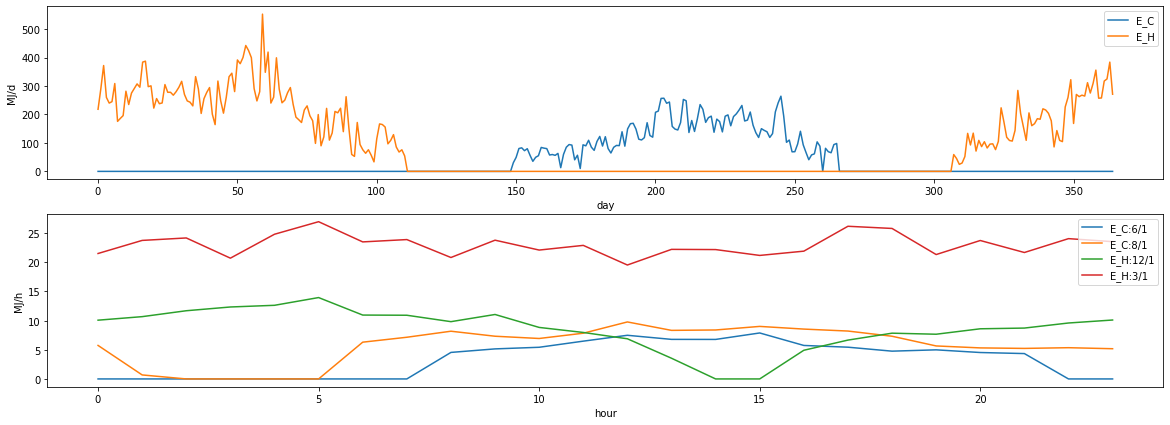

In [85]:
get_each_graph(_E_C_d_t_1, _E_H_d_t_1)

### Ë®àÁÆóÊù°‰ª∂2

- Âú∞ÂüüÂå∫ÂàÜ„Çí1Âú∞Âüü„Å´Â§âÊõ¥

In [86]:
house_base, C_A, H_A = get_default_central_heating_system_with_duct()
house_base['region'] = 1

_E_C_d_t_2, _E_H_d_t_2 = calc_results(house_base, C_A, H_A)


‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè E_C:3151.6467125592953MJ/y„ÄÅE_H:141367.326695553MJ/y


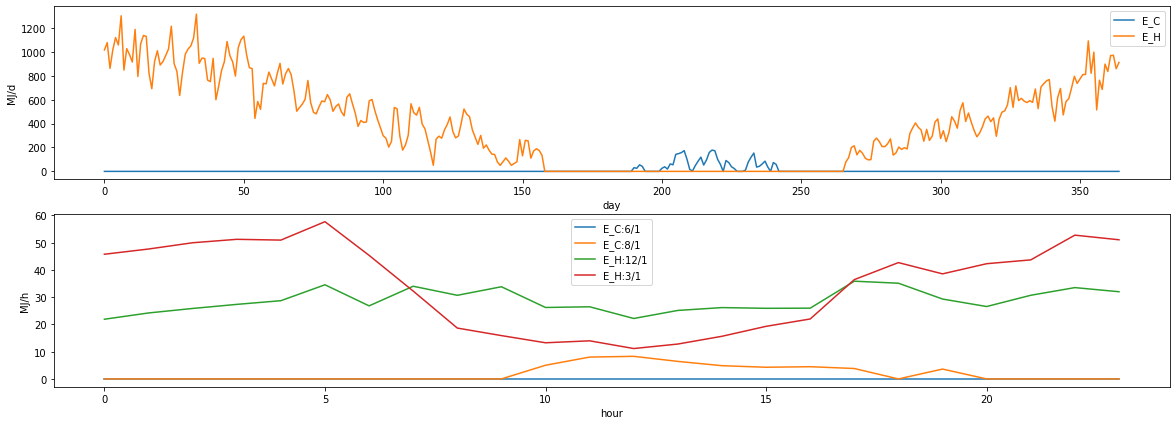

In [87]:
get_each_graph(_E_C_d_t_2, _E_H_d_t_2)

### Ë®àÁÆóÊù°‰ª∂3

- ‰ΩèÊà∏„ÄÅ‰∏ªÂ±ÖÂÆ§„ÄÅ„Åù„ÅÆ‰ªñÂ±ÖÂÆ§„ÅÆÂ∫äÈù¢Á©ç„Çí90m2„ÄÅ25m2„ÄÅ40m2„Å´Â§âÊõ¥
- Â§ñÁöÆÈù¢Á©ç„ÅÆÂêàË®à„Çí250m2„Å´Â§âÊõ¥

In [88]:
house_base, C_A, H_A = get_default_central_heating_system_with_duct()

house_base['A_A'] = 90
house_base['A_MR'] = 25
house_base['A_OR'] = 40
house_base['A_env'] = 250


_E_C_d_t_3, _E_H_d_t_3 = calc_results(house_base, C_A, H_A)    

‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè E_C:12064.848995914122MJ/y„ÄÅE_H:32734.351845529964MJ/y


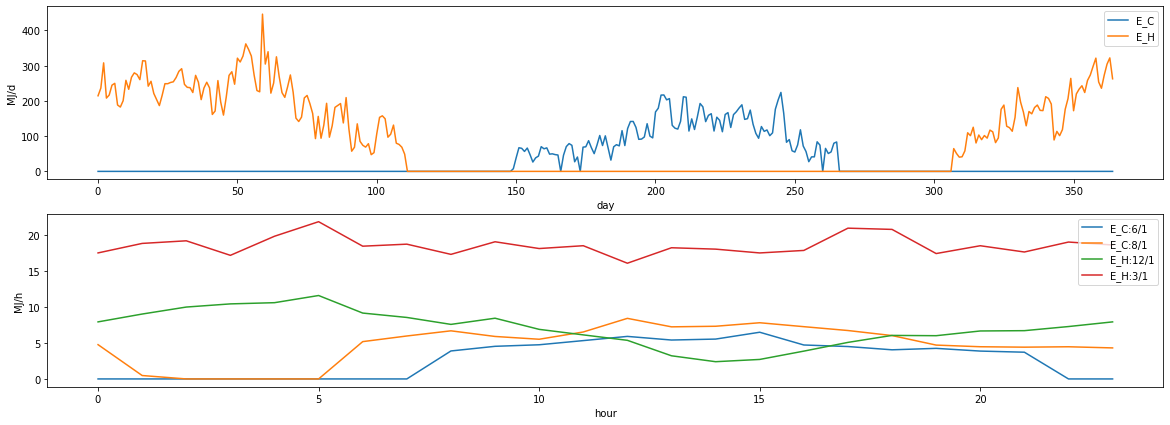

In [89]:
get_each_graph(_E_C_d_t_3, _E_H_d_t_3)

### Ë®àÁÆóÊù°‰ª∂4

- Â§ñÁöÆÂπ≥ÂùáÁÜ±Ë≤´ÊµÅÁéá„Çí0.6„Å´Â§âÊõ¥

In [90]:
house_base, C_A, H_A = get_default_central_heating_system_with_duct()
house_base['U_A'] = 0.6

_E_C_d_t_4, _E_H_d_t_4 = calc_results(house_base, C_A, H_A)    

‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè E_C:15776.744106489657MJ/y„ÄÅE_H:28097.11553361559MJ/y


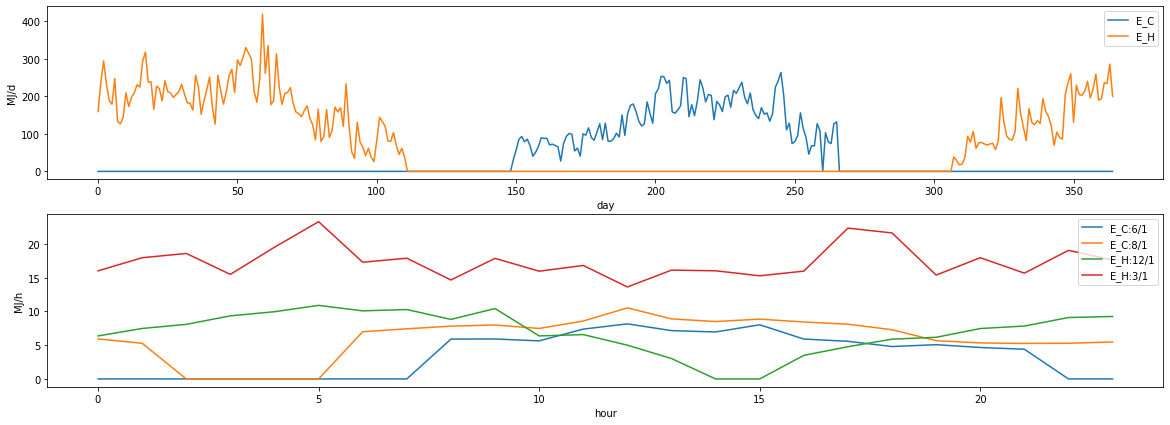

In [91]:
get_each_graph(_E_C_d_t_4, _E_H_d_t_4)

### Ë®àÁÆóÊù°‰ª∂5

- ÊöñÊàøÊúüÂπ≥ÂùáÊó•Â∞ÑÁÜ±ÂèñÂæóÁéá„Çí3.0„Å´Â§âÊõ¥

In [92]:
house_base, C_A, H_A = get_default_central_heating_system_with_duct()
house_base['eta_A_H'] = 3.0

_E_C_d_t_5, _E_H_d_t_5 = calc_results(house_base, C_A, H_A)

‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè E_C:14746.052998129611MJ/y„ÄÅE_H:42553.81444879264MJ/y


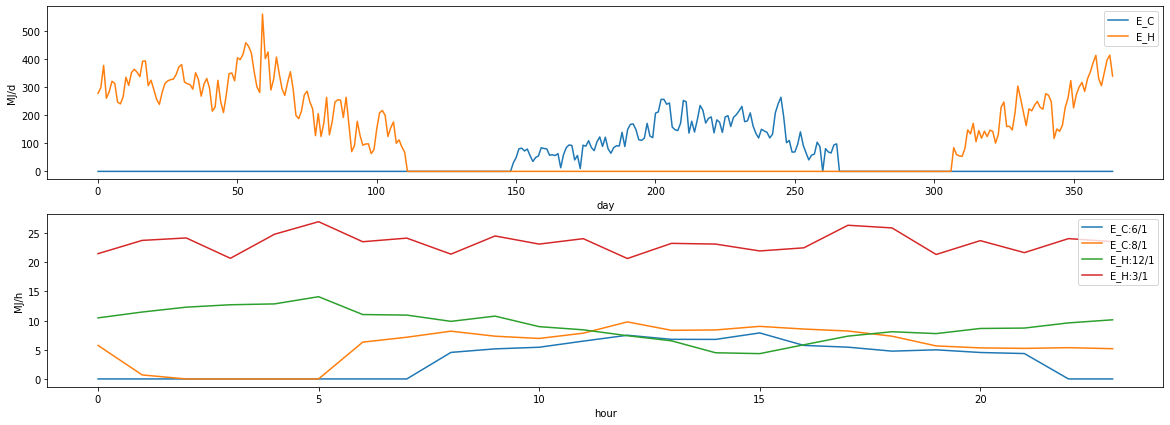

In [93]:
get_each_graph(_E_C_d_t_5, _E_H_d_t_5)

### Ë®àÁÆóÊù°‰ª∂6

- ÂÜ∑ÊàøÊúüÂπ≥ÂùáÊó•Â∞ÑÁÜ±ÂèñÂæóÁéá„Çí2.0„Å´Â§âÊõ¥

In [94]:
house_base, C_A, H_A = get_default_central_heating_system_with_duct()
house_base['eta_A_C'] = 2.0

_E_C_d_t_6, _E_H_d_t_6 = calc_results(house_base, C_A, H_A)

‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè E_C:12603.125355747807MJ/y„ÄÅE_H:36310.32799729332MJ/y


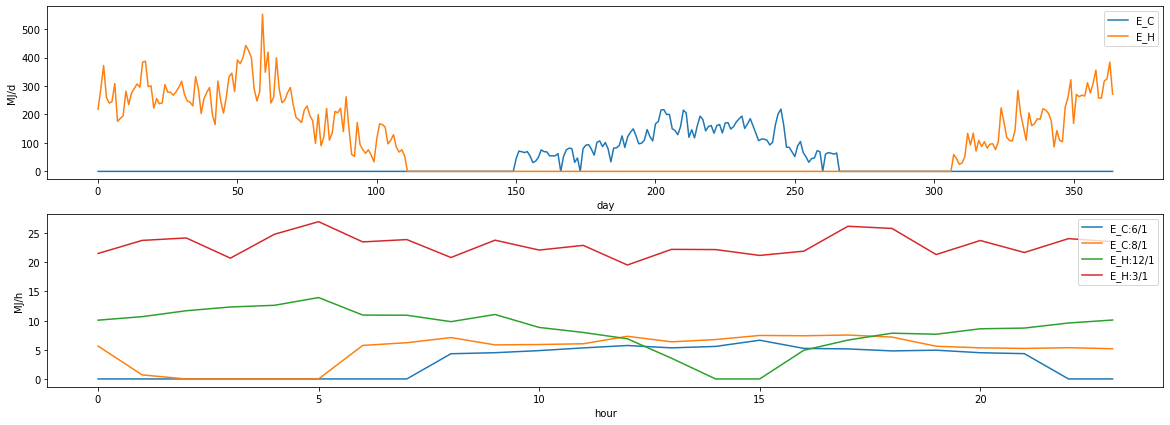

In [95]:
get_each_graph(_E_C_d_t_6, _E_H_d_t_6)

### Ë®àÁÆóÊù°‰ª∂7

- ÂÆöÊ†ºÊöñÊàøËÉΩÂäõË©¶È®ì„ÄÅÂÆöÊ†ºÂÜ∑ÊàøËÉΩÂäõË©¶È®ì„ÅÆÂÄ§„ÇíÂÖ•Âäõ„Åô„Çã„Å´Â§âÊõ¥

In [96]:
house_base, C_A, H_A = get_default_central_heating_system_with_duct()
C_A['EquipmentSpec'] = 'ÂÆöÊ†ºËÉΩÂäõË©¶È®ì„ÅÆÂÄ§„ÇíÂÖ•Âäõ„Åô„Çã'
C_A['q_hs_rtd_C'] = 5000
C_A['P_hs_rtd_C'] = 1500
C_A['V_fan_rtd_C'] = 2000
C_A['P_fan_rtd_C'] = 150

H_A['EquipmentSpec'] = 'ÂÆöÊ†ºËÉΩÂäõË©¶È®ì„ÅÆÂÄ§„ÇíÂÖ•Âäõ„Åô„Çã'
H_A['q_hs_rtd_H'] = 5500
H_A['P_hs_rtd_H'] = 1500
H_A['V_fan_rtd_H'] = 2000
H_A['P_fan_rtd_H'] = 150

_E_C_d_t_7, _E_H_d_t_7 = calc_results(house_base, C_A, H_A)


‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè E_C:13087.721204357189MJ/y„ÄÅE_H:34608.12124230976MJ/y


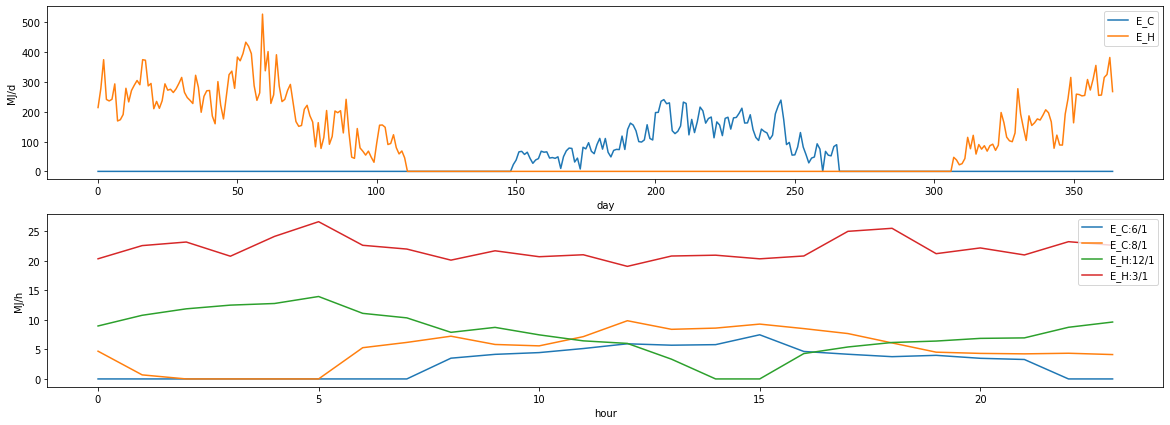

In [97]:
get_each_graph(_E_C_d_t_7, _E_H_d_t_7)

### Ë®àÁÆóÊù°‰ª∂8

- ÂÆöÊ†ºËÉΩÂäõË©¶È®ì„Å®‰∏≠ÈñìËÉΩÂäõË©¶È®ì„ÅÆÂÄ§„ÇíÂÖ•Âäõ„Åô„Çã„Å´Â§âÊõ¥

In [98]:
house_base, C_A, H_A = get_default_central_heating_system_with_duct()

C_A['EquipmentSpec'] = 'ÂÆöÊ†ºËÉΩÂäõË©¶È®ì„Å®‰∏≠ÈñìËÉΩÂäõË©¶È®ì„ÅÆÂÄ§„ÇíÂÖ•Âäõ„Åô„Çã'
C_A['q_hs_rtd_C'] = 5000
C_A['P_hs_rtd_C'] = 1500
C_A['V_fan_rtd_C'] = 2000
C_A['P_fan_rtd_C'] = 150
C_A['q_hs_mid_C'] = 3000
C_A['P_hs_mid_C'] = 1000
C_A['V_fan_mid_C'] = 1000
C_A['P_fan_mid_C'] = 80
C_A['V_hs_dsgn_C'] = 1500

H_A['EquipmentSpec'] = 'ÂÆöÊ†ºËÉΩÂäõË©¶È®ì„Å®‰∏≠ÈñìËÉΩÂäõË©¶È®ì„ÅÆÂÄ§„ÇíÂÖ•Âäõ„Åô„Çã'
H_A['q_hs_rtd_H'] = 5500
H_A['P_hs_rtd_H'] = 1500
H_A['V_fan_rtd_H'] = 2000
H_A['P_fan_rtd_H'] = 150
H_A['q_hs_mid_H'] = 3200
H_A['P_hs_mid_H'] = 1000
H_A['V_fan_mid_H'] = 1000
H_A['P_fan_mid_H'] = 80
H_A['V_hs_dsgn_H'] = 1500

_E_C_d_t_8, _E_H_d_t_8 = calc_results(house_base, C_A, H_A)


‰∏ÄÊ¨°„Ç®„Éç„É´„ÇÆ„ÉºÊ∂àË≤ªÈáè E_C:13501.274781274133MJ/y„ÄÅE_H:36253.68181018293MJ/y


### ÊØîËºÉ

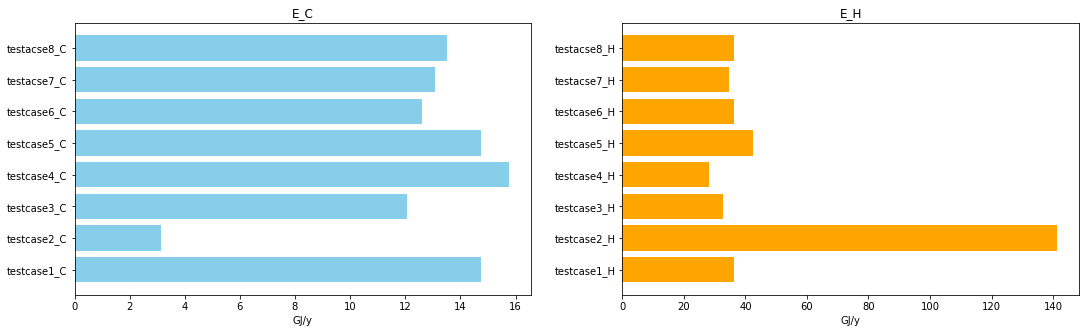

In [99]:
import matplotlib.pyplot as plt

dat_C = {"testcase1_C": np.sum(_E_C_d_t_1)/1000, "testcase2_C": np.sum(_E_C_d_t_2)/1000, "testcase3_C": np.sum(_E_C_d_t_3)/1000, 
         "testcase4_C": np.sum(_E_C_d_t_4)/1000, "testcase5_C": np.sum(_E_C_d_t_5)/1000, "testcase6_C": np.sum(_E_C_d_t_6)/1000,
         "testacse7_C": np.sum(_E_C_d_t_7)/1000, "testacse8_C": np.sum(_E_C_d_t_8)/1000}
dat_H = {"testcase1_H": np.sum(_E_H_d_t_1)/1000, "testcase2_H": np.sum(_E_H_d_t_2)/1000, "testcase3_H": np.sum(_E_H_d_t_3)/1000, 
         "testcase4_H": np.sum(_E_H_d_t_4)/1000, "testcase5_H": np.sum(_E_H_d_t_5)/1000, "testcase6_H": np.sum(_E_H_d_t_6)/1000,
         "testacse7_H": np.sum(_E_H_d_t_7)/1000, "testacse8_H": np.sum(_E_H_d_t_8)/1000}

x_C = list(dat_C.keys())
x_H = list(dat_H.keys())
y_C = list(dat_C.values())
y_H = list(dat_H.values())

fig = plt.figure(figsize=(18,5))
grh_C = fig.add_subplot(121)
grh_C.barh(x_C,y_C, color = "skyblue")
grh_C.set_title("E_C")
grh_C.set_xlabel("GJ/y")

grh_H = fig.add_subplot(122)
grh_H.barh(x_H,y_H, color = "orange")
grh_H.set_xlabel("GJ/y")
grh_H.set_title("E_H")

plt.show()